In [1]:
%load_ext autoreload
%autoreload 2

import os, sys

from skimage.io import imread
from skimage.exposure import rescale_intensity
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import DataFrame

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *
from visualization_utilities import *

Setting environment for Precision WorkStation


No vtk
No vtk

In [2]:
def match_histogram(source, template):
    """
    Args:
        source: "from" image
        template: "to" image
    
    Returns: 
        s_values (array): unique source values
        interp_t_values (array): unique destination values
    """
    
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return s_values, interp_t_values

# Test (mean, std) normalization

In [5]:
tb_mask = DataManager.load_thumbnail_mask_v3(stack='ChatCryoJane201710', prep_id=2, section=150)

In [13]:
img = DataManager.load_image_v2(stack='ChatCryoJane201710', prep_id=2, section=150, version='Ntb')

In [14]:
h, w = img.shape

In [23]:
def sample_region(image_size, tb_mask, region_size=(5000,5000)):
    """
    Randomly sample square regions that are within the given mask.
    
    Args:
        tb_mask (2d-ndarray of bool): mask in thumbnail resolution.
    
    Returns:
        (xmin, xmax, ymin, ymax): sampled region bounding box.
    """
    
    w, h = image_size
    region_w, region_h = region_size
    
    while True:

        region_x = np.random.randint(0, w-10000, 1)[0]
        region_y = np.random.randint(0, h-10000, 1)[0]
#         region_w = 5000
#         region_h = 5000

        tb_region_xmin = region_x / 32
        tb_region_xmax = (region_x + region_w) / 32
        tb_region_ymin = region_y / 32
        tb_region_ymax = (region_y + region_h) / 32

        if np.all(np.r_[tb_mask[tb_region_ymin, tb_region_xmin],
        tb_mask[tb_region_ymin, tb_region_xmax],
        tb_mask[tb_region_ymax, tb_region_xmin],
        tb_mask[tb_region_ymax, tb_region_xmax]]):
            break

#     print region_x, region_y, region_w, region_h
    return (region_x, region_x + region_w - 1, region_y, region_y + region_h - 1)

In [4]:
img_fp = DataManager.get_image_filepath_v2(stack='ChatCryoJane201710', prep_id=2, section=150, version='Ntb')

In [33]:
img_cropped_all_regions = {}
img_cropped_normalized_all_regions = {}
mu_sigma_all_regions = {}

region_w, region_h = (3000, 3000)

for region_x in range(0, w, 5000):
    for region_y in range(0, h, 5000):
        bbox = (region_x, region_x+region_w+1, region_y, region_y+region_h+1)
        
        tb_region_xmin = region_x / 32
        tb_region_xmax = (region_x + region_w) / 32
        tb_region_ymin = region_y / 32
        tb_region_ymax = (region_y + region_h) / 32
        
        if tb_region_xmax > tb_mask.shape[1] or tb_region_ymax > tb_mask.shape[0]:
            continue
        
        if not np.all(np.r_[tb_mask[tb_region_ymin, tb_region_xmin],
            tb_mask[tb_region_ymin, tb_region_xmax],
            tb_mask[tb_region_ymax, tb_region_xmin],
            tb_mask[tb_region_ymax, tb_region_xmax]]):
            continue
        
#     img_cropped = crop_large_image(img_fp, bbox)
        img_cropped = img[bbox[2]:bbox[3]+1, bbox[0]:bbox[1]+1]
        
#         img_cropped_all_regions[bbox] = img_cropped
        img_cropped_all_regions[(region_x, region_y)] = img_cropped

        mu = img_cropped.mean()
        sigma = img_cropped.std()
#         mu_sigma_all_regions[bbox] = (mu, sigma)
        mu_sigma_all_regions[(region_x, region_y)] = (mu, sigma)

        img_cropped_normalized = (img_cropped - mu)/sigma
#         img_cropped_normalized_all_regions[bbox] = img_cropped_normalized
        img_cropped_normalized_all_regions[(region_x, region_y)] = img_cropped_normalized

        # plt.imshow(img_cropped, cmap=plt.cm.gray, vmin=0, vmax=65535);
        #     plt.imshow(img_cropped_normalized, cmap=plt.cm.gray);

In [34]:
mu_sigma_all_regions

{(0, 5000): (5490.4624151298649, 4693.4788414152072),
 (0, 10000): (5228.1076762726689, 4016.9928033954984),
 (5000, 5000): (5527.0697709410697, 3583.402340686469),
 (5000, 10000): (5256.296240880497, 4568.8278719740674),
 (10000, 5000): (5570.4994981138489, 3447.6587295248582),
 (10000, 10000): (5337.8262809248645, 4365.6675419554113),
 (15000, 5000): (6209.7205364089941, 4854.487140451668),
 (15000, 10000): (6639.6316288807684, 5232.3694399570841),
 (15000, 15000): (23844.584122798879, 26204.293263127762),
 (20000, 15000): (26159.643465315818, 27052.748591378589)}

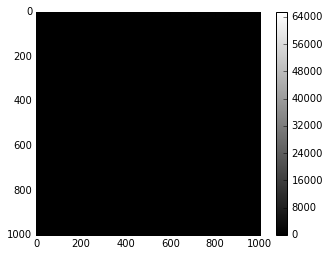

In [11]:
for bbox, im in img_cropped_all_regions.iteritems():
    plt.figure()
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=65535);
    plt.colorbar();
    plt.show();

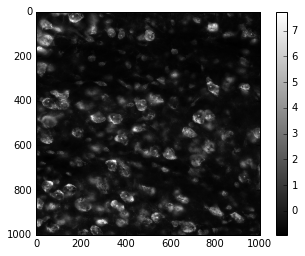

In [38]:
for bbox, im in img_cropped_normalized_all_regions.iteritems():
    plt.figure()
    plt.imshow(im, cmap=plt.cm.gray);
    plt.colorbar();
    plt.show();

convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide50-S3_prep2_lossless_Ntb.tif -crop 1001x1001+1000+1000 /tmp/tmp.tif


/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


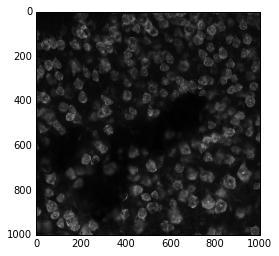

convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide50-S3_prep2_lossless_Ntb.tif -crop 1001x1001+11000+11000 /tmp/tmp.tif


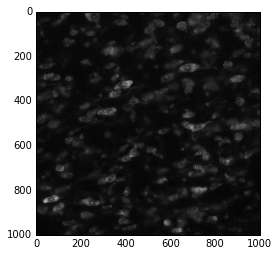

convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide50-S3_prep2_lossless_Ntb.tif -crop 1001x1001+21000+21000 /tmp/tmp.tif


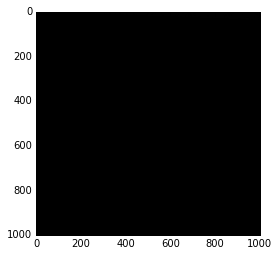

In [10]:
plt.figure()
img_cropped = crop_large_image(img_fp, (1000,2000, 1000,2000))
plt.imshow(img_cropped, cmap=plt.cm.gray, vmin=0, vmax=65535);
plt.show();

plt.figure()
img_cropped = crop_large_image(img_fp, (11000,12000, 11000,12000))
plt.imshow(img_cropped, cmap=plt.cm.gray, vmin=0, vmax=65535);
plt.show();

plt.figure()
img_cropped = crop_large_image(img_fp, (21000, 22000, 21000, 22000))
plt.imshow(img_cropped, cmap=plt.cm.gray, vmin=0, vmax=65535);
plt.show();

## Adhoc region

In [ ]:
nissl_region1 = DataManager.load_image_v2(stack='MD658', prep_id=2, version='grayJpeg', fn='MD658-F50-2017.04.05-03.53.13_MD658_2_0149')[955*8:(955+141)*8, 1516*8:(1516+366)*8]

In [ ]:
roi_xmin =1400 * 8
roi_ymin = 929 * 8
roi_w = 421 * 8
roi_h = 246 * 8
ntb_blue_region1 = DataManager.load_image_v2(stack='MD661', prep_id=2, fn='MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227')[roi_ymin:(roi_ymin+roi_h), roi_xmin:(roi_xmin+roi_w), 2]

In [ ]:
ntb_blue_region1_inv = 5000 - ntb_blue_region1.astype(np.int)
ntb_inv_vals, nissl_vals = match_histogram(ntb_blue_region1_inv, nissl_region1)

ntb_blue_bins = np.arange(5001)

ntb_blue_inv_bins = np.arange(5001)
ntb_inv_to_nissl_mapping = np.interp(ntb_blue_inv_bins, ntb_inv_vals, nissl_vals)

ntb_to_nissl_mapping = ntb_inv_to_nissl_mapping[5000 - ntb_blue_bins]
ntb_to_nissl_mapping = np.round(ntb_to_nissl_mapping).astype(np.uint8)

In [ ]:
np.savetxt('/tmp/ntb_to_nissl_mapping.npy', ntb_to_nissl_mapping)

In [ ]:
plt.plot(ntb_to_nissl_mapping);

In [ ]:
img_blue_intensity_normalized = ntb_to_nissl_mapping[ntb_blue_region1.astype(np.int)].astype(np.uint8)

In [ ]:
plt.imshow(img_blue_intensity_normalized, plt.cm.gray);

In [ ]:
plt.imshow(nissl_region1, plt.cm.gray);

In [ ]:
# stack = 'MD635'
# _, sec2fn = DataManager.load_sorted_filenames(stack)
# first_sec, last_sec = DataManager.load_cropbox(stack)[4:]

# Match histograms between Nissl and Neurotrace

In [ ]:
nissl_sections = [sec for sec, fn in sec2fn.iteritems() if not is_invalid(fn) and fn.split('-')[1][0] == 'N' and sec > first_sec and sec < last_sec]
ntb_sections = [sec for sec, fn in sec2fn.iteritems() if not is_invalid(fn) and fn.split('-')[1][0] == 'F' and sec > first_sec and sec < last_sec]

In [ ]:
# Generate nissl-ntb pairs.

compare_pairs = []
for nissl_sec in nissl_sections:
    for i in range(1, 10):
        closest_ntb_sec = nissl_sec + i
        if closest_ntb_sec in ntb_sections:
            break
    compare_pairs.append((nissl_sec, closest_ntb_sec))

In [ ]:
w, h = metadata_cache['image_shape'][stack]

## Same region, different images

In [ ]:
# Sample the region bbox.

while True:
    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')
    
    region1_x = np.random.randint(0, w-10000, 1)[0]
    region1_y = np.random.randint(0, h-10000, 1)[0]
    region1_w = 5000
    region1_h = 5000
    print region1_x, region1_y, region1_w, region1_h

    tb_region1_xmin = region1_x / 32
    tb_region1_xmax = (region1_x + region1_w) / 32
    tb_region1_ymin = region1_y / 32
    tb_region1_ymax = (region1_y + region1_h) / 32

    if np.all(np.r_[nissl_tb_mask[tb_region1_ymin, tb_region1_xmin],
    nissl_tb_mask[tb_region1_ymin, tb_region1_xmax],
    nissl_tb_mask[tb_region1_ymax, tb_region1_xmin],
    nissl_tb_mask[tb_region1_ymax, tb_region1_xmax]]):
        break

In [ ]:
ntb_matched_values_all_examples = []

for nissl_sec, ntb_sec in compare_pairs[:10]:
    
    ntb_im_fp = DataManager.get_image_filepath(stack=stack, section=ntb_sec, version='cropped_16bit', resol='lossless')
    download_from_s3(ntb_im_fp)
    ntb_im = imread(ntb_im_fp)
    ntb_blue_region1 = ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]
    ntb_blue_region1 = 3000 - ntb_blue_region1
    
    ntb_blue_bins = np.arange(0, ntb_blue_region1.max()+2)
    ntb_blue_hist = np.histogram(ntb_blue_region1.flatten(), bins=ntb_blue_bins)[0]
    
    nissl_im_fp = DataManager.get_image_filepath(stack=stack, section=nissl_sec, version='cropped_8bit', resol='lossless')
    download_from_s3(nissl_im_fp)
    nissl_im = imread(nissl_im_fp)
    nissl_region1 = img_as_ubyte(rgb2gray(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))
    
    nissl_gray_bins = np.arange(0, 257)
    nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]
    
    ###############
    
    ntb_region1_hist_matched = hist_match(ntb_blue_region1, nissl_region1)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));
    axes[0].imshow(nissl_region1, plt.cm.gray);
    axes[0].set_title('Nissl');
    axes[1].imshow(ntb_region1_hist_matched.astype(np.uint8), plt.cm.gray);
    axes[1].set_title('Neurotrace (histogram matched)');
    plt.show();
    
    ntb_to_nissl = {}
    for ntb_v in ntb_blue_bins[:-1]:
        a = ntb_region1_hist_matched[ntb_blue_region1 == ntb_v]
        if len(a) > 0:
            ntb_to_nissl[ntb_v] = np.unique(a)[0]

    ntb_values = np.arange(0, 5000)
    ntb_matched_values = np.interp(ntb_values, 
                                   [ntb_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())], 
                                   [nissl_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())])
    
    ntb_matched_values_all_examples.append(ntb_matched_values)

    plt.plot(ntb_values, ntb_matched_values);
    plt.xlim([0,5000]);
    plt.ylim([0,256]);
    plt.xlabel('Neurotrace intensity');
    plt.ylabel('Matched nissl intensity');
    plt.show();

In [ ]:
plt.figure(figsize=(10,5));
for a in ntb_matched_values_all_examples:
    plt.plot(ntb_values, a);
plt.xlim([0,5000]);
plt.ylim([0,256]);
plt.xlabel('Neurotrace intensity');
plt.ylabel('Matched nissl intensity');
plt.show();

In [ ]:
# Show that intensities of two modalities are not in exact one-to-one correspondence.

ntb_to_nissl = {}
for ntb_v in ntb_blue_bins[:-1]:
    a = nissl_region1[ntb_blue_region1 == ntb_v]
    if len(a) > 0:
#         ntb_to_nissl[ntb_v] = np.unique(a)[0]
        plt.hist(a, bins=np.arange(256));
        plt.title('%d' % ntb_v);
        plt.xlabel('Nissl intensity');
        plt.xlabel('Distribution of Neurotrace intensities at corresponding pixels.');
        plt.show();

# Explore red and green channels

In [ ]:
from skimage.exposure import rescale_intensity
from skimage.exposure import equalize_hist

In [ ]:
plt.figure(figsize=(20,20));
q = rescale_intensity(ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0],
                     (0, 400))
plt.imshow(q, 
           vmin=0, vmax=q.max(),
          cmap=plt.cm.gray);

In [ ]:
plt.figure(figsize=(20,20));
q = equalize_hist(ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0])
plt.imshow(q, 
           vmin=0, vmax=q.max(),
          cmap=plt.cm.gray);

In [ ]:
plt.figure(figsize=(20,20));
plt.imshow(ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0], 
           vmin=0, vmax=ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0].max(),
          cmap=plt.cm.gray);

In [ ]:
red_imin = 0
red_imax = 75
green_imin = 0
green_imax = 85

In [ ]:
mg_red_intensity_normalized = ntb_matched_values[3000-ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 0]].astype(np.uint8)
img_green_intensity_normalized = ntb_matched_values[3000-ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 1]].astype(np.uint8)
img_blue_intensity_normalized = ntb_matched_values[3000-ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]].astype(np.uint8)

In [ ]:
ntb_img_rgb = np.zeros(ntb_blue_region1.shape[:2] + (3,), np.uint8)
ntb_img_rgb[..., 0] = img_red_intensity_normalized
ntb_img_rgb[..., 1] = img_green_intensity_normalized
ntb_img_rgb[..., 2] = img_blue_intensity_normalized

In [ ]:
plt.figure(figsize=(10,10));
plt.imshow(ntb_img_rgb, cmap=plt.cm.gray);

# Same images, different regions. nissl-ntblue

## Parallel

In [ ]:
def f(nissl_sec, ntb_sec):
    
    ntb_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []
    
    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')
    
    for region_id in range(10):

        while True:
            region1_x = np.random.randint(0, w-10000, 1)[0]
            region1_y = np.random.randint(0, h-10000, 1)[0]
            region1_w = 5000
            region1_h = 5000
            print region1_x, region1_y, region1_w, region1_h
            
            tb_region1_xmin = region1_x / 32
            tb_region1_xmax = (region1_x + region1_w) / 32
            tb_region1_ymin = region1_y / 32
            tb_region1_ymax = (region1_y + region1_h) / 32
            
            if np.all(np.r_[nissl_tb_mask[tb_region1_ymin, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymin, tb_region1_xmax],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmax]]):
                break
        
        t = time.time()
        
        ntb_im_fp = DataManager.get_image_filepath(stack=stack, section=ntb_sec, version='cropped_16bit', resol='lossless')
        download_from_s3(ntb_im_fp)
        ntb_im = imread(ntb_im_fp)
        ntb_blue_region1 = ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]
        ntb_blue_region1 = 3000 - ntb_blue_region1

        ntb_blue_bins = np.arange(0, ntb_blue_region1.max()+2)
        ntb_blue_hist = np.histogram(ntb_blue_region1.flatten(), bins=ntb_blue_bins)[0]
        
        sys.stderr.write('Load NTB: %.2f seconds.\n' % (time.time()-t))

        t = time.time()

        nissl_im_fp = DataManager.get_image_filepath(stack=stack, section=nissl_sec, version='cropped_8bit', resol='lossless')
        download_from_s3(nissl_im_fp)
        nissl_im = imread(nissl_im_fp)
        nissl_region1 = img_as_ubyte(rgb2gray(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))

        nissl_gray_bins = np.arange(0, 257)
        nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]
        
        sys.stderr.write('Load Nissl: %.2f seconds.\n' % (time.time()-t))

        ###############
        
        t = time.time()

        ntb_region1_hist_matched = hist_match(ntb_blue_region1, nissl_region1)

    #     fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));
    #     axes[0].imshow(nissl_region1, plt.cm.gray);
    #     axes[0].set_title('Nissl');
    #     axes[1].imshow(ntb_region1_hist_matched.astype(np.uint8), plt.cm.gray);
    #     axes[1].set_title('Neurotrace (histogram matched)');
    #     plt.show();
        ntb_to_nissl = {}
        for ntb_v in ntb_blue_bins[:-1]:
            a = ntb_region1_hist_matched[ntb_blue_region1 == ntb_v]
            if len(a) > 0:
                ntb_to_nissl[ntb_v] = np.unique(a)[0]

        ntb_values = np.arange(0, 5000)
        ntb_matched_values = np.interp(ntb_values, 
                                       [ntb_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())], 
                                       [nissl_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())])

        ntb_matched_values_all_examples_one_section.append(ntb_matched_values)
        region_bboxes_all_examples_one_section.append((region1_x, region1_y, region1_w, region1_h))

        sys.stderr.write('Compute matching: %.2f seconds.\n' % (time.time()-t))
        
#         ntb_matched_values_all_examples[(nissl_sec, ntb_sec)].append(ntb_matched_values)
#         region_bboxes_all_examples[(nissl_sec, ntb_sec)].append((region1_x, region1_y, region1_w, region1_h))
        
    fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'ntb_%d_to_nissl_%d_matched_values.npy' % (ntb_sec, nissl_sec))
    np.save(fp, ntb_matched_values_all_examples_one_section)
    upload_to_s3(fp)

    fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'ntb_%d_to_nissl_%d_region_bboxes.npy' % (ntb_sec, nissl_sec))
    np.save(fp, np.asarray(region_bboxes_all_examples_one_section))
    upload_to_s3(fp)

In [ ]:
from multiprocess import Pool

pool = Pool(NUM_CORES/2)
pool.map(lambda (nissl_sec, ntb_sec): f( nissl_sec, ntb_sec), compare_pairs)
pool.close()
pool.join()

## Sequential

In [ ]:
# ntb_matched_values_all_examples = defaultdict(list)
# region_bboxes_all_examples = defaultdict(list)

for nissl_sec, ntb_sec in compare_pairs[37:38]:
    
    ntb_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []
    
    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')

    for region_id in range(10):
        
        while True:
            region1_x = np.random.randint(0, w-10000, 1)[0]
            region1_y = np.random.randint(0, h-10000, 1)[0]
            region1_w = 5000
            region1_h = 5000
            print region1_x, region1_y, region1_w, region1_h
            
            tb_region1_xmin = region1_x / 32
            tb_region1_xmax = (region1_x + region1_w) / 32
            tb_region1_ymin = region1_y / 32
            tb_region1_ymax = (region1_y + region1_h) / 32
            
            if np.all(np.r_[nissl_tb_mask[tb_region1_ymin, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymin, tb_region1_xmax],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmax]]):
                break
        
        t = time.time()
        
        ntb_im_fp = DataManager.get_image_filepath(stack=stack, section=ntb_sec, version='cropped_16bit', resol='lossless')
        download_from_s3(ntb_im_fp)
        ntb_im = imread(ntb_im_fp)
        ntb_blue_region1 = ntb_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w, 2]
        ntb_blue_region1 = 3000 - ntb_blue_region1

        ntb_blue_bins = np.arange(0, ntb_blue_region1.max()+2)
        ntb_blue_hist = np.histogram(ntb_blue_region1.flatten(), bins=ntb_blue_bins)[0]
    
        sys.stderr.write('Load NTB: %.2f seconds.\n' % (time.time()-t))

        t = time.time()
        
        nissl_im_fp = DataManager.get_image_filepath(stack=stack, section=nissl_sec, version='cropped_8bit', resol='lossless')
        download_from_s3(nissl_im_fp)
        nissl_im = imread(nissl_im_fp)
        nissl_region1 = img_as_ubyte(rgb2gray(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w]))

        nissl_gray_bins = np.arange(0, 257)
        nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]

        sys.stderr.write('Load Nissl: %.2f seconds.\n' % (time.time()-t))

        ###############
        
        t = time.time()

        ntb_region1_hist_matched = hist_match(ntb_blue_region1, nissl_region1)

        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));
        axes[0].imshow(nissl_region1, plt.cm.gray);
        axes[0].set_title('Nissl');
        axes[1].imshow(ntb_region1_hist_matched.astype(np.uint8), plt.cm.gray);
        axes[1].set_title('Neurotrace (histogram matched)');
        plt.show();

        ntb_to_nissl = {}
        for ntb_v in ntb_blue_bins[:-1]:
            a = ntb_region1_hist_matched[ntb_blue_region1 == ntb_v]
            if len(a) > 0:
                ntb_to_nissl[ntb_v] = np.unique(a)[0]

        ntb_values = np.arange(0, 5000)
        ntb_matched_values = np.interp(ntb_values, 
                                       [ntb_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())], 
                                       [nissl_v for ntb_v, nissl_v in sorted(ntb_to_nissl.items())])

    #     ntb_matched_values_all_examples.append(ntb_matched_values)

        ntb_matched_values_all_examples_one_section.append(ntb_matched_values)
        region_bboxes_all_examples_one_section.append((region1_x, region1_y, region1_w, region1_h))
    
#         ntb_matched_values_all_examples[(nissl_sec, ntb_sec)].append(ntb_matched_values)
#         region_bboxes_all_examples[(nissl_sec, ntb_sec)].append((region1_x, region1_y, region1_w, region1_h))
        
        sys.stderr.write('Compute matching: %.2f seconds.\n' % (time.time()-t))

        
#     fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'ntb_%d_to_nissl_%d_matched_values.npy' % (ntb_sec, nissl_sec))
#     np.save(fp, ntb_matched_values_all_examples_one_section)
#     upload_to_s3(fp)

#     fp = os.path.join(DATA_DIR, stack, stack + '_histogram_matching', 'ntb_%d_to_nissl_%d_region_bboxes.npy' % (ntb_sec, nissl_sec))
#     np.save(fp, np.asarray(region_bboxes_all_examples_one_section))
#     upload_to_s3(fp)
    
    #     plt.plot(ntb_values, ntb_matched_values);
    #     plt.xlim([0,5000]);
    #     plt.ylim([0,256]);
    #     plt.xlabel('Neurotrace intensity');
    #     plt.ylabel('Matched nissl intensity');
    #     plt.show();

# One image pair, different regions (NEW)

In [ ]:
# Find the maximal intensity in fluorescent blue channel.

# for fn in metadata_cache['valid_filenames'][stack][::10]:
#     if fn.split('-')[1][0] == 'F':
#         im = DataManager.load_image(stack=stack, fn=fn, version='cropped_16bit', resol='lossless')[..., 2]
#         print fn, im.min(), im.max()

In [ ]:
# for nissl_sec, ntb_sec in compare_pairs[34:35]:
for nissl_sec, ntb_sec in compare_pairs[25:45]:
# for nissl_sec, ntb_sec in compare_pairs[::3]:
    
    sys.stderr.write('nissl %d, ntb %d\n' % (nissl_sec, ntb_sec))
    
    ntb_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []
    
    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, version='cropped')
    w, h = metadata_cache['image_shape'][stack]

    t = time.time()
    ntb_im = DataManager.load_image(stack=stack, section=ntb_sec, version='cropped', resol='lossless')
    sys.stderr.write('Load NTB: %.2f seconds.\n' % (time.time()-t))

    t = time.time()
    nissl_im = DataManager.load_image(stack=stack, section=nissl_sec, version='cropped', resol='lossless')
    sys.stderr.write('Load Nissl: %.2f seconds.\n' % (time.time()-t))

#     h, w = nissl_im.shape[:2]
#     for region_id in range(3):
#         while True:
#             region_w = 5000
#             region_h = 5000
#             region_x = np.random.randint(0, w - region_w, 1)[0]
#             region_y = np.random.randint(0, h - region_h, 1)[0]
            
#             tb_region_xmin = region_x / 32
#             tb_region_xmax = (region_x + region_w) / 32
#             tb_region_ymin = region_y / 32
#             tb_region_ymax = (region_y + region_h) / 32
            
#             if np.all(np.r_[nissl_tb_mask[tb_region_ymin, tb_region_xmin],
#             nissl_tb_mask[tb_region_ymin, tb_region_xmax],
#             nissl_tb_mask[tb_region_ymax, tb_region_xmin],
#             nissl_tb_mask[tb_region_ymax, tb_region_xmax]]):
#                 break
        
#         sys.stderr.write('%d %d %d %d\n' % (region_x, region_y, region_w, region_h))
    
    for region_id in range(1):
        region_x = 233 * 32
        region_y = 299 * 32
        region_w = 124 * 32
        region_h = 98 * 32
    
        ntb_blue_region = ntb_im[region_y:region_y+region_h, region_x:region_x+region_w, 2]
        
        # Checked a few sections, maximal intensity value in blue channel is less than 5000.
        ntb_blue_bins = np.arange(5001)
        ntb_blue_hist = np.histogram(ntb_blue_region.flatten(), bins=np.r_[ntb_blue_bins, 5001])[0]
        
        ntb_blue_inv_bins = np.arange(5001)
        ntb_blue_inv_hist = np.histogram(5000 - ntb_blue_region.flatten(), bins=np.r_[ntb_blue_inv_bins, 5001])[0]
 
        nissl_region = img_as_ubyte(rgb2gray(nissl_im[region_y:region_y+region_h, region_x:region_x+region_w]))
        nissl_gray_bins = np.arange(0, 257)
        nissl_gray_hist = np.histogram(nissl_region.flatten(), bins=nissl_gray_bins)[0]        

        ###############

#         t = time.time()

        # Matched mapping
        ntb_blue_region_inv = 5000 - ntb_blue_region.astype(np.int)
        ntb_inv_vals, nissl_vals = match_histogram(ntb_blue_region_inv, nissl_region)
    
        ntb_blue_inv_bins = np.arange(0, 5001)
        ntb_inv_to_nissl_mapping = np.interp(ntb_blue_inv_bins, ntb_inv_vals, nissl_vals)
        
        ntb_to_nissl_mapping = ntb_inv_to_nissl_mapping[5000 - ntb_blue_bins]
        ntb_to_nissl_mapping = np.round(ntb_to_nissl_mapping).astype(np.uint8)

        ntb_region_normalized = np.round(ntb_to_nissl_mapping[ntb_blue_region]).astype(np.uint8)
        
        ntb_blue_normalized_bins = np.arange(0, 257)
        ntb_blue_normalized_hist = np.histogram(ntb_region_normalized.flatten(), bins=np.r_[ntb_blue_normalized_bins, 5001])[0]

#         ntb_matched_values_all_examples_one_section.append(ntb_to_nissl_mapping)
#         region_bboxes_all_examples_one_section.append((region_x, region_y, region_w, region_h))
        
        # Default mapping
        intensity_mapping_fp = DataManager.get_ntb_to_nissl_intensity_profile_mapping_filepath()
        download_from_s3(intensity_mapping_fp)
        default_ntb_to_nissl_mapping = np.load(intensity_mapping_fp)

        ntb_region_normalized_default = np.round(default_ntb_to_nissl_mapping[ntb_blue_region]).astype(np.uint8)        
        ntb_blue_normalized_bins_default = np.arange(0, 257)
        ntb_blue_normalized_hist_default = np.histogram(ntb_region_normalized_default.flatten(), bins=np.r_[ntb_blue_normalized_bins_default, 5001])[0]
    
#         sys.stderr.write('Compute matching: %.2f seconds.\n' % (time.time()-t))
        
        # Linear normalizations
        
        ntb_region_linearNormalized_diffClips = {}
        ntb_region_linearNormalized_inverted_diffClips = {}
        
        low = 0
        highs = range(500, 3000, 500)
        for high in highs:
            ntb_region_linearNormalized = rescale_intensity_v2(ntb_blue_region, low, high)
    #         ntb_blue_linearNormalized_bins = np.arange(0, 256)
    #         ntb_blue_linearNormalized_hist = np.histogram(ntb_region_linearNormalized.flatten(), bins=np.r_[ntb_blue_linearNormalized_bins, [257]])[0]

            ntb_region_linearNormalized_inverted = rescale_intensity_v2(ntb_blue_region, high, low)
    #         ntb_blue_linearNormalized_inverted_bins = np.arange(0, 256)
    #         ntb_blue_linearNormalized_inverted_hist = np.histogram(ntb_region_linearNormalized_inverted.flatten(), bins=np.r_[ntb_blue_linearNormalized_inverted_bins, [257]])[0]

    #         ntb_to_nissl_linear_mapping = np.zeros((5001,))
    #         ntb_to_nissl_linear_mapping[:high] = - 255 / float(high) * np.arange(high) + 255
    
            ntb_region_linearNormalized_diffClips[high] = ntb_region_linearNormalized
            ntb_region_linearNormalized_inverted_diffClips[high] = ntb_region_linearNormalized_inverted
        
#         # Plot intensity histograms
        
#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_bins, ntb_blue_hist);
#         plt.xlabel('Neurotrace blue intensity');
#         plt.ylabel('Number of pixels');
#         plt.title('Neurotrace Blue Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_bins, np.log(ntb_blue_hist));
#         plt.xlabel('Neurotrace blue intensity');
#         plt.ylabel('Log Number of pixels');
#         plt.title('Neurotrace Blue Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.plot(ntb_blue_bins, ntb_to_nissl_mapping);
#         plt.xlabel('Neurotrace intensity');
#         plt.ylabel('Normalized intensity');
#         plt.title('Neurotrace to Brightfield Nissl intensity mapping');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_inv_bins, ntb_blue_inv_hist);
#         plt.xlabel('5000 - Neurotrace blue intensity');
#         plt.ylabel('Log Number of pixels');
#         plt.title('Neurotrace Blue Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.plot(ntb_blue_inv_bins, ntb_inv_to_nissl_mapping);
#         plt.xlabel('5000 - Neurotrace intensity');
#         plt.ylabel('Normalized intensity');
#         plt.title('Neurotrace to Brightfield Nissl intensity mapping');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(nissl_gray_bins[:-1], nissl_gray_hist);
#         plt.xlabel('Nissl intensity');
#         plt.ylabel('Number of pixels');
#         plt.title('Nissl Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(nissl_gray_bins[:-1], np.log(nissl_gray_hist));
#         plt.xlabel('Nissl intensity');
#         plt.ylabel('Log Number of pixels');
#         plt.title('Nissl Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_normalized_bins, ntb_blue_normalized_hist);
#         plt.xlabel('Neurotrace blue normalized intensity');
#         plt.ylabel('Number of pixels');
#         plt.title('Neurotrace Blue Normalized Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_normalized_bins, np.log(ntb_blue_normalized_hist));
#         plt.xlabel('Neurotrace blue normalized intensity');
#         plt.ylabel('Log Number of pixels');
#         plt.title('Neurotrace Blue Normalized Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.plot(ntb_blue_bins, ntb_to_nissl_linear_mapping);
#         plt.xlabel('Neurotrace intensity');
#         plt.ylabel('Normalized intensity');
#         plt.title('Neurotrace to Brightfield Nissl intensity mapping (Linear)');
#         plt.show();


#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_linearNormalized_bins, ntb_blue_linearNormalized_hist);
#         plt.xlabel('Neurotrace blue linearly normalized intensity');
#         plt.ylabel('Number of pixels');
#         plt.title('Neurotrace Blue Linearly Normalized Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_linearNormalized_bins, np.log(ntb_blue_linearNormalized_hist));
#         plt.xlabel('Neurotrace blue linearly normalized intensity');
#         plt.ylabel('Log Number of pixels');
#         plt.title('Neurotrace Blue Linearly Normalized Intensity Histogram');
#         plt.show();


#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_linearNormalized_inverted_bins, ntb_blue_linearNormalized_inverted_hist);
#         plt.xlabel('Neurotrace blue linearly normalized + inverted intensity');
#         plt.ylabel('Number of pixels');
#         plt.title('Neurotrace Blue Linearly Normalized + inverted Intensity Histogram');
#         plt.show();

#         plt.figure(figsize=(20,4));
#         plt.bar(ntb_blue_linearNormalized_inverted_bins, np.log(ntb_blue_linearNormalized_inverted_hist));
#         plt.xlabel('Neurotrace blue linearly normalized + inverted intensity');
#         plt.ylabel('Log Number of pixels');
#         plt.title('Neurotrace Blue Linearly Normalized + inverted Intensity Histogram');
#         plt.show();      


#         # Separate Figures

# #         plt.figure(figsize=(20,20));
#         plt.figure();
#         plt.imshow(nissl_region, plt.cm.gray);
#         plt.title('Nissl Image, %s' % metadata_cache['sections_to_filenames'][stack][nissl_sec]);
#         plt.axis('off');
#         plt.show();

# #         plt.figure(figsize=(20,20));
#         plt.figure();
#         plt.imshow(ntb_region_normalized, plt.cm.gray);
#         plt.title('Neurotrace Image (Intensity Normalized), %s' % metadata_cache['sections_to_filenames'][stack][ntb_sec]);
#         plt.axis('off');
#         plt.show();
            
#         for i in range(5):
#     #         plt.figure(figsize=(20,20));
#             plt.figure();
#             plt.imshow(ntb_region_linearNormalized_diffClips[i], plt.cm.gray);
#             plt.title('Neurotrace Image (linearly Normalized), %s' % metadata_cache['sections_to_filenames'][stack][ntb_sec]);
#             plt.axis('off');
#             plt.show();

#     #         plt.figure(figsize=(20,20));
#             plt.figure();
#             plt.imshow(ntb_region_linearNormalized_inverted_diffClips[i], plt.cm.gray);
#             plt.title('Neurotrace Image (linearly Normalized + inverted), %s' % metadata_cache['sections_to_filenames'][stack][ntb_sec]);
#             plt.axis('off');
#             plt.show();
        
#         # Subplots
#         fig, axes = plt.subplots(ncols=int(np.round((3+len(highs))/2.)), nrows=2, figsize=(20, 20));
#         axes = axes.flatten()
#         axes[0].imshow(nissl_region, plt.cm.gray);
#         axes[0].set_title('Nissl');
#         axes[0].axis('off');
        
#         axes[1].imshow(ntb_region_normalized, plt.cm.gray);
#         axes[1].set_title('Neurotrace (nonlinearly normalized, matched)');
#         axes[1].axis('off');
        
#         axes[2].imshow(ntb_region_normalized_default, plt.cm.gray);
#         axes[2].set_title('Neurotrace (nonlinearly normalized, default)');
#         axes[2].axis('off');
        
#         for i, high in enumerate(highs):            
#             axes[3+i].imshow(ntb_region_linearNormalized_inverted_diffClips[high], plt.cm.gray);
#             axes[3+i].set_title('Neurotrace (linearly normalized (0, %d))' % high);
#             axes[3+i].axis('off');
#         plt.show();
        
    # Subplots
#         imgs = [nissl_region, ntb_region_normalized, ntb_region_normalized_default] + \
#                 [ntb_region_linearNormalized_inverted_diffClips[high] for high in highs]
#         display_images_in_grids(imgs, titles=['Nissl', 'NT,nonlinear,matched', 'NT,nonlinear,default'] + 
#                                 ['NT,linear,%d' % high for high in highs],
#                                nc=4, cmap=plt.cm.gray)

        scoremap_downscale = 8

        nissl_scviz = scoremap_overlay_on(bg='original', stack=stack, structure='7N', 
                                          in_downscale=1, out_downscale=scoremap_downscale, 
                                          classifier_id=37, sec=nissl_sec,
                                         overlay_alpha=.3, show_above=0.5, cmap_name='jet')

        # ntb_scviz = scoremap_overlay_on(bg='original', stack=stack, structure='7N', 
        #                                   in_downscale=1, out_downscale=scoremap_downscale, 
        #                                   classifier_id=37, sec=ntb_sec,
        #                                  overlay_alpha=.3, show_above=0.5, cmap_name='jet')

        # ntb_lin_scviz = scoremap_overlay_on(bg='original', stack=stack, structure='7N', 
        #                                   in_downscale=1, out_downscale=scoremap_downscale, 
        #                                   classifier_id=80, sec=ntb_sec,
        #                                  overlay_alpha=.3, show_above=0.5, cmap_name='jet')

        ntb_scviz = gray2rgb(ntb_region_normalized[::scoremap_downscale, ::scoremap_downscale])

        ntb_default_scviz = scoremap_overlay_on(bg=ntb_region_normalized_default, stack=stack, structure='7N', 
                                          in_downscale=1, out_downscale=scoremap_downscale, 
                                          classifier_id=37, sec=ntb_sec,
                                         overlay_alpha=.3, show_above=0.5, cmap_name='jet',
                                       overlay_bbox=(region_x, region_x+region_w, region_y, region_y+region_h))

        ntb_lin_scviz_diffClips = {}
        for cval, cid in zip(np.arange(500, 3000, 500), range(80, 86)):
            ntb_lin_scviz_diffClips[cval] =  scoremap_overlay_on(bg=ntb_region_linearNormalized_inverted_diffClips[cval], 
                                        stack=stack, structure='7N', 
                                          in_downscale=1, out_downscale=scoremap_downscale, 
                                          classifier_id=cid, sec=ntb_sec,
                                         overlay_alpha=.3, show_above=0.5, cmap_name='jet',
                                       overlay_bbox=(region_x, region_x+region_w, region_y, region_y+region_h))

        imgs = [nissl_scviz[region_y/scoremap_downscale:(region_y+region_h)/scoremap_downscale, 
                           region_x/scoremap_downscale:(region_x+region_w)/scoremap_downscale],
        #                           ntb_scviz[region_y/scoremap_downscale:(region_y+region_h)/scoremap_downscale, 
        #                      region_x/scoremap_downscale:(region_x+region_w)/scoremap_downscale],
        #                          ntb_lin_scviz[region_y/scoremap_downscale:(region_y+region_h)/scoremap_downscale, 
        #                      region_x/scoremap_downscale:(region_x+region_w)/scoremap_downscale]],
                             ntb_scviz, ntb_default_scviz] + [ntb_lin_scviz_diffClips[cval] for cval in range(500, 3000, 500)]

        display_images_in_grids(imgs,
                            titles=['Nissl', 'NT,nonlinear,matched', 'NT,nonlinear,default'] + 
                                    ['NT,linear,%d' % cval for cval in range(500, 3000, 500)],
                     nc=4, cmap=plt.cm.gray)        
        
        plt.figure()
        plt.plot(ntb_blue_bins, ntb_to_nissl_mapping, label='matched');
        plt.plot(ntb_blue_bins, default_ntb_to_nissl_mapping, label='default');
        plt.legend();
        plt.show();

#     fp = os.path.join(DATA_DIR, stack, stack + '_intensity_mapping', '%s_to_%s_intensity_mapping_all_regions.npy' % (ntb_fn, nissl_fn))
#     create_parent_dir_if_not_exists(fp)
#     np.save(fp, np.asarray(ntb_matched_values_all_examples_one_section))
#     upload_to_s3(fp)

#     fp = os.path.join(DATA_DIR, stack, stack + '_intensity_mapping', '%s_to_%s_region_bboxes.npy' % (ntb_fn, nissl_fn))
#     np.save(fp, np.asarray(region_bboxes_all_examples_one_section))
#     upload_to_s3(fp)

#     median_mapping_one_section = np.median(ntb_matched_values_all_examples_one_section, axis=0)
#     fp = DataManager.get_ntb_to_nissl_intensity_profile_mapping_filepath(stack=stack, fn=ntb_fn)
#     np.save(fp, np.asarray(median_mapping_one_section))
#     upload_to_s3(fp)

In [ ]:
# plt.figure(figsize=(20,20));
# plt.imshow(nissl_scviz[region_y/scoremap_downscale:(region_y+region_h)/scoremap_downscale, 
#                        region_x/scoremap_downscale:(region_x+region_w)/scoremap_downscale]);
# plt.axis('off');
# plt.show();

# plt.figure(figsize=(20,20));
# # plt.imshow(ntb_scviz[region_y/scoremap_downscale:(region_y+region_h)/scoremap_downscale, 
# #                      region_x/scoremap_downscale:(region_x+region_w)/scoremap_downscale]);
# plt.imshow(ntb_scviz);
# plt.axis('off');
# plt.show();

# plt.figure(figsize=(20,20));
# # plt.imshow(ntb_lin_scviz[region_y/scoremap_downscale:(region_y+region_h)/scoremap_downscale, 
# #                      region_x/scoremap_downscale:(region_x+region_w)/scoremap_downscale]);
# plt.imshow(ntb_lin_scviz);
# plt.axis('off');
# plt.show();

In [ ]:
# plt.figure(figsize=(10,5));
# for a in ntb_matched_values_all_examples:
#     plt.plot(ntb_values, a);
# plt.xlim([0,5000]);
# plt.ylim([0,256]);
# plt.xlabel('Neurotrace intensity');
# plt.ylabel('Matched nissl intensity');
# plt.show();

# A full neurotrace stack, compare nonlinear and linear normalized

In [ ]:
# Assume both nonlinear and linear normalized neurotrace images are already computed

In [3]:
stack = 'MD635'

In [ ]:
for fn in metadata_cache['valid_filenames'][stack][100:105]:
    img_nonlin = DataManager.load_image(stack=stack, fn=fn, resol='lossless', version='cropped_gray')
    img_lin = DataManager.load_image(stack=stack, fn=fn, resol='lossless', version='cropped_gray_linearNormalized')
    
    region_x = 233 * 32
    region_y = 299 * 32
    region_w = 124 * 32
    region_h = 98 * 32

    region_nonlin = img_nonlin[region_y:region_y+region_h, region_x:region_x+region_w]
    region_lin = img_lin[region_y:region_y+region_h, region_x:region_x+region_w]
    
#     fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));

#     axes[0].imshow(region_nonlin, plt.cm.gray);
#     axes[0].set_title('Neurotrace (nonlinearly normalized)');
#     axes[0].axis('off');

#     axes[1].imshow(region_lin, plt.cm.gray);
#     axes[1].set_title('Neurotrace (linearly normalized)');
#     axes[1].axis('off');
#     plt.show();    
    
    plt.figure(figsize=(20,20));
    plt.imshow(region_nonlin, plt.cm.gray);
    plt.title('Neurotrace Image (nonlinearly Normalized), %s' % fn);
    plt.axis('off');
    plt.show();

    plt.figure(figsize=(20,20));
    plt.imshow(region_lin, plt.cm.gray);
    plt.title('Neurotrace Image (linearly Normalized), %s' % fn);
    plt.axis('off');
    plt.show();

# Same image pair, different regions. nissl-nissl

In [4]:
stack = 'MD657'

In [5]:
w, h = metadata_cache['image_shape'][stack]

In [6]:
nissl_sections = [metadata_cache['filenames_to_sections'][stack][fn] 
                  for fn in metadata_cache['valid_filenames'][stack] if fn.split('-')[1][0] == 'N']
ntb_sections = [metadata_cache['filenames_to_sections'][stack][fn] 
                for fn in metadata_cache['valid_filenames'][stack] if fn.split('-')[1][0] == 'F']

In [19]:
# Generate nissl-nissl pairs.

compare_pairs = []
for nissl_sec in nissl_sections[:-1]:
    for i in range(1, 10):
        closest_nissl_sec = nissl_sec + i
        if closest_nissl_sec in nissl_sections:
            break
    compare_pairs.append((nissl_sec, closest_nissl_sec))

In [8]:
# nissl2_matched_values_all_examples = defaultdict(list)
# region_bboxes_all_examples = defaultdict(list)

for nissl_sec, nissl2_sec in compare_pairs:
    
    nissl2_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []

    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=nissl_sec, prep_id=2)
    
    for region_id in range(10):

        while True:
            region1_x = np.random.randint(0, w-10000, 1)[0]
            region1_y = np.random.randint(0, h-10000, 1)[0]
            region1_w = 5000
            region1_h = 5000
            
            tb_region1_xmin = region1_x / 32
            tb_region1_xmax = (region1_x + region1_w) / 32
            tb_region1_ymin = region1_y / 32
            tb_region1_ymax = (region1_y + region1_h) / 32
            
            if np.all(np.r_[nissl_tb_mask[tb_region1_ymin, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymin, tb_region1_xmax],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmin],
            nissl_tb_mask[tb_region1_ymax, tb_region1_xmax]]):
                break
                
        print "Region %d: x=%d, y=%d, w=%d, h=%d" % (region_id, region1_x, region1_y, region1_w, region1_h)


#         t = time.time()
        nissl_im = DataManager.load_image_v2(stack=stack, section=nissl_sec, prep_id=2, version='gray', resol='lossless')
        nissl_region1 = img_as_ubyte(nissl_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w])
#         nissl_gray_bins = np.arange(0, 257)
#         nissl_gray_hist = np.histogram(nissl_region1.flatten(), bins=nissl_gray_bins)[0]
#         sys.stderr.write('Load Nissl1: %.2f seconds.\n' % (time.time()-t))

#         t = time.time()        
        nissl2_im = DataManager.load_image_v2(stack=stack, section=nissl2_sec, prep_id=2, version='gray', resol='lossless')
        nissl2_region1 = img_as_ubyte(nissl2_im[region1_y:region1_y+region1_h, region1_x:region1_x+region1_w])
#         nissl2_gray_bins = np.arange(0, 257)
#         nissl2_gray_hist = np.histogram(nissl2_region1.flatten(), bins=nissl2_gray_bins)[0]
#         sys.stderr.write('Load Nissl2: %.2f seconds.\n' % (time.time()-t))

        ###############
        
#         t = time.time()
        nissl2_vals, nissl_vals = match_histogram(nissl2_region1, nissl_region1)
        nissl2_to_nissl_mapping =  np.round(np.interp(np.arange(255), np.r_[0, nissl2_vals], np.r_[0, nissl_vals])).astype(np.uint8)
        # If minimum level is not 0, force the zero level of two images to match.
#         sys.stderr.write('Compute matching: %.2f seconds.\n' % (time.time()-t))

    #     fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,10));
    #     axes[0].imshow(nissl_region1, plt.cm.gray);
    #     axes[0].set_title('Nissl1');
    #     axes[1].imshow(nissl2_region1_hist_matched.astype(np.uint8), plt.cm.gray);
    #     axes[1].set_title('Nissl2 (histogram matched to Nissl1)');
    #     plt.show();
        
        nissl2_matched_values_all_examples_one_section.append(nissl2_to_nissl_mapping)
        region_bboxes_all_examples_one_section.append((region1_x, region1_y, region1_w, region1_h))

#         nissl2_matched_values_all_examples[(nissl_sec, nissl2_sec)].append(nissl2_matched_values)
#         region_bboxes_all_examples[(nissl_sec, nissl2_sec)].append((region1_x, region1_y, region1_w, region1_h))
    
    fp = os.path.join(THUMBNAIL_DATA_DIR, stack, stack + '_intensity_mapping', '%s_to_%s_intensity_mapping_all_regions.npy' % (metadata_cache['sections_to_filenames'][stack][nissl2_sec], metadata_cache['sections_to_filenames'][stack][nissl_sec]))
    create_parent_dir_if_not_exists(fp)
    np.save(fp, nissl2_matched_values_all_examples_one_section)
    upload_to_s3(fp, local_root=THUMBNAIL_DATA_ROOTDIR)
        
    fp = os.path.join(THUMBNAIL_DATA_DIR, stack, stack + '_intensity_mapping', '%s_to_%s_region_bboxes.npy' % (metadata_cache['sections_to_filenames'][stack][nissl2_sec], metadata_cache['sections_to_filenames'][stack][nissl_sec]))
    np.save(fp,  np.asarray(region_bboxes_all_examples_one_section))
    upload_to_s3(fp, local_root=THUMBNAIL_DATA_ROOTDIR)
        
#         plt.plot(nissl2_values, nissl2_matched_values);
#         plt.xlim([0,256]);
#         plt.ylim([0,256]);
#         plt.xlabel('Nissl2 intensity');
#         plt.ylabel('Matched nissl1 intensity');
#         plt.show();

rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_thumbnail_mask.png"
Region 0: x=3728, y=1765, w=5000, h=5000
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=5099, y=3309, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5748, y=3499, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=292, y=6212, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=2807, y=3311, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=3556, y=2650, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1085, y=3472, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3707, y=2196, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=186, y=4605, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=3276, y=2247, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_to_MD657-N13-2017.02.22-14.33.34_MD657_3_0039_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_to_MD657-N13-2017.02.22-14.33.34_MD657_3_0039_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_to_MD657-N13-2017.02.22-14.33.34_MD657_3_0039_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_to_MD657-N13-2017.02.22-14.33.34_MD657_3_0039_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N14-2017.02.22-14.37.44_MD657_1_0040_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=533, y=3806, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2905, y=4348, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=933, y=3691, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=1250, y=3529, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=4820, y=1966, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1154, y=5482, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2574, y=2357, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=158, y=3830, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=5605, y=3987, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_to_MD657-N14-2017.02.22-14.37.44_MD657_1_0040_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_to_MD657-N14-2017.02.22-14.37.44_MD657_1_0040_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_to_MD657-N14-2017.02.22-14.37.44_MD657_1_0040_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_to_MD657-N14-2017.02.22-14.37.44_MD657_1_0040_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N14-2017.02.22-14.37.44_MD657_2_0041_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=4498, y=2799, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3027, y=4292, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=5751, y=2337, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=361, y=4417, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=144, y=4299, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=5098, y=2675, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3722, y=1831, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7038, y=3917, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=1118, y=6070, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_to_MD657-N14-2017.02.22-14.37.44_MD657_2_0041_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_to_MD657-N14-2017.02.22-14.37.44_MD657_2_0041_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_to_MD657-N14-2017.02.22-14.37.44_MD657_2_0041_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_to_MD657-N14-2017.02.22-14.37.44_MD657_2_0041_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N14-2017.02.22-14.37.44_MD657_3_0042_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=3770, y=3833, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=7121, y=3862, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=44, y=4122, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4743, y=2885, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=3350, y=3655, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4463, y=3927, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2115, y=1941, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1021, y=5318, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=392, y=6840, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_to_MD657-N14-2017.02.22-14.37.44_MD657_3_0042_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_to_MD657-N14-2017.02.22-14.37.44_MD657_3_0042_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_to_MD657-N14-2017.02.22-14.37.44_MD657_3_0042_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_to_MD657-N14-2017.02.22-14.37.44_MD657_3_0042_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N15-2017.02.22-14.41.51_MD657_1_0043_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=5684, y=2106, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=4100, y=2129, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=246, y=6303, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=2493, y=2210, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=4641, y=2292, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6026, y=2590, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2175, y=2899, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1501, y=5414, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=297, y=2533, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_to_MD657-N15-2017.02.22-14.41.51_MD657_1_0043_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_to_MD657-N15-2017.02.22-14.41.51_MD657_1_0043_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_to_MD657-N15-2017.02.22-14.41.51_MD657_1_0043_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_to_MD657-N15-2017.02.22-14.41.51_MD657_1_0043_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N15-2017.02.22-14.41.51_MD657_2_0044_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=2294, y=3377, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3750, y=2389, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=4074, y=3321, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4719, y=4295, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=6123, y=2951, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6427, y=4074, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=895, y=3323, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=718, y=5928, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7321, y=3450, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_to_MD657-N15-2017.02.22-14.41.51_MD657_2_0044_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_to_MD657-N15-2017.02.22-14.41.51_MD657_2_0044_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_to_MD657-N15-2017.02.22-14.41.51_MD657_2_0044_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_to_MD657-N15-2017.02.22-14.41.51_MD657_2_0044_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N15-2017.02.22-14.41.51_MD657_3_0045_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1876, y=3081, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=334, y=3725, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2088, y=4055, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3045, y=5250, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=4817, y=4652, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=145, y=4695, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=1718, y=3348, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=2958, y=4741, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2175, y=3793, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_to_MD657-N15-2017.02.22-14.41.51_MD657_3_0045_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_to_MD657-N15-2017.02.22-14.41.51_MD657_3_0045_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_to_MD657-N15-2017.02.22-14.41.51_MD657_3_0045_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_to_MD657-N15-2017.02.22-14.41.51_MD657_3_0045_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N16-2017.02.27-16.09.46_MD657_1_0046_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=2117, y=1776, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3102, y=2602, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=843, y=3334, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4445, y=5379, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2344, y=2065, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6933, y=4194, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=4531, y=2893, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=2371, y=3515, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6730, y=4326, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_to_MD657-N16-2017.02.27-16.09.46_MD657_1_0046_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_to_MD657-N16-2017.02.27-16.09.46_MD657_1_0046_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_to_MD657-N16-2017.02.27-16.09.46_MD657_1_0046_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_to_MD657-N16-2017.02.27-16.09.46_MD657_1_0046_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N16-2017.02.27-16.09.46_MD657_2_0047_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=7896, y=4757, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1484, y=4471, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=4561, y=3288, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3392, y=5220, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5673, y=4881, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4991, y=4902, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=1182, y=5092, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5989, y=4486, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=235, y=4010, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_to_MD657-N16-2017.02.27-16.09.46_MD657_2_0047_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_to_MD657-N16-2017.02.27-16.09.46_MD657_2_0047_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_to_MD657-N16-2017.02.27-16.09.46_MD657_2_0047_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_to_MD657-N16-2017.02.27-16.09.46_MD657_2_0047_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N16-2017.02.27-16.09.46_MD657_3_0048_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=2190, y=2632, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=519, y=5031, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=720, y=5168, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3170, y=3523, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7173, y=4887, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2792, y=4683, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3783, y=1825, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=3319, y=2764, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=128, y=3945, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_to_MD657-N16-2017.02.27-16.09.46_MD657_3_0048_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_to_MD657-N16-2017.02.27-16.09.46_MD657_3_0048_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_to_MD657-N16-2017.02.27-16.09.46_MD657_3_0048_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_to_MD657-N16-2017.02.27-16.09.46_MD657_3_0048_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N17-2017.02.22-14.45.59_MD657_1_0049_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=710, y=4004, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=830, y=5261, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3991, y=1670, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5262, y=4775, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=4551, y=3205, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3825, y=1250, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3701, y=3154, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1501, y=3150, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2945, y=1724, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_to_MD657-N17-2017.02.22-14.45.59_MD657_1_0049_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_to_MD657-N17-2017.02.22-14.45.59_MD657_1_0049_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_to_MD657-N17-2017.02.22-14.45.59_MD657_1_0049_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_to_MD657-N17-2017.02.22-14.45.59_MD657_1_0049_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N17-2017.02.22-14.45.59_MD657_2_0050_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=719, y=3610, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2832, y=3251, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=563, y=1994, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3520, y=2621, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=4743, y=2222, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=176, y=3159, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=932, y=3191, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1904, y=3562, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7824, y=3386, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_to_MD657-N17-2017.02.22-14.45.59_MD657_2_0050_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_to_MD657-N17-2017.02.22-14.45.59_MD657_2_0050_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_to_MD657-N17-2017.02.22-14.45.59_MD657_2_0050_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_to_MD657-N17-2017.02.22-14.45.59_MD657_2_0050_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N17-2017.02.22-14.45.59_MD657_3_0051_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=4865, y=2548, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1316, y=3213, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2550, y=5049, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=6788, y=4428, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2742, y=1861, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6521, y=2487, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2324, y=3235, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=3954, y=3271, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7778, y=4712, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_to_MD657-N17-2017.02.22-14.45.59_MD657_3_0051_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_to_MD657-N17-2017.02.22-14.45.59_MD657_3_0051_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_to_MD657-N17-2017.02.22-14.45.59_MD657_3_0051_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_to_MD657-N17-2017.02.22-14.45.59_MD657_3_0051_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N18-2017.02.22-14.50.24_MD657_1_0052_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1109, y=4736, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=4237, y=3911, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2300, y=1681, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5569, y=5249, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2309, y=1594, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1765, y=2993, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5227, y=4798, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=4056, y=5367, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=411, y=5117, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_to_MD657-N18-2017.02.22-14.50.24_MD657_1_0052_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_to_MD657-N18-2017.02.22-14.50.24_MD657_1_0052_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_to_MD657-N18-2017.02.22-14.50.24_MD657_1_0052_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_to_MD657-N18-2017.02.22-14.50.24_MD657_1_0052_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N18-2017.02.22-14.50.24_MD657_2_0053_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=3932, y=4882, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5842, y=5084, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=7109, y=4881, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3005, y=1599, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2278, y=4367, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2374, y=4267, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=4518, y=4243, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=253, y=2046, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4158, y=3896, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_to_MD657-N18-2017.02.22-14.50.24_MD657_2_0053_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_to_MD657-N18-2017.02.22-14.50.24_MD657_2_0053_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_to_MD657-N18-2017.02.22-14.50.24_MD657_2_0053_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_to_MD657-N18-2017.02.22-14.50.24_MD657_2_0053_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N18-2017.02.22-14.50.24_MD657_3_0054_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=3794, y=3713, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1007, y=3100, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=7506, y=3701, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4997, y=3379, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=1119, y=4408, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2702, y=5447, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3646, y=1950, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1907, y=3366, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=864, y=3904, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_to_MD657-N18-2017.02.22-14.50.24_MD657_3_0054_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_to_MD657-N18-2017.02.22-14.50.24_MD657_3_0054_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_to_MD657-N18-2017.02.22-14.50.24_MD657_3_0054_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_to_MD657-N18-2017.02.22-14.50.24_MD657_3_0054_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N19-2017.02.22-14.54.49_MD657_1_0055_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=2472, y=2839, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2414, y=3685, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3775, y=2097, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4892, y=2721, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=274, y=5726, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3278, y=6023, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5832, y=3793, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5076, y=4309, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=5018, y=3446, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_to_MD657-N19-2017.02.22-14.54.49_MD657_1_0055_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_to_MD657-N19-2017.02.22-14.54.49_MD657_1_0055_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_to_MD657-N19-2017.02.22-14.54.49_MD657_1_0055_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_to_MD657-N19-2017.02.22-14.54.49_MD657_1_0055_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N19-2017.02.22-14.54.49_MD657_2_0056_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=5674, y=3046, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2205, y=4297, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3414, y=4146, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5633, y=4497, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7621, y=3254, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1922, y=2365, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=1682, y=2171, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=8071, y=4007, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2424, y=2624, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_to_MD657-N19-2017.02.22-14.54.49_MD657_2_0056_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_to_MD657-N19-2017.02.22-14.54.49_MD657_2_0056_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_to_MD657-N19-2017.02.22-14.54.49_MD657_2_0056_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_to_MD657-N19-2017.02.22-14.54.49_MD657_2_0056_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N19-2017.02.22-14.54.49_MD657_3_0057_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1559, y=5106, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=4316, y=3197, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=6843, y=4579, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=1146, y=2441, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7886, y=4992, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4065, y=2554, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=4578, y=3581, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=77, y=3798, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=497, y=4571, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_to_MD657-N19-2017.02.22-14.54.49_MD657_3_0057_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_to_MD657-N19-2017.02.22-14.54.49_MD657_3_0057_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_to_MD657-N19-2017.02.22-14.54.49_MD657_3_0057_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_to_MD657-N19-2017.02.22-14.54.49_MD657_3_0057_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N20-2017.02.22-14.59.13_MD657_1_0058_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=2838, y=2607, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3737, y=3481, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3296, y=4946, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=2531, y=3040, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7993, y=4924, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6931, y=3922, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=6022, y=4294, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=4591, y=2371, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=624, y=2850, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_to_MD657-N20-2017.02.22-14.59.13_MD657_1_0058_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_to_MD657-N20-2017.02.22-14.59.13_MD657_1_0058_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_to_MD657-N20-2017.02.22-14.59.13_MD657_1_0058_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_to_MD657-N20-2017.02.22-14.59.13_MD657_1_0058_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N20-2017.02.22-14.59.13_MD657_2_0059_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=3497, y=6436, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2550, y=5838, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=5060, y=2487, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5726, y=5856, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=3315, y=2097, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1285, y=1818, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5001, y=2558, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=4191, y=3821, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4874, y=5952, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_to_MD657-N20-2017.02.22-14.59.13_MD657_2_0059_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_to_MD657-N20-2017.02.22-14.59.13_MD657_2_0059_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_to_MD657-N20-2017.02.22-14.59.13_MD657_2_0059_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_to_MD657-N20-2017.02.22-14.59.13_MD657_2_0059_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N21-2017.02.22-15.02.22_MD657_1_0061_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=3791, y=4655, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=6632, y=2617, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1099, y=2279, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=1026, y=6342, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5408, y=5787, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6762, y=3477, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3186, y=3338, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=6075, y=5697, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7514, y=6046, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_to_MD657-N21-2017.02.22-15.02.22_MD657_1_0061_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_to_MD657-N21-2017.02.22-15.02.22_MD657_1_0061_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_to_MD657-N21-2017.02.22-15.02.22_MD657_1_0061_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_to_MD657-N21-2017.02.22-15.02.22_MD657_1_0061_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N21-2017.02.22-15.02.22_MD657_2_0062_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=6130, y=4513, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=4417, y=5376, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=4973, y=1888, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=2507, y=4345, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=6546, y=4025, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=865, y=2469, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=6859, y=4799, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=4090, y=2844, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=3471, y=4737, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_to_MD657-N21-2017.02.22-15.02.22_MD657_2_0062_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_to_MD657-N21-2017.02.22-15.02.22_MD657_2_0062_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_to_MD657-N21-2017.02.22-15.02.22_MD657_2_0062_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_to_MD657-N21-2017.02.22-15.02.22_MD657_2_0062_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N22-2017.02.22-15.05.33_MD657_1_0064_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=963, y=6830, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3603, y=1482, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=4830, y=1530, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=8293, y=4361, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=847, y=6217, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1492, y=3524, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2891, y=4252, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=4778, y=3044, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4252, y=966, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_to_MD657-N22-2017.02.22-15.05.33_MD657_1_0064_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_to_MD657-N22-2017.02.22-15.05.33_MD657_1_0064_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_to_MD657-N22-2017.02.22-15.05.33_MD657_1_0064_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_to_MD657-N22-2017.02.22-15.05.33_MD657_1_0064_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N22-2017.02.22-15.05.33_MD657_2_0065_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1792, y=5611, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=27, y=4856, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2722, y=1440, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4150, y=1127, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7041, y=4571, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2666, y=5151, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=574, y=2478, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=8635, y=5196, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=1563, y=3400, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_to_MD657-N22-2017.02.22-15.05.33_MD657_2_0065_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_to_MD657-N22-2017.02.22-15.05.33_MD657_2_0065_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_to_MD657-N22-2017.02.22-15.05.33_MD657_2_0065_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_to_MD657-N22-2017.02.22-15.05.33_MD657_2_0065_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N23-2017.02.22-15.08.47_MD657_1_0067_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=8479, y=5432, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1505, y=6411, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=7262, y=3356, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4641, y=3956, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2214, y=1533, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4741, y=2963, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3892, y=2386, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7454, y=4709, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2354, y=4040, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_to_MD657-N23-2017.02.22-15.08.47_MD657_1_0067_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_to_MD657-N23-2017.02.22-15.08.47_MD657_1_0067_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_to_MD657-N23-2017.02.22-15.08.47_MD657_1_0067_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_to_MD657-N23-2017.02.22-15.08.47_MD657_1_0067_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N23-2017.02.22-15.08.47_MD657_2_0068_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=6866, y=3916, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3410, y=5414, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=6601, y=3518, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5649, y=4675, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5548, y=3367, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=5253, y=1809, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5164, y=5567, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=3984, y=1882, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=3098, y=2026, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_to_MD657-N23-2017.02.22-15.08.47_MD657_2_0068_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_to_MD657-N23-2017.02.22-15.08.47_MD657_2_0068_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_to_MD657-N23-2017.02.22-15.08.47_MD657_2_0068_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_to_MD657-N23-2017.02.22-15.08.47_MD657_2_0068_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N24-2017.02.22-15.12.03_MD657_1_0070_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=1031, y=4492, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=6325, y=3873, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2254, y=2443, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5340, y=5089, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=4546, y=1330, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3948, y=2403, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5372, y=4315, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1660, y=3856, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4146, y=3259, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_to_MD657-N24-2017.02.22-15.12.03_MD657_1_0070_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_to_MD657-N24-2017.02.22-15.12.03_MD657_1_0070_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_to_MD657-N24-2017.02.22-15.12.03_MD657_1_0070_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_to_MD657-N24-2017.02.22-15.12.03_MD657_1_0070_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N24-2017.02.22-15.12.03_MD657_2_0071_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=3016, y=2445, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=4928, y=6819, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=234, y=4852, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=573, y=3403, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=0, y=6423, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4245, y=3402, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2864, y=5952, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=6642, y=5549, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6779, y=2671, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_to_MD657-N24-2017.02.22-15.12.03_MD657_2_0071_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_to_MD657-N24-2017.02.22-15.12.03_MD657_2_0071_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_to_MD657-N24-2017.02.22-15.12.03_MD657_2_0071_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_to_MD657-N24-2017.02.22-15.12.03_MD657_2_0071_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N25-2017.02.22-15.15.17_MD657_1_0073_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=1325, y=2468, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5111, y=3213, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=6404, y=1739, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4047, y=6895, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2314, y=4386, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6377, y=6324, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=4893, y=6788, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5878, y=2859, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6464, y=2943, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_to_MD657-N25-2017.02.22-15.15.17_MD657_1_0073_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_to_MD657-N25-2017.02.22-15.15.17_MD657_1_0073_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_to_MD657-N25-2017.02.22-15.15.17_MD657_1_0073_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_to_MD657-N25-2017.02.22-15.15.17_MD657_1_0073_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N25-2017.02.22-15.15.17_MD657_2_0074_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=7758, y=3562, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=8853, y=5440, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=6382, y=3728, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=2223, y=4601, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2379, y=4751, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=5218, y=6714, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2848, y=6554, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=9437, y=6161, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=5580, y=2026, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_to_MD657-N25-2017.02.22-15.15.17_MD657_2_0074_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_to_MD657-N25-2017.02.22-15.15.17_MD657_2_0074_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_to_MD657-N25-2017.02.22-15.15.17_MD657_2_0074_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_to_MD657-N25-2017.02.22-15.15.17_MD657_2_0074_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N26-2017.02.27-16.14.53_MD657_2_0077_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=4081, y=6855, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=7113, y=2743, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=9099, y=5531, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=8292, y=3764, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2441, y=2818, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3646, y=3769, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=7301, y=5886, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7164, y=5641, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6079, y=2240, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_to_MD657-N26-2017.02.27-16.14.53_MD657_2_0077_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_to_MD657-N26-2017.02.27-16.14.53_MD657_2_0077_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_to_MD657-N26-2017.02.27-16.14.53_MD657_2_0077_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_to_MD657-N26-2017.02.27-16.14.53_MD657_2_0077_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N26-2017.02.27-16.14.53_MD657_3_0078_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=6168, y=4176, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3987, y=5377, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=645, y=2454, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=1686, y=6550, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=6187, y=5387, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4521, y=6155, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3972, y=4393, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=2995, y=2300, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7869, y=3231, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_to_MD657-N26-2017.02.27-16.14.53_MD657_3_0078_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_to_MD657-N26-2017.02.27-16.14.53_MD657_3_0078_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_to_MD657-N26-2017.02.27-16.14.53_MD657_3_0078_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_to_MD657-N26-2017.02.27-16.14.53_MD657_3_0078_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N27-2017.02.22-15.18.34_MD657_2_0080_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=6179, y=5783, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1831, y=1608, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=272, y=3916, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=7968, y=4153, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=6414, y=5590, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=143, y=4469, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=842, y=2694, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=364, y=5729, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7726, y=2142, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_to_MD657-N27-2017.02.22-15.18.34_MD657_2_0080_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_to_MD657-N27-2017.02.22-15.18.34_MD657_2_0080_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_to_MD657-N27-2017.02.22-15.18.34_MD657_2_0080_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_to_MD657-N27-2017.02.22-15.18.34_MD657_2_0080_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N28-2017.02.22-15.21.25_MD657_1_0082_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=2139, y=6445, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=4137, y=3874, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1254, y=4033, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=7515, y=6645, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=6031, y=2864, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=7709, y=2975, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2900, y=1981, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=339, y=2618, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=330, y=3939, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_to_MD657-N28-2017.02.22-15.21.25_MD657_1_0082_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_to_MD657-N28-2017.02.22-15.21.25_MD657_1_0082_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_to_MD657-N28-2017.02.22-15.21.25_MD657_1_0082_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_to_MD657-N28-2017.02.22-15.21.25_MD657_1_0082_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N28-2017.02.22-15.21.25_MD657_2_0083_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=1785, y=4694, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=6369, y=6233, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=4564, y=6853, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=7398, y=4988, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=193, y=4341, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3730, y=3129, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=1849, y=3542, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=2705, y=4395, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=5229, y=6060, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_to_MD657-N28-2017.02.22-15.21.25_MD657_2_0083_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_to_MD657-N28-2017.02.22-15.21.25_MD657_2_0083_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_to_MD657-N28-2017.02.22-15.21.25_MD657_2_0083_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_to_MD657-N28-2017.02.22-15.21.25_MD657_2_0083_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N29-2017.02.22-15.24.51_MD657_1_0085_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=4546, y=5835, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=6075, y=5285, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1294, y=3831, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=6321, y=3181, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=1197, y=6105, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3677, y=3512, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=7686, y=3272, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=10264, y=6278, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7255, y=4121, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_to_MD657-N29-2017.02.22-15.24.51_MD657_1_0085_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_to_MD657-N29-2017.02.22-15.24.51_MD657_1_0085_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_to_MD657-N29-2017.02.22-15.24.51_MD657_1_0085_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_to_MD657-N29-2017.02.22-15.24.51_MD657_1_0085_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N29-2017.02.22-15.24.51_MD657_2_0086_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=5229, y=747, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=4113, y=5688, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=5244, y=5418, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=1661, y=5490, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2777, y=4628, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6943, y=3695, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=4948, y=3712, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7384, y=3656, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6177, y=1139, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_to_MD657-N29-2017.02.22-15.24.51_MD657_2_0086_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_to_MD657-N29-2017.02.22-15.24.51_MD657_2_0086_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_to_MD657-N29-2017.02.22-15.24.51_MD657_2_0086_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_to_MD657-N29-2017.02.22-15.24.51_MD657_2_0086_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N30-2017.02.22-15.28.21_MD657_1_0088_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=6492, y=5951, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1888, y=4815, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3658, y=944, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=2318, y=3775, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=8216, y=4147, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6281, y=2739, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=4704, y=1916, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=411, y=3496, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6124, y=3229, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_to_MD657-N30-2017.02.22-15.28.21_MD657_1_0088_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_to_MD657-N30-2017.02.22-15.28.21_MD657_1_0088_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_to_MD657-N30-2017.02.22-15.28.21_MD657_1_0088_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_to_MD657-N30-2017.02.22-15.28.21_MD657_1_0088_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N30-2017.02.22-15.28.21_MD657_2_0089_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=5318, y=3551, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=537, y=6789, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=5774, y=5087, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3387, y=2022, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=8328, y=6914, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=82, y=4553, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=6057, y=4816, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=3125, y=5755, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=259, y=6889, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_to_MD657-N30-2017.02.22-15.28.21_MD657_2_0089_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_to_MD657-N30-2017.02.22-15.28.21_MD657_2_0089_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_to_MD657-N30-2017.02.22-15.28.21_MD657_2_0089_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_to_MD657-N30-2017.02.22-15.28.21_MD657_2_0089_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N31-2017.02.22-15.32.10_MD657_1_0091_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=7658, y=3038, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=6320, y=5210, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=7205, y=3738, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4658, y=2681, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=1747, y=5728, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6191, y=5353, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2798, y=5517, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=4604, y=3933, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2662, y=5299, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_to_MD657-N31-2017.02.22-15.32.10_MD657_1_0091_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_to_MD657-N31-2017.02.22-15.32.10_MD657_1_0091_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_to_MD657-N31-2017.02.22-15.32.10_MD657_1_0091_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_to_MD657-N31-2017.02.22-15.32.10_MD657_1_0091_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N31-2017.02.22-15.32.10_MD657_2_0092_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=2931, y=3015, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5745, y=1448, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2315, y=3261, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3548, y=5898, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=4231, y=6094, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3000, y=2161, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=6561, y=5519, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1772, y=4799, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=8971, y=5846, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_to_MD657-N31-2017.02.22-15.32.10_MD657_2_0092_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_to_MD657-N31-2017.02.22-15.32.10_MD657_2_0092_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_to_MD657-N31-2017.02.22-15.32.10_MD657_2_0092_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_to_MD657-N31-2017.02.22-15.32.10_MD657_2_0092_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N32-2017.02.22-15.36.09_MD657_1_0094_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=8859, y=4635, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=6969, y=3427, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=8988, y=4555, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5029, y=4777, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=257, y=5060, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1389, y=6510, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=8234, y=2694, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=2555, y=6369, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6107, y=5111, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_to_MD657-N32-2017.02.22-15.36.09_MD657_1_0094_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_to_MD657-N32-2017.02.22-15.36.09_MD657_1_0094_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_to_MD657-N32-2017.02.22-15.36.09_MD657_1_0094_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_to_MD657-N32-2017.02.22-15.36.09_MD657_1_0094_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N32-2017.02.22-15.36.09_MD657_2_0095_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=1705, y=5611, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=8987, y=5246, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=4979, y=827, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=6944, y=3619, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=4753, y=671, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=5518, y=6254, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=138, y=6757, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=970, y=3156, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2546, y=5055, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_to_MD657-N32-2017.02.22-15.36.09_MD657_2_0095_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_to_MD657-N32-2017.02.22-15.36.09_MD657_2_0095_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_to_MD657-N32-2017.02.22-15.36.09_MD657_2_0095_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_to_MD657-N32-2017.02.22-15.36.09_MD657_2_0095_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N33-2017.02.22-15.39.59_MD657_1_0097_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.
Not using image_cache.


Region 1: x=4874, y=3393, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3915, y=5425, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3431, y=4613, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3749, y=3797, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7263, y=1379, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6287, y=5160, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=1926, y=5929, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=6278, y=5918, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2832, y=4349, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N33-2017.02.22-15.39.59_MD657_2_0098_to_MD657-N33-2017.02.22-15.39.59_MD657_1_0097_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N33-2017.02.22-15.39.59_MD657_2_0098_to_MD657-N33-2017.02.22-15.39.59_MD657_1_0097_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N33-2017.02.22-15.39.59_MD657_2_0098_to_MD657-N33-2017.02.22-15.39.59_MD657_1_0097_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N33-2017.02.22-15.39.59_MD657_2_0098_to_MD657-N33-2017.02.22-15.39.59_MD657_1_0097_region_bboxes.npy"
Region 0: x=1698, y=2529, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 1: x=9160, y=3692, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3738, y=5789, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=10367, y=5982, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5856, y=5498, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2517, y=3917, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=9221, y=6223, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5944, y=2474, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7836, y=4858, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2784, y=2097, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_to_MD657-N33-2017.02.22-15.39.59_MD657_2_0098_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_to_MD657-N33-2017.02.22-15.39.59_MD657_2_0098_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_to_MD657-N33-2017.02.22-15.39.59_MD657_2_0098_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_to_MD657-N33-2017.02.22-15.39.59_MD657_2_0098_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N34-2017.02.22-15.43.50_MD657_1_0100_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1200, y=2642, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=6962, y=4670, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2804, y=6576, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=1550, y=2902, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5423, y=6923, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2610, y=3228, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=8002, y=6369, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=4904, y=1638, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4558, y=6292, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_to_MD657-N34-2017.02.22-15.43.50_MD657_1_0100_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_to_MD657-N34-2017.02.22-15.43.50_MD657_1_0100_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_to_MD657-N34-2017.02.22-15.43.50_MD657_1_0100_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_to_MD657-N34-2017.02.22-15.43.50_MD657_1_0100_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N34-2017.02.22-15.43.50_MD657_2_0101_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1768, y=2683, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=7291, y=3521, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3627, y=5877, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4425, y=2157, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2989, y=1623, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6827, y=4447, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3313, y=6052, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=3984, y=2872, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7109, y=5265, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_to_MD657-N34-2017.02.22-15.43.50_MD657_2_0101_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_to_MD657-N34-2017.02.22-15.43.50_MD657_2_0101_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_to_MD657-N34-2017.02.22-15.43.50_MD657_2_0101_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_to_MD657-N34-2017.02.22-15.43.50_MD657_2_0101_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N35-2017.02.22-15.47.51_MD657_1_0103_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=6790, y=3045, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5727, y=967, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=6585, y=5694, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5867, y=2886, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7104, y=1280, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=7445, y=6768, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=8058, y=2193, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=2822, y=1318, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=8813, y=5284, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_to_MD657-N35-2017.02.22-15.47.51_MD657_1_0103_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_to_MD657-N35-2017.02.22-15.47.51_MD657_1_0103_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_to_MD657-N35-2017.02.22-15.47.51_MD657_1_0103_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_to_MD657-N35-2017.02.22-15.47.51_MD657_1_0103_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N35-2017.02.22-15.47.51_MD657_2_0104_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=10123, y=4805, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2835, y=2881, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3688, y=1316, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3972, y=4651, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=243, y=4443, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6788, y=1046, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=7656, y=5001, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=9141, y=4629, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6741, y=2521, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_to_MD657-N35-2017.02.22-15.47.51_MD657_2_0104_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_to_MD657-N35-2017.02.22-15.47.51_MD657_2_0104_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_to_MD657-N35-2017.02.22-15.47.51_MD657_2_0104_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_to_MD657-N35-2017.02.22-15.47.51_MD657_2_0104_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N36-2017.02.22-15.51.49_MD657_1_0106_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=9037, y=4287, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1912, y=3233, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2034, y=2216, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=9306, y=5083, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=425, y=6725, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2870, y=6607, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=4574, y=3160, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7575, y=4090, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4797, y=1072, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_to_MD657-N36-2017.02.22-15.51.49_MD657_1_0106_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_to_MD657-N36-2017.02.22-15.51.49_MD657_1_0106_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_to_MD657-N36-2017.02.22-15.51.49_MD657_1_0106_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_to_MD657-N36-2017.02.22-15.51.49_MD657_1_0106_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N36-2017.02.22-15.51.49_MD657_2_0107_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=8306, y=6641, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=8903, y=4659, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=10422, y=6504, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=7724, y=4646, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7379, y=6171, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=5541, y=6544, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2755, y=2955, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1648, y=5805, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6538, y=3380, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_to_MD657-N36-2017.02.22-15.51.49_MD657_2_0107_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_to_MD657-N36-2017.02.22-15.51.49_MD657_2_0107_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_to_MD657-N36-2017.02.22-15.51.49_MD657_2_0107_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_to_MD657-N36-2017.02.22-15.51.49_MD657_2_0107_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N37-2017.02.22-15.55.56_MD657_1_0109_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=4453, y=1618, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3488, y=5234, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=4542, y=4864, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=6766, y=4926, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5080, y=6176, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=8725, y=3833, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3768, y=1096, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1936, y=6447, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=5085, y=655, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_to_MD657-N37-2017.02.22-15.55.56_MD657_1_0109_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_to_MD657-N37-2017.02.22-15.55.56_MD657_1_0109_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_to_MD657-N37-2017.02.22-15.55.56_MD657_1_0109_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_to_MD657-N37-2017.02.22-15.55.56_MD657_1_0109_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N37-2017.02.22-15.55.56_MD657_2_0110_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=7014, y=1180, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=524, y=4429, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3752, y=3769, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3742, y=2487, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=4135, y=4067, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2979, y=5218, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=93, y=4119, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=4188, y=2617, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=1643, y=2120, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_to_MD657-N37-2017.02.22-15.55.56_MD657_2_0110_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_to_MD657-N37-2017.02.22-15.55.56_MD657_2_0110_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_to_MD657-N37-2017.02.22-15.55.56_MD657_2_0110_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_to_MD657-N37-2017.02.22-15.55.56_MD657_2_0110_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N38-2017.02.22-16.00.02_MD657_1_0112_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=688, y=3256, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5509, y=2869, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=7053, y=3323, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=8417, y=3402, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2787, y=2707, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6620, y=2774, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=765, y=3128, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=3333, y=3264, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7188, y=2972, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_to_MD657-N38-2017.02.22-16.00.02_MD657_1_0112_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_to_MD657-N38-2017.02.22-16.00.02_MD657_1_0112_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_to_MD657-N38-2017.02.22-16.00.02_MD657_1_0112_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_to_MD657-N38-2017.02.22-16.00.02_MD657_1_0112_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N38-2017.02.22-16.00.02_MD657_2_0113_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=8111, y=2464, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2608, y=2148, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1357, y=2660, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=192, y=5911, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2494, y=5352, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1921, y=6530, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=6319, y=4583, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1429, y=5386, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6823, y=2827, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_to_MD657-N38-2017.02.22-16.00.02_MD657_2_0113_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_to_MD657-N38-2017.02.22-16.00.02_MD657_2_0113_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_to_MD657-N38-2017.02.22-16.00.02_MD657_2_0113_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_to_MD657-N38-2017.02.22-16.00.02_MD657_2_0113_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N39-2017.02.22-16.04.05_MD657_1_0115_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=7377, y=2799, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=7846, y=3291, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=6456, y=1346, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3376, y=4756, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=3398, y=708, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3388, y=1417, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=8420, y=5102, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=4729, y=964, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6962, y=2621, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_to_MD657-N39-2017.02.22-16.04.05_MD657_1_0115_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_to_MD657-N39-2017.02.22-16.04.05_MD657_1_0115_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_to_MD657-N39-2017.02.22-16.04.05_MD657_1_0115_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_to_MD657-N39-2017.02.22-16.04.05_MD657_1_0115_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N39-2017.02.22-16.04.05_MD657_2_0116_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=6109, y=4401, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1783, y=3642, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3437, y=6749, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4278, y=1578, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7942, y=3072, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2216, y=4468, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3815, y=1809, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=6352, y=5573, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2570, y=5733, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_to_MD657-N39-2017.02.22-16.04.05_MD657_2_0116_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_to_MD657-N39-2017.02.22-16.04.05_MD657_2_0116_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_to_MD657-N39-2017.02.22-16.04.05_MD657_2_0116_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_to_MD657-N39-2017.02.22-16.04.05_MD657_2_0116_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N40-2017.02.22-16.08.37_MD657_1_0118_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=857, y=2046, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=6738, y=1221, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2913, y=3305, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=2678, y=3023, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=8640, y=3528, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2746, y=4558, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3935, y=2428, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7960, y=4155, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4802, y=3665, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_to_MD657-N40-2017.02.22-16.08.37_MD657_1_0118_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_to_MD657-N40-2017.02.22-16.08.37_MD657_1_0118_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_to_MD657-N40-2017.02.22-16.08.37_MD657_1_0118_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_to_MD657-N40-2017.02.22-16.08.37_MD657_1_0118_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N40-2017.02.22-16.08.37_MD657_2_0119_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=958, y=2535, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2014, y=2773, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=855, y=3016, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=7931, y=3842, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5515, y=2791, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3106, y=2768, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=7046, y=5613, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=6617, y=3590, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=1413, y=783, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_to_MD657-N40-2017.02.22-16.08.37_MD657_2_0119_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_to_MD657-N40-2017.02.22-16.08.37_MD657_2_0119_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_to_MD657-N40-2017.02.22-16.08.37_MD657_2_0119_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_to_MD657-N40-2017.02.22-16.08.37_MD657_2_0119_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N41-2017.02.22-16.12.45_MD657_1_0121_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=87, y=5183, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5519, y=4096, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=6408, y=3040, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3676, y=1684, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7057, y=1253, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3584, y=3846, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=9491, y=6261, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=8532, y=4444, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=3539, y=5203, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_to_MD657-N41-2017.02.22-16.12.45_MD657_1_0121_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_to_MD657-N41-2017.02.22-16.12.45_MD657_1_0121_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_to_MD657-N41-2017.02.22-16.12.45_MD657_1_0121_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_to_MD657-N41-2017.02.22-16.12.45_MD657_1_0121_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N41-2017.02.22-16.12.45_MD657_2_0122_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1450, y=1655, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=8025, y=2958, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=5044, y=2530, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=6260, y=4884, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=1636, y=6553, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=8099, y=2162, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=8664, y=4903, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=799, y=3822, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6971, y=6268, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_to_MD657-N41-2017.02.22-16.12.45_MD657_2_0122_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_to_MD657-N41-2017.02.22-16.12.45_MD657_2_0122_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_to_MD657-N41-2017.02.22-16.12.45_MD657_2_0122_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_to_MD657-N41-2017.02.22-16.12.45_MD657_2_0122_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N42-2017.02.22-16.16.50_MD657_1_0124_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=6031, y=887, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3350, y=2564, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1082, y=824, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=873, y=3990, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=1107, y=6588, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4293, y=5217, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5203, y=4539, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7368, y=4237, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=10529, y=6092, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_to_MD657-N42-2017.02.22-16.16.50_MD657_1_0124_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_to_MD657-N42-2017.02.22-16.16.50_MD657_1_0124_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_to_MD657-N42-2017.02.22-16.16.50_MD657_1_0124_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_to_MD657-N42-2017.02.22-16.16.50_MD657_1_0124_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N42-2017.02.22-16.16.50_MD657_2_0125_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1707, y=2143, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=7330, y=3506, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1471, y=6790, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=2923, y=3810, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5226, y=1839, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2731, y=2014, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=8956, y=5047, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5867, y=3617, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4591, y=3785, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_to_MD657-N42-2017.02.22-16.16.50_MD657_2_0125_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_to_MD657-N42-2017.02.22-16.16.50_MD657_2_0125_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_to_MD657-N42-2017.02.22-16.16.50_MD657_2_0125_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_to_MD657-N42-2017.02.22-16.16.50_MD657_2_0125_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N43-2017.02.22-16.21.20_MD657_1_0127_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=471, y=6760, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=882, y=4522, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1044, y=5218, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=6938, y=1155, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=514, y=1700, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3501, y=989, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=6105, y=1099, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=8028, y=5926, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7379, y=6730, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_to_MD657-N43-2017.02.22-16.21.20_MD657_1_0127_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_to_MD657-N43-2017.02.22-16.21.20_MD657_1_0127_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_to_MD657-N43-2017.02.22-16.21.20_MD657_1_0127_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_to_MD657-N43-2017.02.22-16.21.20_MD657_1_0127_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N44-2017.02.22-16.25.25_MD657_1_0130_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=7763, y=4117, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3586, y=6149, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1007, y=4270, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=2956, y=3278, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7089, y=5525, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1277, y=2389, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=4920, y=5017, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1640, y=1541, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6072, y=5339, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_to_MD657-N44-2017.02.22-16.25.25_MD657_1_0130_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_to_MD657-N44-2017.02.22-16.25.25_MD657_1_0130_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_to_MD657-N44-2017.02.22-16.25.25_MD657_1_0130_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_to_MD657-N44-2017.02.22-16.25.25_MD657_1_0130_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N44-2017.02.22-16.25.25_MD657_2_0131_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=6093, y=2489, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=9611, y=4480, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1710, y=6832, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5727, y=1583, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=6950, y=3866, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4437, y=6082, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=7555, y=5114, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=497, y=1860, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=483, y=6374, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_to_MD657-N44-2017.02.22-16.25.25_MD657_2_0131_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_to_MD657-N44-2017.02.22-16.25.25_MD657_2_0131_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_to_MD657-N44-2017.02.22-16.25.25_MD657_2_0131_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_to_MD657-N44-2017.02.22-16.25.25_MD657_2_0131_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N45-2017.02.22-16.29.38_MD657_1_0133_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=3952, y=3290, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3761, y=3796, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=5289, y=4756, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=10655, y=6429, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7792, y=4531, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=8023, y=3482, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=9905, y=5932, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=10228, y=5520, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=3259, y=3986, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_to_MD657-N45-2017.02.22-16.29.38_MD657_1_0133_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_to_MD657-N45-2017.02.22-16.29.38_MD657_1_0133_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_to_MD657-N45-2017.02.22-16.29.38_MD657_1_0133_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_to_MD657-N45-2017.02.22-16.29.38_MD657_1_0133_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N45-2017.02.22-16.29.38_MD657_2_0134_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=4897, y=5511, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=364, y=3490, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=10580, y=6373, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4999, y=6494, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2120, y=1679, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=7694, y=5791, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3868, y=1330, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5824, y=3399, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7157, y=2661, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_to_MD657-N45-2017.02.22-16.29.38_MD657_2_0134_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_to_MD657-N45-2017.02.22-16.29.38_MD657_2_0134_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_to_MD657-N45-2017.02.22-16.29.38_MD657_2_0134_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_to_MD657-N45-2017.02.22-16.29.38_MD657_2_0134_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N46-2017.02.22-16.33.47_MD657_1_0136_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1237, y=6599, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=4453, y=6204, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=4222, y=1038, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=7599, y=2452, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=3359, y=6814, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1585, y=2675, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=6182, y=2565, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=55, y=1479, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=5374, y=1218, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_to_MD657-N46-2017.02.22-16.33.47_MD657_1_0136_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_to_MD657-N46-2017.02.22-16.33.47_MD657_1_0136_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_to_MD657-N46-2017.02.22-16.33.47_MD657_1_0136_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_to_MD657-N46-2017.02.22-16.33.47_MD657_1_0136_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N46-2017.02.22-16.33.47_MD657_2_0137_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=4967, y=5843, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=361, y=3413, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2133, y=1295, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=1440, y=6862, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=6438, y=5233, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=7622, y=6155, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=7971, y=6356, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=322, y=6464, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4424, y=4798, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_to_MD657-N46-2017.02.22-16.33.47_MD657_2_0137_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_to_MD657-N46-2017.02.22-16.33.47_MD657_2_0137_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_to_MD657-N46-2017.02.22-16.33.47_MD657_2_0137_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_to_MD657-N46-2017.02.22-16.33.47_MD657_2_0137_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N47-2017.02.22-16.37.53_MD657_1_0139_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=259, y=4529, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3414, y=5327, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3404, y=4354, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4029, y=1155, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2669, y=2650, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4876, y=3542, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=8346, y=4162, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=3661, y=5533, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6943, y=3373, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_to_MD657-N47-2017.02.22-16.37.53_MD657_1_0139_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_to_MD657-N47-2017.02.22-16.37.53_MD657_1_0139_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_to_MD657-N47-2017.02.22-16.37.53_MD657_1_0139_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_to_MD657-N47-2017.02.22-16.37.53_MD657_1_0139_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N47-2017.02.22-16.37.53_MD657_2_0140_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=813, y=5586, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3063, y=6546, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1116, y=4924, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=9906, y=5090, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2483, y=2497, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=8184, y=6845, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=7545, y=6264, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1137, y=4480, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7895, y=3445, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_to_MD657-N47-2017.02.22-16.37.53_MD657_2_0140_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_to_MD657-N47-2017.02.22-16.37.53_MD657_2_0140_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_to_MD657-N47-2017.02.22-16.37.53_MD657_2_0140_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_to_MD657-N47-2017.02.22-16.37.53_MD657_2_0140_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N48-2017.02.22-16.41.55_MD657_1_0142_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=5676, y=1461, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5515, y=3597, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1823, y=1736, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=488, y=4373, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=6267, y=1665, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1111, y=6493, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=4462, y=6182, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=2286, y=3559, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7690, y=4928, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_to_MD657-N48-2017.02.22-16.41.55_MD657_1_0142_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_to_MD657-N48-2017.02.22-16.41.55_MD657_1_0142_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_to_MD657-N48-2017.02.22-16.41.55_MD657_1_0142_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_to_MD657-N48-2017.02.22-16.41.55_MD657_1_0142_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N48-2017.02.22-16.41.55_MD657_2_0143_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=7497, y=5606, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=6375, y=2379, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=362, y=4817, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=439, y=6819, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=165, y=6740, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2458, y=3571, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=678, y=5902, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5313, y=5335, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=1913, y=3060, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_to_MD657-N48-2017.02.22-16.41.55_MD657_2_0143_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_to_MD657-N48-2017.02.22-16.41.55_MD657_2_0143_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_to_MD657-N48-2017.02.22-16.41.55_MD657_2_0143_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_to_MD657-N48-2017.02.22-16.41.55_MD657_2_0143_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N49-2017.02.22-16.46.02_MD657_1_0145_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=7035, y=3758, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=6857, y=5048, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=4183, y=1393, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=6050, y=3837, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=8859, y=5532, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4657, y=4117, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2699, y=1880, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=11065, y=5427, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=260, y=2645, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_to_MD657-N49-2017.02.22-16.46.02_MD657_1_0145_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_to_MD657-N49-2017.02.22-16.46.02_MD657_1_0145_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_to_MD657-N49-2017.02.22-16.46.02_MD657_1_0145_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_to_MD657-N49-2017.02.22-16.46.02_MD657_1_0145_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N49-2017.02.22-16.46.02_MD657_2_0146_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=5288, y=5248, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5582, y=3241, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=7860, y=2265, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=6778, y=2621, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=6825, y=1745, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4050, y=3324, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3447, y=2912, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=8433, y=4581, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=3255, y=2539, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_to_MD657-N49-2017.02.22-16.46.02_MD657_2_0146_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_to_MD657-N49-2017.02.22-16.46.02_MD657_2_0146_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_to_MD657-N49-2017.02.22-16.46.02_MD657_2_0146_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_to_MD657-N49-2017.02.22-16.46.02_MD657_2_0146_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N50-2017.02.22-16.50.15_MD657_1_0148_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=3002, y=4889, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2514, y=4147, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1090, y=6569, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=7868, y=6551, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5000, y=4722, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=8770, y=3955, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=1293, y=1188, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5447, y=1941, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=8965, y=3957, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_to_MD657-N50-2017.02.22-16.50.15_MD657_1_0148_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_to_MD657-N50-2017.02.22-16.50.15_MD657_1_0148_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_to_MD657-N50-2017.02.22-16.50.15_MD657_1_0148_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_to_MD657-N50-2017.02.22-16.50.15_MD657_1_0148_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N50-2017.02.22-16.50.15_MD657_2_0149_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=2711, y=2469, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1648, y=2470, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=5887, y=3339, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3684, y=6865, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5322, y=4404, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3196, y=3824, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=8007, y=4444, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=6189, y=3348, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7469, y=2963, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_to_MD657-N50-2017.02.22-16.50.15_MD657_2_0149_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_to_MD657-N50-2017.02.22-16.50.15_MD657_2_0149_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_to_MD657-N50-2017.02.22-16.50.15_MD657_2_0149_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_to_MD657-N50-2017.02.22-16.50.15_MD657_2_0149_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N51-2017.02.22-16.54.20_MD657_2_0152_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1783, y=6513, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=7055, y=6104, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=5044, y=5986, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=610, y=2689, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5013, y=2110, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=9128, y=6216, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5235, y=6184, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1010, y=1959, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4930, y=5619, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_to_MD657-N51-2017.02.22-16.54.20_MD657_2_0152_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_to_MD657-N51-2017.02.22-16.54.20_MD657_2_0152_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_to_MD657-N51-2017.02.22-16.54.20_MD657_2_0152_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_to_MD657-N51-2017.02.22-16.54.20_MD657_2_0152_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N52-2017.02.22-16.58.50_MD657_1_0154_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1634, y=6455, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=6526, y=3050, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=30, y=1504, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=9189, y=4926, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5225, y=693, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1350, y=1167, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=7050, y=2618, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=2938, y=1600, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=3838, y=6469, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_to_MD657-N52-2017.02.22-16.58.50_MD657_1_0154_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_to_MD657-N52-2017.02.22-16.58.50_MD657_1_0154_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_to_MD657-N52-2017.02.22-16.58.50_MD657_1_0154_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_to_MD657-N52-2017.02.22-16.58.50_MD657_1_0154_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N52-2017.02.22-16.58.50_MD657_2_0155_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=8805, y=3748, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=8275, y=4110, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=6908, y=1786, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=7314, y=3519, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2895, y=4758, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=5510, y=2700, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5263, y=4078, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5154, y=1545, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7727, y=4006, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_to_MD657-N52-2017.02.22-16.58.50_MD657_2_0155_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_to_MD657-N52-2017.02.22-16.58.50_MD657_2_0155_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_to_MD657-N52-2017.02.22-16.58.50_MD657_2_0155_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_to_MD657-N52-2017.02.22-16.58.50_MD657_2_0155_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N53-2017.02.22-17.02.55_MD657_1_0157_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=2946, y=5200, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=701, y=5002, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2451, y=5386, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=893, y=1907, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=95, y=3394, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2090, y=3958, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=4894, y=6082, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=9630, y=6012, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6084, y=1153, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_to_MD657-N53-2017.02.22-17.02.55_MD657_1_0157_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_to_MD657-N53-2017.02.22-17.02.55_MD657_1_0157_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_to_MD657-N53-2017.02.22-17.02.55_MD657_1_0157_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_to_MD657-N53-2017.02.22-17.02.55_MD657_1_0157_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N53-2017.02.22-17.02.55_MD657_2_0158_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=3803, y=6381, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=9866, y=5996, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=8716, y=5153, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=396, y=6358, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=4737, y=3484, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3880, y=1878, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5129, y=4995, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1145, y=2118, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6186, y=4254, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_to_MD657-N53-2017.02.22-17.02.55_MD657_2_0158_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_to_MD657-N53-2017.02.22-17.02.55_MD657_2_0158_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_to_MD657-N53-2017.02.22-17.02.55_MD657_2_0158_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_to_MD657-N53-2017.02.22-17.02.55_MD657_2_0158_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N54-2017.02.22-17.07.22_MD657_1_0160_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=415, y=2699, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1035, y=5891, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2313, y=5096, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3884, y=6775, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7465, y=2044, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4834, y=781, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=372, y=1126, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5639, y=2790, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=7369, y=3812, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_to_MD657-N54-2017.02.22-17.07.22_MD657_1_0160_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_to_MD657-N54-2017.02.22-17.07.22_MD657_1_0160_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_to_MD657-N54-2017.02.22-17.07.22_MD657_1_0160_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_to_MD657-N54-2017.02.22-17.07.22_MD657_1_0160_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N54-2017.02.22-17.07.22_MD657_2_0161_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=6240, y=2735, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=3423, y=6545, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2315, y=1649, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=8607, y=3008, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=1455, y=5206, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=7217, y=6321, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=4392, y=5416, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=4906, y=6303, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=111, y=1363, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_to_MD657-N54-2017.02.22-17.07.22_MD657_2_0161_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_to_MD657-N54-2017.02.22-17.07.22_MD657_2_0161_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_to_MD657-N54-2017.02.22-17.07.22_MD657_2_0161_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_to_MD657-N54-2017.02.22-17.07.22_MD657_2_0161_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N55-2017.02.22-17.12.27_MD657_1_0163_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=55, y=2005, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5199, y=3958, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3247, y=3636, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4381, y=647, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=3379, y=4188, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2888, y=6855, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=4821, y=3771, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=2145, y=3362, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=576, y=3604, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_to_MD657-N55-2017.02.22-17.12.27_MD657_1_0163_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_to_MD657-N55-2017.02.22-17.12.27_MD657_1_0163_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_to_MD657-N55-2017.02.22-17.12.27_MD657_1_0163_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_to_MD657-N55-2017.02.22-17.12.27_MD657_1_0163_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N55-2017.02.22-17.12.27_MD657_2_0164_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=3031, y=5426, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2879, y=4237, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=4730, y=1398, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=8855, y=3240, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=1538, y=4589, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=563, y=2419, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5864, y=2734, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7321, y=3285, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=237, y=4727, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_to_MD657-N55-2017.02.22-17.12.27_MD657_2_0164_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_to_MD657-N55-2017.02.22-17.12.27_MD657_2_0164_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_to_MD657-N55-2017.02.22-17.12.27_MD657_2_0164_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_to_MD657-N55-2017.02.22-17.12.27_MD657_2_0164_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N56-2017.02.22-17.16.39_MD657_1_0166_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=4943, y=4574, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2040, y=4178, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2365, y=1123, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3442, y=5071, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5441, y=2140, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6156, y=1012, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2061, y=1289, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7795, y=3544, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6537, y=3502, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_to_MD657-N56-2017.02.22-17.16.39_MD657_1_0166_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_to_MD657-N56-2017.02.22-17.16.39_MD657_1_0166_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_to_MD657-N56-2017.02.22-17.16.39_MD657_1_0166_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_to_MD657-N56-2017.02.22-17.16.39_MD657_1_0166_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N56-2017.02.22-17.16.39_MD657_2_0167_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=9525, y=6007, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=7819, y=5191, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3540, y=5131, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=8997, y=5415, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7309, y=3502, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3018, y=4803, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=595, y=3951, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7505, y=4064, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=5903, y=2835, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_to_MD657-N56-2017.02.22-17.16.39_MD657_2_0167_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_to_MD657-N56-2017.02.22-17.16.39_MD657_2_0167_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_to_MD657-N56-2017.02.22-17.16.39_MD657_2_0167_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_to_MD657-N56-2017.02.22-17.16.39_MD657_2_0167_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N57-2017.02.22-17.20.44_MD657_1_0169_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=5251, y=4320, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2, y=3266, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2923, y=6429, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=111, y=5284, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=3994, y=2556, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=730, y=6058, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3191, y=5867, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1596, y=4471, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=5218, y=1178, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_to_MD657-N57-2017.02.22-17.20.44_MD657_1_0169_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_to_MD657-N57-2017.02.22-17.20.44_MD657_1_0169_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_to_MD657-N57-2017.02.22-17.20.44_MD657_1_0169_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_to_MD657-N57-2017.02.22-17.20.44_MD657_1_0169_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N57-2017.02.22-17.20.44_MD657_2_0170_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1744, y=5851, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=4031, y=1847, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=4740, y=2665, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=788, y=6118, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=1161, y=3503, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=7012, y=3996, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3490, y=1991, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5979, y=2059, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=1548, y=6833, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_to_MD657-N57-2017.02.22-17.20.44_MD657_2_0170_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_to_MD657-N57-2017.02.22-17.20.44_MD657_2_0170_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_to_MD657-N57-2017.02.22-17.20.44_MD657_2_0170_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_to_MD657-N57-2017.02.22-17.20.44_MD657_2_0170_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N58-2017.02.22-17.24.45_MD657_1_0172_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1939, y=1929, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=8067, y=3437, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=6094, y=5346, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5450, y=4800, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=6465, y=6919, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3904, y=2206, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=373, y=1637, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7743, y=2803, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=9136, y=5159, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_to_MD657-N58-2017.02.22-17.24.45_MD657_1_0172_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_to_MD657-N58-2017.02.22-17.24.45_MD657_1_0172_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_to_MD657-N58-2017.02.22-17.24.45_MD657_1_0172_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_to_MD657-N58-2017.02.22-17.24.45_MD657_1_0172_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N58-2017.02.22-17.24.45_MD657_2_0173_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=34, y=5838, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=632, y=6616, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2136, y=4241, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5186, y=3125, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=1477, y=3769, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2117, y=5474, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2326, y=5108, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=3440, y=3488, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6281, y=2924, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_to_MD657-N58-2017.02.22-17.24.45_MD657_2_0173_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_to_MD657-N58-2017.02.22-17.24.45_MD657_2_0173_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_to_MD657-N58-2017.02.22-17.24.45_MD657_2_0173_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_to_MD657-N58-2017.02.22-17.24.45_MD657_2_0173_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N59-2017.02.22-17.28.52_MD657_1_0175_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=6248, y=5268, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5567, y=4129, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=8001, y=4851, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=278, y=1863, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5567, y=3071, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=602, y=3970, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=1907, y=1477, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5545, y=1845, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=366, y=4715, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_to_MD657-N59-2017.02.22-17.28.52_MD657_1_0175_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_to_MD657-N59-2017.02.22-17.28.52_MD657_1_0175_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_to_MD657-N59-2017.02.22-17.28.52_MD657_1_0175_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_to_MD657-N59-2017.02.22-17.28.52_MD657_1_0175_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N59-2017.02.22-17.28.52_MD657_2_0176_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1804, y=6238, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=9353, y=5607, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1680, y=6188, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5418, y=4055, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=6492, y=5600, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=273, y=3508, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3949, y=2803, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7079, y=3393, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=1454, y=3627, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_to_MD657-N59-2017.02.22-17.28.52_MD657_2_0176_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_to_MD657-N59-2017.02.22-17.28.52_MD657_2_0176_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_to_MD657-N59-2017.02.22-17.28.52_MD657_2_0176_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_to_MD657-N59-2017.02.22-17.28.52_MD657_2_0176_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N60-2017.02.22-17.32.54_MD657_1_0178_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=4554, y=3190, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2363, y=4151, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3805, y=6125, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=128, y=4778, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=8866, y=4545, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=730, y=2925, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3724, y=5709, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7532, y=5244, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=3146, y=3091, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_to_MD657-N60-2017.02.22-17.32.54_MD657_1_0178_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_to_MD657-N60-2017.02.22-17.32.54_MD657_1_0178_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_to_MD657-N60-2017.02.22-17.32.54_MD657_1_0178_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_to_MD657-N60-2017.02.22-17.32.54_MD657_1_0178_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N60-2017.02.22-17.32.54_MD657_2_0179_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=5855, y=3573, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5883, y=2563, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3119, y=6441, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3083, y=3939, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=3276, y=5445, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6442, y=3509, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=6299, y=6189, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5874, y=2544, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4697, y=3053, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_to_MD657-N60-2017.02.22-17.32.54_MD657_2_0179_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_to_MD657-N60-2017.02.22-17.32.54_MD657_2_0179_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_to_MD657-N60-2017.02.22-17.32.54_MD657_2_0179_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_to_MD657-N60-2017.02.22-17.32.54_MD657_2_0179_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N61-2017.03.21-13.54.42_MD657_2_0182_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=2231, y=1148, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5869, y=1366, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=6554, y=6458, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=1429, y=2454, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=1522, y=6922, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=978, y=2905, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=4838, y=2374, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=2458, y=1869, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=8312, y=6055, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_to_MD657-N61-2017.03.21-13.54.42_MD657_2_0182_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_to_MD657-N61-2017.03.21-13.54.42_MD657_2_0182_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_to_MD657-N61-2017.03.21-13.54.42_MD657_2_0182_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_to_MD657-N61-2017.03.21-13.54.42_MD657_2_0182_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N62-2017.03.21-13.59.22_MD657_1_0184_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=256, y=4133, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5811, y=1212, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=338, y=6132, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5996, y=4654, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2914, y=5535, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=5342, y=1029, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2248, y=2470, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=4185, y=3034, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2916, y=2865, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_to_MD657-N62-2017.03.21-13.59.22_MD657_1_0184_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_to_MD657-N62-2017.03.21-13.59.22_MD657_1_0184_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_to_MD657-N62-2017.03.21-13.59.22_MD657_1_0184_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_to_MD657-N62-2017.03.21-13.59.22_MD657_1_0184_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N62-2017.03.21-13.59.22_MD657_2_0185_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=3977, y=3736, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1847, y=6070, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=8540, y=3114, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=7050, y=5542, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=3281, y=2718, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1087, y=3940, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=7287, y=5901, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=4938, y=2167, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2404, y=6159, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_to_MD657-N62-2017.03.21-13.59.22_MD657_2_0185_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_to_MD657-N62-2017.03.21-13.59.22_MD657_2_0185_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_to_MD657-N62-2017.03.21-13.59.22_MD657_2_0185_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_to_MD657-N62-2017.03.21-13.59.22_MD657_2_0185_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N63-2017.03.21-14.03.34_MD657_1_0187_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=6669, y=5482, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=4926, y=5871, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1165, y=6465, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=7345, y=4091, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=3773, y=4688, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=5965, y=4691, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5898, y=6259, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=6522, y=3788, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=3083, y=1962, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_to_MD657-N63-2017.03.21-14.03.34_MD657_1_0187_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_to_MD657-N63-2017.03.21-14.03.34_MD657_1_0187_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_to_MD657-N63-2017.03.21-14.03.34_MD657_1_0187_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_to_MD657-N63-2017.03.21-14.03.34_MD657_1_0187_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N63-2017.03.21-14.03.34_MD657_2_0188_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=3233, y=5993, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=7381, y=3558, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1918, y=4668, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4325, y=2909, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=4901, y=5559, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=8298, y=5590, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5835, y=1200, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=205, y=6178, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=5259, y=3439, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_to_MD657-N63-2017.03.21-14.03.34_MD657_2_0188_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_to_MD657-N63-2017.03.21-14.03.34_MD657_2_0188_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_to_MD657-N63-2017.03.21-14.03.34_MD657_2_0188_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_to_MD657-N63-2017.03.21-14.03.34_MD657_2_0188_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N64-2017.03.21-14.08.01_MD657_1_0190_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=3276, y=4142, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5094, y=1851, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=6300, y=2448, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=420, y=1685, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=9480, y=4270, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3207, y=2728, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=4742, y=1102, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5945, y=6064, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2946, y=2654, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_to_MD657-N64-2017.03.21-14.08.01_MD657_1_0190_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_to_MD657-N64-2017.03.21-14.08.01_MD657_1_0190_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_to_MD657-N64-2017.03.21-14.08.01_MD657_1_0190_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_to_MD657-N64-2017.03.21-14.08.01_MD657_1_0190_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N64-2017.03.21-14.08.01_MD657_2_0191_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=415, y=2461, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2608, y=2684, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=7568, y=5902, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=2068, y=4960, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7783, y=5899, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2555, y=6019, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5608, y=6271, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=9287, y=4171, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2131, y=3228, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_to_MD657-N64-2017.03.21-14.08.01_MD657_2_0191_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_to_MD657-N64-2017.03.21-14.08.01_MD657_2_0191_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_to_MD657-N64-2017.03.21-14.08.01_MD657_2_0191_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_to_MD657-N64-2017.03.21-14.08.01_MD657_2_0191_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N65-2017.03.21-14.12.15_MD657_1_0193_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=2657, y=4106, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5756, y=5637, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=8023, y=3814, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4752, y=5040, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5350, y=6403, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=7683, y=5707, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3156, y=4963, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=3121, y=4947, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4129, y=4032, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_to_MD657-N65-2017.03.21-14.12.15_MD657_1_0193_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_to_MD657-N65-2017.03.21-14.12.15_MD657_1_0193_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_to_MD657-N65-2017.03.21-14.12.15_MD657_1_0193_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_to_MD657-N65-2017.03.21-14.12.15_MD657_1_0193_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N65-2017.03.21-14.12.15_MD657_2_0194_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=2195, y=3032, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=8410, y=3194, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=6206, y=4833, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=8097, y=2179, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=6090, y=5662, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=5911, y=1220, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5803, y=5887, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7564, y=4387, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=390, y=1000, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_to_MD657-N65-2017.03.21-14.12.15_MD657_2_0194_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_to_MD657-N65-2017.03.21-14.12.15_MD657_2_0194_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_to_MD657-N65-2017.03.21-14.12.15_MD657_2_0194_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_to_MD657-N65-2017.03.21-14.12.15_MD657_2_0194_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N66-2017.03.21-14.16.35_MD657_2_0197_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=8010, y=2897, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=716, y=4398, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=8126, y=4964, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5379, y=4449, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7134, y=3658, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3750, y=1933, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3543, y=4819, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1758, y=1349, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4854, y=2253, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_to_MD657-N66-2017.03.21-14.16.35_MD657_2_0197_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_to_MD657-N66-2017.03.21-14.16.35_MD657_2_0197_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_to_MD657-N66-2017.03.21-14.16.35_MD657_2_0197_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_to_MD657-N66-2017.03.21-14.16.35_MD657_2_0197_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N67-2017.02.22-17.59.54_MD657_1_0199_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1865, y=4424, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=4602, y=5202, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2645, y=1224, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3276, y=3572, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7566, y=1848, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4119, y=5949, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=6563, y=1176, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=4475, y=5016, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=3154, y=5215, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_to_MD657-N67-2017.02.22-17.59.54_MD657_1_0199_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_to_MD657-N67-2017.02.22-17.59.54_MD657_1_0199_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_to_MD657-N67-2017.02.22-17.59.54_MD657_1_0199_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_to_MD657-N67-2017.02.22-17.59.54_MD657_1_0199_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N67-2017.02.22-17.59.54_MD657_2_0200_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=2727, y=2277, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=4192, y=3604, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=7079, y=5464, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3319, y=4922, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=1122, y=3047, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4803, y=3350, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=8170, y=4499, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=8197, y=4458, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=688, y=1937, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_to_MD657-N67-2017.02.22-17.59.54_MD657_2_0200_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_to_MD657-N67-2017.02.22-17.59.54_MD657_2_0200_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_to_MD657-N67-2017.02.22-17.59.54_MD657_2_0200_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_to_MD657-N67-2017.02.22-17.59.54_MD657_2_0200_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N68-2017.02.22-18.03.28_MD657_1_0202_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=162, y=4561, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2007, y=2672, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=4379, y=1498, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4349, y=2460, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=989, y=3177, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=5547, y=3423, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=6062, y=5291, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5032, y=2664, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=1960, y=5016, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_to_MD657-N68-2017.02.22-18.03.28_MD657_1_0202_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_to_MD657-N68-2017.02.22-18.03.28_MD657_1_0202_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_to_MD657-N68-2017.02.22-18.03.28_MD657_1_0202_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_to_MD657-N68-2017.02.22-18.03.28_MD657_1_0202_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N68-2017.02.22-18.03.28_MD657_2_0203_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=226, y=6182, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5401, y=4379, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=923, y=4978, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=1358, y=3762, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=490, y=4376, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6578, y=3702, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=6982, y=1560, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=3347, y=3025, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4253, y=1854, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_to_MD657-N68-2017.02.22-18.03.28_MD657_2_0203_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_to_MD657-N68-2017.02.22-18.03.28_MD657_2_0203_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_to_MD657-N68-2017.02.22-18.03.28_MD657_2_0203_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_to_MD657-N68-2017.02.22-18.03.28_MD657_2_0203_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N69-2017.02.22-18.07.03_MD657_1_0205_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1825, y=5677, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=7071, y=4467, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=5720, y=5068, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4184, y=4402, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2144, y=4682, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1806, y=2150, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=7998, y=4682, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1657, y=2522, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=3391, y=2644, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_to_MD657-N69-2017.02.22-18.07.03_MD657_1_0205_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_to_MD657-N69-2017.02.22-18.07.03_MD657_1_0205_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_to_MD657-N69-2017.02.22-18.07.03_MD657_1_0205_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_to_MD657-N69-2017.02.22-18.07.03_MD657_1_0205_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N69-2017.02.22-18.07.03_MD657_2_0206_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=8005, y=3926, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=8344, y=3403, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=4402, y=5258, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=7730, y=4772, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=1724, y=3017, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=7902, y=3465, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=6929, y=3512, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7611, y=4334, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=607, y=1937, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_to_MD657-N69-2017.02.22-18.07.03_MD657_2_0206_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_to_MD657-N69-2017.02.22-18.07.03_MD657_2_0206_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_to_MD657-N69-2017.02.22-18.07.03_MD657_2_0206_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_to_MD657-N69-2017.02.22-18.07.03_MD657_2_0206_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N70-2017.02.22-18.31.14_MD657_1_0208_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=4014, y=2192, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=829, y=1786, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1059, y=6447, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=2253, y=3501, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=6655, y=2913, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4337, y=4105, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3238, y=4178, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=4758, y=3967, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=1175, y=3272, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_to_MD657-N70-2017.02.22-18.31.14_MD657_1_0208_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_to_MD657-N70-2017.02.22-18.31.14_MD657_1_0208_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_to_MD657-N70-2017.02.22-18.31.14_MD657_1_0208_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_to_MD657-N70-2017.02.22-18.31.14_MD657_1_0208_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N70-2017.02.22-18.31.14_MD657_2_0209_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=4920, y=2507, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=829, y=1788, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=6342, y=2825, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=7489, y=3984, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=7343, y=3182, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=3795, y=4043, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2980, y=3427, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5704, y=2012, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=1143, y=1042, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_to_MD657-N70-2017.02.22-18.31.14_MD657_2_0209_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_to_MD657-N70-2017.02.22-18.31.14_MD657_2_0209_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_to_MD657-N70-2017.02.22-18.31.14_MD657_2_0209_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_to_MD657-N70-2017.02.22-18.31.14_MD657_2_0209_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N71-2017.02.22-18.34.41_MD657_1_0211_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=685, y=2810, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1773, y=3061, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=3558, y=2557, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5265, y=2711, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=540, y=3584, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=927, y=3210, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3672, y=1363, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=821, y=5093, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=1800, y=1164, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_to_MD657-N71-2017.02.22-18.34.41_MD657_1_0211_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_to_MD657-N71-2017.02.22-18.34.41_MD657_1_0211_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_to_MD657-N71-2017.02.22-18.34.41_MD657_1_0211_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_to_MD657-N71-2017.02.22-18.34.41_MD657_1_0211_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N71-2017.02.22-18.34.41_MD657_2_0212_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=178, y=6785, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=438, y=3870, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=8237, y=3187, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4575, y=2132, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2523, y=4687, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=6776, y=3524, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=202, y=4497, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=3192, y=4572, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=980, y=6765, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_to_MD657-N71-2017.02.22-18.34.41_MD657_2_0212_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_to_MD657-N71-2017.02.22-18.34.41_MD657_2_0212_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_to_MD657-N71-2017.02.22-18.34.41_MD657_2_0212_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_to_MD657-N71-2017.02.22-18.34.41_MD657_2_0212_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N72-2017.02.22-18.38.06_MD657_1_0214_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=3998, y=2185, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=4297, y=2367, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1424, y=2788, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=503, y=2910, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2083, y=3300, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4602, y=4900, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=1053, y=2993, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=6014, y=3560, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=5322, y=1553, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_to_MD657-N72-2017.02.22-18.38.06_MD657_1_0214_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_to_MD657-N72-2017.02.22-18.38.06_MD657_1_0214_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_to_MD657-N72-2017.02.22-18.38.06_MD657_1_0214_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_to_MD657-N72-2017.02.22-18.38.06_MD657_1_0214_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N72-2017.02.22-18.38.06_MD657_2_0215_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=765, y=4350, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1765, y=1169, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=6797, y=1511, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=3713, y=2692, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2060, y=3082, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=5209, y=3458, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5766, y=4828, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=909, y=5414, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=3561, y=2848, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_to_MD657-N72-2017.02.22-18.38.06_MD657_2_0215_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_to_MD657-N72-2017.02.22-18.38.06_MD657_2_0215_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_to_MD657-N72-2017.02.22-18.38.06_MD657_2_0215_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_to_MD657-N72-2017.02.22-18.38.06_MD657_2_0215_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N73-2017.02.22-18.41.32_MD657_1_0217_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=5003, y=4052, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5781, y=1621, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=1399, y=2511, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=1341, y=5168, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=3776, y=2941, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=424, y=4938, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=3835, y=2286, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=7086, y=3099, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=6900, y=3297, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_to_MD657-N73-2017.02.22-18.41.32_MD657_1_0217_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_to_MD657-N73-2017.02.22-18.41.32_MD657_1_0217_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_to_MD657-N73-2017.02.22-18.41.32_MD657_1_0217_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_to_MD657-N73-2017.02.22-18.41.32_MD657_1_0217_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N73-2017.02.22-18.41.32_MD657_2_0218_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1405, y=4540, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=5027, y=3511, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=516, y=2551, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=818, y=4497, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=4942, y=1976, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=15, y=2903, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=320, y=2831, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1326, y=2973, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2270, y=2526, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_to_MD657-N73-2017.02.22-18.41.32_MD657_2_0218_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_to_MD657-N73-2017.02.22-18.41.32_MD657_2_0218_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_to_MD657-N73-2017.02.22-18.41.32_MD657_2_0218_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_to_MD657-N73-2017.02.22-18.41.32_MD657_2_0218_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N74-2017.02.22-18.44.55_MD657_2_0221_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=398, y=6550, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=2104, y=5470, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2970, y=1778, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=2514, y=4395, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=3728, y=1991, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=546, y=3350, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=1018, y=2187, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=245, y=4028, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=36, y=6728, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_to_MD657-N74-2017.02.22-18.44.55_MD657_2_0221_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_to_MD657-N74-2017.02.22-18.44.55_MD657_2_0221_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_to_MD657-N74-2017.02.22-18.44.55_MD657_2_0221_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_to_MD657-N74-2017.02.22-18.44.55_MD657_2_0221_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N75-2017.02.22-18.48.18_MD657_1_0223_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=874, y=3189, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=6311, y=1734, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=88, y=2280, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=1093, y=6102, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=389, y=4041, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4517, y=3099, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=5079, y=2650, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5380, y=1626, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=357, y=3150, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_to_MD657-N75-2017.02.22-18.48.18_MD657_1_0223_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_to_MD657-N75-2017.02.22-18.48.18_MD657_1_0223_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_to_MD657-N75-2017.02.22-18.48.18_MD657_1_0223_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_to_MD657-N75-2017.02.22-18.48.18_MD657_1_0223_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N75-2017.02.22-18.48.18_MD657_2_0224_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=3266, y=3703, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1232, y=1262, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=872, y=4449, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=4223, y=3404, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=5162, y=4942, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=4837, y=3422, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=360, y=6166, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=1700, y=2623, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=1431, y=4772, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_to_MD657-N75-2017.02.22-18.48.18_MD657_2_0224_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_to_MD657-N75-2017.02.22-18.48.18_MD657_2_0224_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_to_MD657-N75-2017.02.22-18.48.18_MD657_2_0224_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_to_MD657-N75-2017.02.22-18.48.18_MD657_2_0224_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N76-2017.02.22-18.51.41_MD657_1_0226_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=205, y=3507, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=6178, y=2646, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=5490, y=1675, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=805, y=5488, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=826, y=6368, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=1782, y=1719, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=6468, y=1919, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5483, y=3783, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=1719, y=5029, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_to_MD657-N76-2017.02.22-18.51.41_MD657_1_0226_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_to_MD657-N76-2017.02.22-18.51.41_MD657_1_0226_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_to_MD657-N76-2017.02.22-18.51.41_MD657_1_0226_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_to_MD657-N76-2017.02.22-18.51.41_MD657_1_0226_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N76-2017.02.22-18.51.41_MD657_2_0227_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=1650, y=4758, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=1899, y=2273, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2187, y=2023, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=5082, y=2523, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2127, y=4882, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=157, y=6674, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=2308, y=2473, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=5388, y=2995, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=4090, y=2774, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_to_MD657-N76-2017.02.22-18.51.41_MD657_2_0227_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_to_MD657-N76-2017.02.22-18.51.41_MD657_2_0227_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_to_MD657-N76-2017.02.22-18.51.41_MD657_2_0227_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_to_MD657-N76-2017.02.22-18.51.41_MD657_2_0227_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N77-2017.02.22-18.55.01_MD657_1_0229_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_prep2_lossless_gray.tif"


Not using image_cache.


Region 1: x=2452, y=5583, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 2: x=6272, y=3590, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 3: x=2114, y=3197, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 4: x=6123, y=2655, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 5: x=2663, y=3874, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 6: x=2926, y=2752, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 7: x=6054, y=1981, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 8: x=2373, y=4451, w=5000, h=5000


Not using image_cache.
Not using image_cache.


Region 9: x=2343, y=4351, w=5000, h=5000


Not using image_cache.
Not using image_cache.


aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_to_MD657-N77-2017.02.22-18.55.01_MD657_1_0229_intensity_mapping_all_regions.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_to_MD657-N77-2017.02.22-18.55.01_MD657_1_0229_intensity_mapping_all_regions.npy"
aws s3 cp "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_to_MD657-N77-2017.02.22-18.55.01_MD657_1_0229_region_bboxes.npy" "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_intensity_mapping/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_to_MD657-N77-2017.02.22-18.55.01_MD657_1_0229_region_bboxes.npy"
rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_thumbnail_mask/MD657-N77-2017.02.22-18.55.01_MD657_2_0230_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasDa

Not using image_cache.


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-F79-2017.02.18-17.27.09_MD657_2_0236_prep2_lossless_gray.tif" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-F79-2017.02.18-17.27.09_MD657_2_0236_prep2_lossless_gray.tif" "/media/yuncong/BstemAtlasData/CSHL_data_processed/MD657/MD657_prep2_lossless_gray/MD657-F79-2017.02.18-17.27.09_MD657_2_0236_prep2_lossless_gray.tif"


Not using image_cache.


AttributeError: 'NoneType' object has no attribute 'ndim'

In [ ]:
# plt.figure(figsize=(10,5));
# for a in nissl2_matched_values_all_examples:
#     plt.plot(nissl2_values, a);
# plt.xlim([0,256]);
# plt.ylim([0,256]);
# plt.xlabel('Nissl1 intensity');
# plt.ylabel('Nissl2 matched to Nissl1 intensity');
# plt.show();

In [ ]:
for (nissl_sec, nissl2_sec), matched_values in sorted(nissl2_matched_values_all_examples.items()):
    plt.figure(figsize=(5,5));
    for a in matched_values:
        plt.plot(nissl2_values, a);
    plt.xlim([0,256]);
    plt.ylim([0,256]);
    plt.xlabel('Nissl1 intensity');
    plt.ylabel('Nissl2 matched to Nissl1 intensity');
    plt.title('%d, %d' % (nissl_sec, nissl2_sec));
    plt.axis('equal');
    plt.show();

In [ ]:
plt.bar(nissl_gray_bins[:-1], nissl_gray_hist);
plt.xlabel('Nissl intensity');
plt.show();

plt.bar(ntb_blue_bins[:-1], ntb_blue_hist);
plt.xlabel('Neurotrace blue intensity');
plt.show();

# Same image pair, different regions. fluor-fluor

In [3]:
# stack = 'MD635'
stack = 'ChatCryoJane201710'
w, h = metadata_cache['image_shape'][stack]

In [4]:
if stack == 'ChatCryoJane201710':
    nissl_sections = []
    ntb_sections = [metadata_cache['filenames_to_sections'][stack][fn] 
                    for fn in metadata_cache['valid_filenames'][stack]]
else:
    nissl_sections = [metadata_cache['filenames_to_sections'][stack][fn] 
                      for fn in metadata_cache['valid_filenames'][stack] if fn.split('-')[1][0] == 'N']
    ntb_sections = [metadata_cache['filenames_to_sections'][stack][fn] 
                    for fn in metadata_cache['valid_filenames'][stack] if fn.split('-')[1][0] == 'F']

In [5]:
# Generate ntb-ntb pairs.

compare_pairs = []
for ntb_sec in ntb_sections:
    for i in range(1, 10):
        closest_ntb_sec = ntb_sec + i
        if closest_ntb_sec in ntb_sections:
            break
    compare_pairs.append((ntb_sec, closest_ntb_sec))

In [7]:
# ntb1_to_ntb2_mapping_allPairs_allRegions = defaultdict(list)
# bbox_allPairs_allRegions = defaultdict(list)

# for ntb1_sec, ntb2_sec in compare_pairs[40:41]:
# for ntb1_sec, ntb2_sec in compare_pairs[::10]:
for ntb1_sec, ntb2_sec in compare_pairs:
    
    sys.stderr.write('ntb %d, ntb %d\n' % (ntb1_sec, ntb2_sec))
    
    ntb_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []
    
    ntb1_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=ntb1_sec, prep_id=2)
    w, h = metadata_cache['image_shape'][stack]

    if stack == 'ChatCryoJane201710':
         # too large to load
        t = time.time()
#         ntb1_im = DataManager.load_image_v2(stack=stack, section=ntb1_sec, prep_id=2, resol='lossless', version='Ntb')
        sys.stderr.write('Load NTB1: %.2f seconds.\n' % (time.time()-t))

        t = time.time()
#         ntb2_im = DataManager.load_image_v2(stack=stack, section=ntb2_sec, prep_id=2, resol='lossless', version='Ntb')
        sys.stderr.write('Load NTB2: %.2f seconds.\n' % (time.time()-t))

    else:    
        t = time.time()
        ntb1_im = DataManager.load_image_v2(stack=stack, section=ntb1_sec, prep_id=2, resol='lossless')
        sys.stderr.write('Load NTB1: %.2f seconds.\n' % (time.time()-t))

        t = time.time()
        ntb2_im = DataManager.load_image_v2(stack=stack, section=ntb2_sec, prep_id=2, resol='lossless')
        sys.stderr.write('Load NTB2: %.2f seconds.\n' % (time.time()-t))
    
    for region_id in range(10):
        while True:
            region_w = 2000
            region_h = 2000
            region_x = np.random.randint(0, w - region_w, 1)[0]
            region_y = np.random.randint(0, h - region_h, 1)[0]
            
            tb_region_xmin = region_x / 32
            tb_region_xmax = (region_x + region_w) / 32
            tb_region_ymin = region_y / 32
            tb_region_ymax = (region_y + region_h) / 32
            
            if np.all(np.r_[ntb1_tb_mask[tb_region_ymin, tb_region_xmin],
            ntb1_tb_mask[tb_region_ymin, tb_region_xmax],
            ntb1_tb_mask[tb_region_ymax, tb_region_xmin],
            ntb1_tb_mask[tb_region_ymax, tb_region_xmax]]):
                break
        
        print "Region %d: x=%d, y=%d, w=%d, h=%d" % (region_id, region_x, region_y, region_w, region_h)
    
        # Checked a few sections, maximal intensity value in blue channel is less than 5000.
        if stack == 'ChatCryoJane201710':
            ntb_blue_bins = np.arange(65536)
            
            ntb1_im_fp = DataManager.get_image_filepath_v2(stack=stack, section=ntb1_sec, prep_id=2, resol='lossless', version='Ntb')
            execute_command( """convert %(im_fp)s -crop %(w)dx%(h)d+%(x)d+%(y)d /tmp/tmp.tif""" % \
                           {'im_fp': ntb1_im_fp, 'w':region_w, 'h':region_h, 'x':region_x, 'y':region_y})
            ntb1_blue_region = imread('/tmp/tmp.tif')

            ntb2_im_fp = DataManager.get_image_filepath_v2(stack=stack, section=ntb2_sec, prep_id=2, resol='lossless', version='Ntb')
            execute_command( """convert %(im_fp)s -crop %(w)dx%(h)d+%(x)d+%(y)d /tmp/tmp.tif""" % \
                           {'im_fp': ntb2_im_fp, 'w':region_w, 'h':region_h, 'x':region_x, 'y':region_y})
            ntb2_blue_region = imread('/tmp/tmp.tif')
            
#             ntb1_blue_region = ntb1_im[region_y:region_y+region_h, region_x:region_x+region_w].astype(np.int)
    #         ntb1_blue_hist = np.histogram(ntb1_blue_region.flatten(), bins=np.r_[ntb_blue_bins, 5001])[0]
#             ntb2_blue_region = ntb2_im[region_y:region_y+region_h, region_x:region_x+region_w].astype(np.int)
    #         ntb2_blue_hist = np.histogram(ntb2_blue_region.flatten(), bins=np.r_[ntb_blue_bins, 5001])[0]
        else:
            ntb_blue_bins = np.arange(5001)            
            ntb1_blue_region = ntb1_im[region_y:region_y+region_h, region_x:region_x+region_w, 2].astype(np.int)
    #         ntb1_blue_hist = np.histogram(ntb1_blue_region.flatten(), bins=np.r_[ntb_blue_bins, 5001])[0]
            ntb2_blue_region = ntb2_im[region_y:region_y+region_h, region_x:region_x+region_w, 2].astype(np.int)
    #         ntb2_blue_hist = np.histogram(ntb2_blue_region.flatten(), bins=np.r_[ntb_blue_bins, 5001])[0]

        ###############

        # Matched mapping    
        ntb2_vals, ntb1_vals = match_histogram(ntb2_blue_region, ntb1_blue_region)
        ntb2_to_ntb1_mapping = np.interp(ntb_blue_bins, ntb2_vals, ntb1_vals, left=np.nan, right=np.nan)
#         ntb2_to_ntb1_mapping = np.round(ntb2_to_ntb1_mapping).astype(np.int)

#         ntb2_region_normalized = ntb2_to_ntb1_mapping[ntb2_blue_region]
#         ntb2_blue_normalized_hist = np.histogram(ntb2_region_normalized.flatten(), bins=np.r_[ntb_blue_bins, 5001])[0]
    
        ######################
    
        ntb_matched_values_all_examples_one_section.append(ntb2_to_ntb1_mapping)
        region_bboxes_all_examples_one_section.append((region_x, region_y, region_w, region_h))
    
#         ntb1_to_ntb2_mapping_allPairs_allRegions[(ntb1_sec, ntb2_sec)].append(ntb1_to_ntb2_mapping)
#         bbox_allPairs_allRegions[(ntb1_sec, ntb2_sec)].append((region_x, region_y, region_w, region_h))
        
        ######################
        
#         plt.figure()
#         plt.plot(ntb_blue_bins, ntb1_to_ntb2_mapping);
#         plt.xlim((0,2000));
#         plt.axis('equal');
#         plt.show();
        
        #####################
        
#         fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(20,6))

#         axes[0].bar(ntb_blue_bins, np.log(ntb1_blue_hist));
#         axes[0].set_ylabel('Log Number of pixels');
#         axes[0].set_title('Neurotrace Blue 1 inverted Intensity Histogram');

#         axes[1].bar(ntb_blue_bins, np.log(ntb1_blue_normalized_hist));
#         axes[1].set_ylabel('Log Number of pixels');
#         axes[1].set_title('Neurotrace Blue 1 normalized inverted Intensity Histogram');
        
#         axes[2].bar(ntb_blue_bins, np.log(ntb2_blue_hist));
#         axes[2].set_ylabel('Log Number of pixels');
#         axes[2].set_title('Neurotrace Blue 2 inverted Intensity Histogram');

#         plt.show();
        
        #######################
    
#         # Default mapping from NTB to NISSL
#         intensity_mapping_fp = DataManager.get_ntb_to_nissl_intensity_profile_mapping_filepath()
#         download_from_s3(intensity_mapping_fp)
#         default_ntb_to_nissl_mapping = np.load(intensity_mapping_fp)
        
#         ###########
#         ntb1_region_normalized_default = np.round(default_ntb_to_nissl_mapping[ntb1_blue_region]).astype(np.uint8)        
#         ntb1_blue_normalized_bins_default = np.arange(0, 257)
#         ntb1_blue_normalized_hist_default = np.histogram(ntb1_region_normalized_default.flatten(), bins=np.r_[ntb1_blue_normalized_bins_default, 5001])[0]
#         ###########
#         ntb2_region_normalized_default = np.round(default_ntb_to_nissl_mapping[ntb2_blue_region]).astype(np.uint8)        
#         ntb2_blue_normalized_bins_default = np.arange(0, 257)
#         ntb2_blue_normalized_hist_default = np.histogram(ntb1_region_normalized_default.flatten(), bins=np.r_[ntb2_blue_normalized_bins_default, 5001])[0]
#         ###########
#         ntb1matched_region_normalized_default = np.round(default_ntb_to_nissl_mapping[ntb1_region_normalized]).astype(np.uint8)
#         ntb1matched_blue_normalized_bins_default = np.arange(0, 257)
#         ntb1matched_blue_normalized_hist_default = np.histogram(ntb1matched_region_normalized_default.flatten(), bins=np.r_[ntb1matched_blue_normalized_bins_default, 5001])[0]      
#         ##################
        
#         display_images_in_grids([ntb1_region_normalized_default, ntb1matched_region_normalized_default, ntb2_region_normalized_default], nc=3, 
#                         cmap=plt.cm.gray, vmin=0, vmax=255, titles=['ntb1',  'ntb1 matched to mtb2', 'ntb2'])

#         display_images_in_grids([ntb1_blue_region, ntb2_blue_region, ntb1_region_normalized], 3, vmin=0, vmax=3000)


    fp = os.path.join(THUMBNAIL_DATA_DIR, stack, stack + '_intensity_mapping', '%s_to_%s_intensity_mapping_all_regions.npy' % (metadata_cache['sections_to_filenames'][stack][ntb2_sec], metadata_cache['sections_to_filenames'][stack][ntb1_sec]))
    create_parent_dir_if_not_exists(fp)
    np.save(fp, ntb_matched_values_all_examples_one_section)
    upload_to_s3(fp, local_root=THUMBNAIL_DATA_ROOTDIR)
        
    fp = os.path.join(THUMBNAIL_DATA_DIR, stack, stack + '_intensity_mapping', '%s_to_%s_region_bboxes.npy' % (metadata_cache['sections_to_filenames'][stack][ntb2_sec], metadata_cache['sections_to_filenames'][stack][ntb1_sec]))
    np.save(fp,  np.asarray(region_bboxes_all_examples_one_section))
    upload_to_s3(fp, local_root=THUMBNAIL_DATA_ROOTDIR)

ntb 1, ntb 2
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=382, y=6797, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide1-S1_prep2_lossless_Ntb.tif -crop 2000x2000+382+6797 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide2-S1_prep2_lossless_Ntb.tif -crop 2000x2000+382+6797 /tmp/tmp.tif
Region 1: x=6471, y=11205, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide1-S1_prep2_lossless_Ntb.tif -crop 2000x2000+6471+11205 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide2-S1_prep2_lossless_Ntb.tif -crop 2000x2000+6471+11205 /tmp/tmp.tif
Region 2: x=2123, y=6917, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proce

ntb 2, ntb 3
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=8595, y=5142, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide2-S1_prep2_lossless_Ntb.tif -crop 2000x2000+8595+5142 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide1-S2_prep2_lossless_Ntb.tif -crop 2000x2000+8595+5142 /tmp/tmp.tif
Region 1: x=4615, y=11631, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide2-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4615+11631 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide1-S2_prep2_lossless_Ntb.tif -crop 2000x2000+4615+11631 /tmp/tmp.tif
Region 2: x=6226, y=5938, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_pr

ntb 3, ntb 4
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=5836, y=6441, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide1-S2_prep2_lossless_Ntb.tif -crop 2000x2000+5836+6441 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide2-S2_prep2_lossless_Ntb.tif -crop 2000x2000+5836+6441 /tmp/tmp.tif
Region 1: x=3547, y=6226, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide1-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3547+6226 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide2-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3547+6226 /tmp/tmp.tif
Region 2: x=829, y=12892, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proce

ntb 4, ntb 5


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide2-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide2-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide2-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=2894, y=11906, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide2-S2_prep2_lossless_Ntb.tif -crop 2000x2000+2894+11906 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide1-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2894+11906 /tmp/tmp.tif
Region 1: x=3589, y=1745, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide2-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3589+1745 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide1-S3_prep2_lossless_Ntb.tif -crop 2000x2000+3589+1745 /tmp/tmp.tif
Region 2: x=8559, y=9494, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_pr

ntb 5, ntb 6


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide1-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide1-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide1-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=6354, y=10525, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide1-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6354+10525 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide2-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6354+10525 /tmp/tmp.tif
Region 1: x=10476, y=7371, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide1-S3_prep2_lossless_Ntb.tif -crop 2000x2000+10476+7371 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide2-S3_prep2_lossless_Ntb.tif -crop 2000x2000+10476+7371 /tmp/tmp.tif
Region 2: x=7591, y=9376, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data

ntb 6, ntb 7


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide2-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide2-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide2-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=5339, y=3483, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide2-S3_prep2_lossless_Ntb.tif -crop 2000x2000+5339+3483 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide3-S1_prep2_lossless_Ntb.tif -crop 2000x2000+5339+3483 /tmp/tmp.tif
Region 1: x=2522, y=11266, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide2-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2522+11266 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide3-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2522+11266 /tmp/tmp.tif
Region 2: x=719, y=6655, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_pro

ntb 7, ntb 8


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide3-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide3-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide3-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=4898, y=3539, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide3-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4898+3539 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide4-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4898+3539 /tmp/tmp.tif
Region 1: x=1419, y=2669, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide3-S1_prep2_lossless_Ntb.tif -crop 2000x2000+1419+2669 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide4-S1_prep2_lossless_Ntb.tif -crop 2000x2000+1419+2669 /tmp/tmp.tif
Region 2: x=9733, y=6489, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proce

ntb 8, ntb 9


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide4-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide4-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide4-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=9951, y=8336, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide4-S1_prep2_lossless_Ntb.tif -crop 2000x2000+9951+8336 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide3-S2_prep2_lossless_Ntb.tif -crop 2000x2000+9951+8336 /tmp/tmp.tif
Region 1: x=1763, y=9155, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide4-S1_prep2_lossless_Ntb.tif -crop 2000x2000+1763+9155 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide3-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1763+9155 /tmp/tmp.tif
Region 2: x=10070, y=7071, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proc

ntb 9, ntb 10


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide3-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide3-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide3-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=1206, y=14436, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide3-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1206+14436 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide4-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1206+14436 /tmp/tmp.tif
Region 1: x=244, y=3960, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide3-S2_prep2_lossless_Ntb.tif -crop 2000x2000+244+3960 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide4-S2_prep2_lossless_Ntb.tif -crop 2000x2000+244+3960 /tmp/tmp.tif
Region 2: x=5238, y=4431, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proce

ntb 10, ntb 11


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide4-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide4-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide4-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=1442, y=7165, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide4-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1442+7165 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide3-S3_prep2_lossless_Ntb.tif -crop 2000x2000+1442+7165 /tmp/tmp.tif
Region 1: x=6022, y=2801, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide4-S2_prep2_lossless_Ntb.tif -crop 2000x2000+6022+2801 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide3-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6022+2801 /tmp/tmp.tif
Region 2: x=8953, y=7220, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proce

ntb 11, ntb 12


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide3-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide3-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide3-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=2904, y=4980, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide3-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2904+4980 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide4-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2904+4980 /tmp/tmp.tif
Region 1: x=5306, y=1779, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide3-S3_prep2_lossless_Ntb.tif -crop 2000x2000+5306+1779 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide4-S3_prep2_lossless_Ntb.tif -crop 2000x2000+5306+1779 /tmp/tmp.tif
Region 2: x=12162, y=5476, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proc

ntb 12, ntb 13


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide4-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide4-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide4-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=6651, y=2055, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide4-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6651+2055 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide5-S1_prep2_lossless_Ntb.tif -crop 2000x2000+6651+2055 /tmp/tmp.tif
Region 1: x=4499, y=1725, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide4-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4499+1725 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide5-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4499+1725 /tmp/tmp.tif
Region 2: x=3328, y=4937, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proce

ntb 13, ntb 14


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide5-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide5-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide5-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=6703, y=8192, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide5-S1_prep2_lossless_Ntb.tif -crop 2000x2000+6703+8192 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide6-S1_prep2_lossless_Ntb.tif -crop 2000x2000+6703+8192 /tmp/tmp.tif
Region 1: x=3661, y=3946, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide5-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3661+3946 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide6-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3661+3946 /tmp/tmp.tif
Region 2: x=26, y=5072, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_process

ntb 14, ntb 15


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide6-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide6-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide6-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=2492, y=13166, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide6-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2492+13166 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide5-S2_prep2_lossless_Ntb.tif -crop 2000x2000+2492+13166 /tmp/tmp.tif
Region 1: x=8883, y=6243, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide6-S1_prep2_lossless_Ntb.tif -crop 2000x2000+8883+6243 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide5-S2_prep2_lossless_Ntb.tif -crop 2000x2000+8883+6243 /tmp/tmp.tif
Region 2: x=1839, y=10577, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_p

ntb 15, ntb 16


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide5-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide5-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide5-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=1043, y=13347, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide5-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1043+13347 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide6-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1043+13347 /tmp/tmp.tif
Region 1: x=81, y=5356, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide5-S2_prep2_lossless_Ntb.tif -crop 2000x2000+81+5356 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide6-S2_prep2_lossless_Ntb.tif -crop 2000x2000+81+5356 /tmp/tmp.tif
Region 2: x=6309, y=7427, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processe

ntb 16, ntb 17


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide6-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide6-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide6-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=1511, y=12529, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide6-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1511+12529 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide5-S3_prep2_lossless_Ntb.tif -crop 2000x2000+1511+12529 /tmp/tmp.tif
Region 1: x=2959, y=4816, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide6-S2_prep2_lossless_Ntb.tif -crop 2000x2000+2959+4816 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide5-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2959+4816 /tmp/tmp.tif
Region 2: x=10244, y=6840, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_p

ntb 17, ntb 18


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide5-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide5-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide5-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=8776, y=6749, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide5-S3_prep2_lossless_Ntb.tif -crop 2000x2000+8776+6749 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide6-S3_prep2_lossless_Ntb.tif -crop 2000x2000+8776+6749 /tmp/tmp.tif
Region 1: x=9678, y=5666, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide5-S3_prep2_lossless_Ntb.tif -crop 2000x2000+9678+5666 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide6-S3_prep2_lossless_Ntb.tif -crop 2000x2000+9678+5666 /tmp/tmp.tif
Region 2: x=3328, y=8770, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proce

ntb 18, ntb 19


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide6-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide6-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide6-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=860, y=3537, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide6-S3_prep2_lossless_Ntb.tif -crop 2000x2000+860+3537 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide7-S1_prep2_lossless_Ntb.tif -crop 2000x2000+860+3537 /tmp/tmp.tif
Region 1: x=1028, y=5257, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide6-S3_prep2_lossless_Ntb.tif -crop 2000x2000+1028+5257 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide7-S1_prep2_lossless_Ntb.tif -crop 2000x2000+1028+5257 /tmp/tmp.tif
Region 2: x=4416, y=11734, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_process

ntb 19, ntb 20


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide7-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide7-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide7-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=9997, y=3616, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide7-S1_prep2_lossless_Ntb.tif -crop 2000x2000+9997+3616 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide8-S1_prep2_lossless_Ntb.tif -crop 2000x2000+9997+3616 /tmp/tmp.tif
Region 1: x=4470, y=1721, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide7-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4470+1721 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide8-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4470+1721 /tmp/tmp.tif
Region 2: x=3930, y=7354, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proce

ntb 20, ntb 21


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide8-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide8-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide8-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=924, y=13321, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide8-S1_prep2_lossless_Ntb.tif -crop 2000x2000+924+13321 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide7-S2_prep2_lossless_Ntb.tif -crop 2000x2000+924+13321 /tmp/tmp.tif
Region 1: x=5834, y=3045, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide8-S1_prep2_lossless_Ntb.tif -crop 2000x2000+5834+3045 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide7-S2_prep2_lossless_Ntb.tif -crop 2000x2000+5834+3045 /tmp/tmp.tif
Region 2: x=4624, y=2952, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proce

ntb 21, ntb 22


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide7-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide7-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide7-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=177, y=7199, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide7-S2_prep2_lossless_Ntb.tif -crop 2000x2000+177+7199 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide8-S2_prep2_lossless_Ntb.tif -crop 2000x2000+177+7199 /tmp/tmp.tif
Region 1: x=10839, y=4983, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide7-S2_prep2_lossless_Ntb.tif -crop 2000x2000+10839+4983 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide8-S2_prep2_lossless_Ntb.tif -crop 2000x2000+10839+4983 /tmp/tmp.tif
Region 2: x=5310, y=8937, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proce

ntb 22, ntb 23


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide8-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide8-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide8-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=7953, y=6547, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide8-S2_prep2_lossless_Ntb.tif -crop 2000x2000+7953+6547 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide7-S3_prep2_lossless_Ntb.tif -crop 2000x2000+7953+6547 /tmp/tmp.tif
Region 1: x=2725, y=14696, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide8-S2_prep2_lossless_Ntb.tif -crop 2000x2000+2725+14696 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide7-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2725+14696 /tmp/tmp.tif
Region 2: x=8078, y=9834, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_pr

ntb 23, ntb 24


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide7-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide7-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide7-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=4927, y=4780, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide7-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4927+4780 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide8-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4927+4780 /tmp/tmp.tif
Region 1: x=2834, y=13087, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide7-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2834+13087 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide8-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2834+13087 /tmp/tmp.tif
Region 2: x=3066, y=4541, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_pr

ntb 24, ntb 25


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide8-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide8-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide8-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=4572, y=11213, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide8-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4572+11213 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide9-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4572+11213 /tmp/tmp.tif
Region 1: x=1674, y=9045, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide8-S3_prep2_lossless_Ntb.tif -crop 2000x2000+1674+9045 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide9-S1_prep2_lossless_Ntb.tif -crop 2000x2000+1674+9045 /tmp/tmp.tif
Region 2: x=5436, y=5628, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_pr

ntb 25, ntb 26


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide9-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide9-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide9-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=766, y=4150, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide9-S1_prep2_lossless_Ntb.tif -crop 2000x2000+766+4150 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide10-S1_prep2_lossless_Ntb.tif -crop 2000x2000+766+4150 /tmp/tmp.tif
Region 1: x=8405, y=4785, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide9-S1_prep2_lossless_Ntb.tif -crop 2000x2000+8405+4785 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide10-S1_prep2_lossless_Ntb.tif -crop 2000x2000+8405+4785 /tmp/tmp.tif
Region 2: x=3837, y=7189, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proces

ntb 26, ntb 27


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide10-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide10-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide10-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=1189, y=4837, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide10-S1_prep2_lossless_Ntb.tif -crop 2000x2000+1189+4837 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide9-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1189+4837 /tmp/tmp.tif
Region 1: x=875, y=4116, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide10-S1_prep2_lossless_Ntb.tif -crop 2000x2000+875+4116 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide9-S2_prep2_lossless_Ntb.tif -crop 2000x2000+875+4116 /tmp/tmp.tif
Region 2: x=7701, y=8126, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proces

ntb 27, ntb 28


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide9-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide9-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide9-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=2744, y=9438, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide9-S2_prep2_lossless_Ntb.tif -crop 2000x2000+2744+9438 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide10-S2_prep2_lossless_Ntb.tif -crop 2000x2000+2744+9438 /tmp/tmp.tif
Region 1: x=1309, y=6746, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide9-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1309+6746 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide10-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1309+6746 /tmp/tmp.tif
Region 2: x=2395, y=8785, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_pro

ntb 28, ntb 29


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide10-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide10-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide10-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=6858, y=5878, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide10-S2_prep2_lossless_Ntb.tif -crop 2000x2000+6858+5878 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide9-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6858+5878 /tmp/tmp.tif
Region 1: x=6832, y=2506, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide10-S2_prep2_lossless_Ntb.tif -crop 2000x2000+6832+2506 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide9-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6832+2506 /tmp/tmp.tif
Region 2: x=196, y=3480, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proc

ntb 29, ntb 30


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide9-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide9-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide9-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=121, y=2168, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide9-S3_prep2_lossless_Ntb.tif -crop 2000x2000+121+2168 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide10-S3_prep2_lossless_Ntb.tif -crop 2000x2000+121+2168 /tmp/tmp.tif
Region 1: x=2155, y=13627, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide9-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2155+13627 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide10-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2155+13627 /tmp/tmp.tif
Region 2: x=12880, y=4472, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_pr

ntb 30, ntb 31


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide10-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide10-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide10-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=2273, y=3857, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide10-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2273+3857 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide11-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2273+3857 /tmp/tmp.tif
Region 1: x=4551, y=4259, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide10-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4551+4259 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide11-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4551+4259 /tmp/tmp.tif
Region 2: x=7066, y=7910, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_p

ntb 31, ntb 32


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide11-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide11-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide11-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=227, y=14275, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide11-S1_prep2_lossless_Ntb.tif -crop 2000x2000+227+14275 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide12-S1_prep2_lossless_Ntb.tif -crop 2000x2000+227+14275 /tmp/tmp.tif
Region 1: x=10116, y=6384, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide11-S1_prep2_lossless_Ntb.tif -crop 2000x2000+10116+6384 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide12-S1_prep2_lossless_Ntb.tif -crop 2000x2000+10116+6384 /tmp/tmp.tif
Region 2: x=5303, y=1072, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_dat

ntb 32, ntb 33


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide12-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide12-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide12-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=828, y=13022, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide12-S1_prep2_lossless_Ntb.tif -crop 2000x2000+828+13022 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide11-S2_prep2_lossless_Ntb.tif -crop 2000x2000+828+13022 /tmp/tmp.tif
Region 1: x=15785, y=7324, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide12-S1_prep2_lossless_Ntb.tif -crop 2000x2000+15785+7324 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide11-S2_prep2_lossless_Ntb.tif -crop 2000x2000+15785+7324 /tmp/tmp.tif
Region 2: x=14721, y=5118, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 33, ntb 34


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide11-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide11-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide11-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=8677, y=10665, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide11-S2_prep2_lossless_Ntb.tif -crop 2000x2000+8677+10665 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide12-S2_prep2_lossless_Ntb.tif -crop 2000x2000+8677+10665 /tmp/tmp.tif
Region 1: x=3701, y=9583, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide11-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3701+9583 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide12-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3701+9583 /tmp/tmp.tif
Region 2: x=7545, y=10705, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 34, ntb 35


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide12-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide12-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide12-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=5075, y=2406, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide12-S2_prep2_lossless_Ntb.tif -crop 2000x2000+5075+2406 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide11-S3_prep2_lossless_Ntb.tif -crop 2000x2000+5075+2406 /tmp/tmp.tif
Region 1: x=3934, y=9896, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide12-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3934+9896 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide11-S3_prep2_lossless_Ntb.tif -crop 2000x2000+3934+9896 /tmp/tmp.tif
Region 2: x=6024, y=11424, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_

ntb 35, ntb 36


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide11-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide11-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide11-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=3052, y=6293, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide11-S3_prep2_lossless_Ntb.tif -crop 2000x2000+3052+6293 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide12-S3_prep2_lossless_Ntb.tif -crop 2000x2000+3052+6293 /tmp/tmp.tif
Region 1: x=3266, y=4220, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide11-S3_prep2_lossless_Ntb.tif -crop 2000x2000+3266+4220 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide12-S3_prep2_lossless_Ntb.tif -crop 2000x2000+3266+4220 /tmp/tmp.tif
Region 2: x=4813, y=12469, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_

ntb 36, ntb 37


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide12-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide12-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide12-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=4880, y=7924, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide12-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4880+7924 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide13-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4880+7924 /tmp/tmp.tif
Region 1: x=2610, y=5516, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide12-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2610+5516 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide13-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2610+5516 /tmp/tmp.tif
Region 2: x=8562, y=5403, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_p

ntb 37, ntb 38


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide13-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide13-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide13-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=7107, y=8722, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide13-S1_prep2_lossless_Ntb.tif -crop 2000x2000+7107+8722 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide14-S1_prep2_lossless_Ntb.tif -crop 2000x2000+7107+8722 /tmp/tmp.tif
Region 1: x=6534, y=7872, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide13-S1_prep2_lossless_Ntb.tif -crop 2000x2000+6534+7872 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide14-S1_prep2_lossless_Ntb.tif -crop 2000x2000+6534+7872 /tmp/tmp.tif
Region 2: x=1158, y=14534, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_

ntb 38, ntb 39


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide14-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide14-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide14-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=11266, y=5158, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide14-S1_prep2_lossless_Ntb.tif -crop 2000x2000+11266+5158 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide13-S2_prep2_lossless_Ntb.tif -crop 2000x2000+11266+5158 /tmp/tmp.tif
Region 1: x=11054, y=6266, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide14-S1_prep2_lossless_Ntb.tif -crop 2000x2000+11054+6266 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide13-S2_prep2_lossless_Ntb.tif -crop 2000x2000+11054+6266 /tmp/tmp.tif
Region 2: x=13778, y=3988, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 39, ntb 40


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide13-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide13-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide13-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=1636, y=14747, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide13-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1636+14747 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide14-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1636+14747 /tmp/tmp.tif
Region 1: x=13105, y=3399, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide13-S2_prep2_lossless_Ntb.tif -crop 2000x2000+13105+3399 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide14-S2_prep2_lossless_Ntb.tif -crop 2000x2000+13105+3399 /tmp/tmp.tif
Region 2: x=13145, y=4141, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 40, ntb 41


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide14-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide14-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide14-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=8133, y=2954, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide14-S2_prep2_lossless_Ntb.tif -crop 2000x2000+8133+2954 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide13-S3_prep2_lossless_Ntb.tif -crop 2000x2000+8133+2954 /tmp/tmp.tif
Region 1: x=1663, y=6550, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide14-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1663+6550 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide13-S3_prep2_lossless_Ntb.tif -crop 2000x2000+1663+6550 /tmp/tmp.tif
Region 2: x=8795, y=8609, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_p

ntb 41, ntb 42
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=10586, y=8141, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide13-S3_prep2_lossless_Ntb.tif -crop 2000x2000+10586+8141 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide14-S3_prep2_lossless_Ntb.tif -crop 2000x2000+10586+8141 /tmp/tmp.tif
Region 1: x=5567, y=9541, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide13-S3_prep2_lossless_Ntb.tif -crop 2000x2000+5567+9541 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide14-S3_prep2_lossless_Ntb.tif -crop 2000x2000+5567+9541 /tmp/tmp.tif
Region 2: x=3672, y=10004, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 42, ntb 43


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide14-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide14-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide14-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=3637, y=7255, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide14-S3_prep2_lossless_Ntb.tif -crop 2000x2000+3637+7255 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide15-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3637+7255 /tmp/tmp.tif
Region 1: x=1557, y=10367, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide14-S3_prep2_lossless_Ntb.tif -crop 2000x2000+1557+10367 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide15-S1_prep2_lossless_Ntb.tif -crop 2000x2000+1557+10367 /tmp/tmp.tif
Region 2: x=11541, y=3487, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 43, ntb 44


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide15-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide15-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide15-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=13878, y=7285, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide15-S1_prep2_lossless_Ntb.tif -crop 2000x2000+13878+7285 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide16-S1_prep2_lossless_Ntb.tif -crop 2000x2000+13878+7285 /tmp/tmp.tif
Region 1: x=3042, y=4687, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide15-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3042+4687 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide16-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3042+4687 /tmp/tmp.tif
Region 2: x=6692, y=1251, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_dat

ntb 44, ntb 45


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide16-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide16-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide16-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=3591, y=2705, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide16-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3591+2705 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide15-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3591+2705 /tmp/tmp.tif
Region 1: x=9390, y=2114, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide16-S1_prep2_lossless_Ntb.tif -crop 2000x2000+9390+2114 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide15-S2_prep2_lossless_Ntb.tif -crop 2000x2000+9390+2114 /tmp/tmp.tif
Region 2: x=7451, y=5249, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_p

ntb 45, ntb 46


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide15-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide15-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide15-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=4948, y=5509, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide15-S2_prep2_lossless_Ntb.tif -crop 2000x2000+4948+5509 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide16-S2_prep2_lossless_Ntb.tif -crop 2000x2000+4948+5509 /tmp/tmp.tif
Region 1: x=105, y=5650, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide15-S2_prep2_lossless_Ntb.tif -crop 2000x2000+105+5650 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide16-S2_prep2_lossless_Ntb.tif -crop 2000x2000+105+5650 /tmp/tmp.tif
Region 2: x=2526, y=12567, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_pro

ntb 46, ntb 47


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide16-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide16-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide16-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=10347, y=8591, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide16-S2_prep2_lossless_Ntb.tif -crop 2000x2000+10347+8591 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide15-S3_prep2_lossless_Ntb.tif -crop 2000x2000+10347+8591 /tmp/tmp.tif
Region 1: x=12099, y=10481, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide16-S2_prep2_lossless_Ntb.tif -crop 2000x2000+12099+10481 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide15-S3_prep2_lossless_Ntb.tif -crop 2000x2000+12099+10481 /tmp/tmp.tif
Region 2: x=5684, y=5503, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CS

ntb 47, ntb 48


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide15-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide15-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide15-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=4504, y=3199, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide15-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4504+3199 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide16-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4504+3199 /tmp/tmp.tif
Region 1: x=4275, y=12703, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide15-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4275+12703 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide16-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4275+12703 /tmp/tmp.tif
Region 2: x=1393, y=11670, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 48, ntb 49


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide16-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide16-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide16-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=9184, y=5330, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide16-S3_prep2_lossless_Ntb.tif -crop 2000x2000+9184+5330 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide17-S1_prep2_lossless_Ntb.tif -crop 2000x2000+9184+5330 /tmp/tmp.tif
Region 1: x=8221, y=5851, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide16-S3_prep2_lossless_Ntb.tif -crop 2000x2000+8221+5851 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide17-S1_prep2_lossless_Ntb.tif -crop 2000x2000+8221+5851 /tmp/tmp.tif
Region 2: x=12717, y=7973, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_

ntb 49, ntb 50


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide17-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide17-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide17-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=16667, y=3930, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide17-S1_prep2_lossless_Ntb.tif -crop 2000x2000+16667+3930 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide18-S1_prep2_lossless_Ntb.tif -crop 2000x2000+16667+3930 /tmp/tmp.tif
Region 1: x=1426, y=14682, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide17-S1_prep2_lossless_Ntb.tif -crop 2000x2000+1426+14682 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide18-S1_prep2_lossless_Ntb.tif -crop 2000x2000+1426+14682 /tmp/tmp.tif
Region 2: x=5475, y=6808, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_

ntb 50, ntb 51


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide18-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide18-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide18-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=1792, y=4106, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide18-S1_prep2_lossless_Ntb.tif -crop 2000x2000+1792+4106 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide17-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1792+4106 /tmp/tmp.tif
Region 1: x=2054, y=12939, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide18-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2054+12939 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide17-S2_prep2_lossless_Ntb.tif -crop 2000x2000+2054+12939 /tmp/tmp.tif
Region 2: x=14164, y=3669, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 51, ntb 52


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide17-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide17-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide17-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=6081, y=4880, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide17-S2_prep2_lossless_Ntb.tif -crop 2000x2000+6081+4880 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide18-S2_prep2_lossless_Ntb.tif -crop 2000x2000+6081+4880 /tmp/tmp.tif
Region 1: x=515, y=15336, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide17-S2_prep2_lossless_Ntb.tif -crop 2000x2000+515+15336 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide18-S2_prep2_lossless_Ntb.tif -crop 2000x2000+515+15336 /tmp/tmp.tif
Region 2: x=17753, y=5031, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_

ntb 52, ntb 53


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide18-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide18-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide18-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=14439, y=5083, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide18-S2_prep2_lossless_Ntb.tif -crop 2000x2000+14439+5083 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide17-S3_prep2_lossless_Ntb.tif -crop 2000x2000+14439+5083 /tmp/tmp.tif
Region 1: x=7883, y=9327, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide18-S2_prep2_lossless_Ntb.tif -crop 2000x2000+7883+9327 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide17-S3_prep2_lossless_Ntb.tif -crop 2000x2000+7883+9327 /tmp/tmp.tif
Region 2: x=5617, y=12649, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 53, ntb 54


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide17-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide17-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide17-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=8359, y=3716, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide17-S3_prep2_lossless_Ntb.tif -crop 2000x2000+8359+3716 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide18-S3_prep2_lossless_Ntb.tif -crop 2000x2000+8359+3716 /tmp/tmp.tif
Region 1: x=4966, y=6325, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide17-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4966+6325 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide18-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4966+6325 /tmp/tmp.tif
Region 2: x=2287, y=13325, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_

ntb 54, ntb 55


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide18-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide18-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide18-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=5681, y=488, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide18-S3_prep2_lossless_Ntb.tif -crop 2000x2000+5681+488 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide19-S1_prep2_lossless_Ntb.tif -crop 2000x2000+5681+488 /tmp/tmp.tif
Region 1: x=1492, y=13142, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide18-S3_prep2_lossless_Ntb.tif -crop 2000x2000+1492+13142 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide19-S1_prep2_lossless_Ntb.tif -crop 2000x2000+1492+13142 /tmp/tmp.tif
Region 2: x=16773, y=3581, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_

ntb 55, ntb 56


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide19-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide19-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide19-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=3193, y=3377, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide19-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3193+3377 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide20-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3193+3377 /tmp/tmp.tif
Region 1: x=11497, y=3236, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide19-S1_prep2_lossless_Ntb.tif -crop 2000x2000+11497+3236 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide20-S1_prep2_lossless_Ntb.tif -crop 2000x2000+11497+3236 /tmp/tmp.tif
Region 2: x=5297, y=3778, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_dat

ntb 56, ntb 57


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide20-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide20-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide20-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=14933, y=6048, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide20-S1_prep2_lossless_Ntb.tif -crop 2000x2000+14933+6048 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide19-S2_prep2_lossless_Ntb.tif -crop 2000x2000+14933+6048 /tmp/tmp.tif
Region 1: x=15932, y=4586, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide20-S1_prep2_lossless_Ntb.tif -crop 2000x2000+15932+4586 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide19-S2_prep2_lossless_Ntb.tif -crop 2000x2000+15932+4586 /tmp/tmp.tif
Region 2: x=15659, y=10702, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSH

ntb 57, ntb 58


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide19-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide19-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide19-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=8349, y=3677, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide19-S2_prep2_lossless_Ntb.tif -crop 2000x2000+8349+3677 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide20-S2_prep2_lossless_Ntb.tif -crop 2000x2000+8349+3677 /tmp/tmp.tif
Region 1: x=9049, y=10304, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide19-S2_prep2_lossless_Ntb.tif -crop 2000x2000+9049+10304 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide20-S2_prep2_lossless_Ntb.tif -crop 2000x2000+9049+10304 /tmp/tmp.tif
Region 2: x=2197, y=8469, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_dat

ntb 58, ntb 59


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide20-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide20-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide20-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=11001, y=5842, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide20-S2_prep2_lossless_Ntb.tif -crop 2000x2000+11001+5842 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide19-S3_prep2_lossless_Ntb.tif -crop 2000x2000+11001+5842 /tmp/tmp.tif
Region 1: x=6743, y=10014, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide20-S2_prep2_lossless_Ntb.tif -crop 2000x2000+6743+10014 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide19-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6743+10014 /tmp/tmp.tif
Region 2: x=9193, y=7167, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_

ntb 59, ntb 60


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide19-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide19-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide19-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=15468, y=11328, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide19-S3_prep2_lossless_Ntb.tif -crop 2000x2000+15468+11328 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide20-S3_prep2_lossless_Ntb.tif -crop 2000x2000+15468+11328 /tmp/tmp.tif
Region 1: x=1161, y=6186, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide19-S3_prep2_lossless_Ntb.tif -crop 2000x2000+1161+6186 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide20-S3_prep2_lossless_Ntb.tif -crop 2000x2000+1161+6186 /tmp/tmp.tif
Region 2: x=10500, y=10456, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSH

ntb 60, ntb 61


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide20-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide20-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide20-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=8852, y=2401, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide20-S3_prep2_lossless_Ntb.tif -crop 2000x2000+8852+2401 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide21-S1_prep2_lossless_Ntb.tif -crop 2000x2000+8852+2401 /tmp/tmp.tif
Region 1: x=4013, y=12018, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide20-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4013+12018 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide21-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4013+12018 /tmp/tmp.tif
Region 2: x=11430, y=11472, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_d

ntb 61, ntb 62


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide21-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide21-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide21-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=8449, y=11463, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide21-S1_prep2_lossless_Ntb.tif -crop 2000x2000+8449+11463 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide22-S1_prep2_lossless_Ntb.tif -crop 2000x2000+8449+11463 /tmp/tmp.tif
Region 1: x=12761, y=6198, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide21-S1_prep2_lossless_Ntb.tif -crop 2000x2000+12761+6198 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide22-S1_prep2_lossless_Ntb.tif -crop 2000x2000+12761+6198 /tmp/tmp.tif
Region 2: x=6966, y=9855, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_

ntb 62, ntb 63


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide22-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide22-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide22-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=109, y=2141, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide22-S1_prep2_lossless_Ntb.tif -crop 2000x2000+109+2141 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide21-S2_prep2_lossless_Ntb.tif -crop 2000x2000+109+2141 /tmp/tmp.tif
Region 1: x=2753, y=7238, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide22-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2753+7238 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide21-S2_prep2_lossless_Ntb.tif -crop 2000x2000+2753+7238 /tmp/tmp.tif
Region 2: x=11912, y=4471, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_pro

ntb 63, ntb 64


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide21-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide21-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide21-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=361, y=1891, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide21-S2_prep2_lossless_Ntb.tif -crop 2000x2000+361+1891 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide22-S2_prep2_lossless_Ntb.tif -crop 2000x2000+361+1891 /tmp/tmp.tif
Region 1: x=11575, y=10102, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide21-S2_prep2_lossless_Ntb.tif -crop 2000x2000+11575+10102 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide22-S2_prep2_lossless_Ntb.tif -crop 2000x2000+11575+10102 /tmp/tmp.tif
Region 2: x=1027, y=3927, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_dat

ntb 64, ntb 65


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide22-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide22-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide22-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=10350, y=5753, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide22-S2_prep2_lossless_Ntb.tif -crop 2000x2000+10350+5753 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide21-S3_prep2_lossless_Ntb.tif -crop 2000x2000+10350+5753 /tmp/tmp.tif
Region 1: x=6339, y=7701, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide22-S2_prep2_lossless_Ntb.tif -crop 2000x2000+6339+7701 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide21-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6339+7701 /tmp/tmp.tif
Region 2: x=5607, y=6870, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_dat

ntb 65, ntb 66


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide21-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide21-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide21-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=8493, y=4350, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide21-S3_prep2_lossless_Ntb.tif -crop 2000x2000+8493+4350 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide22-S3_prep2_lossless_Ntb.tif -crop 2000x2000+8493+4350 /tmp/tmp.tif
Region 1: x=6667, y=8668, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide21-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6667+8668 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide22-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6667+8668 /tmp/tmp.tif
Region 2: x=4433, y=786, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_pr

ntb 66, ntb 67


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide22-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide22-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide22-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=6518, y=6678, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide22-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6518+6678 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide23-S1_prep2_lossless_Ntb.tif -crop 2000x2000+6518+6678 /tmp/tmp.tif
Region 1: x=14585, y=11810, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide22-S3_prep2_lossless_Ntb.tif -crop 2000x2000+14585+11810 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide23-S1_prep2_lossless_Ntb.tif -crop 2000x2000+14585+11810 /tmp/tmp.tif
Region 2: x=1906, y=11172, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 67, ntb 68


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide23-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide23-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide23-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=14112, y=4590, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide23-S1_prep2_lossless_Ntb.tif -crop 2000x2000+14112+4590 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide24-S1_prep2_lossless_Ntb.tif -crop 2000x2000+14112+4590 /tmp/tmp.tif
Region 1: x=2291, y=11253, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide23-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2291+11253 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide24-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2291+11253 /tmp/tmp.tif
Region 2: x=5422, y=6965, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_

ntb 68, ntb 69


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide24-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide24-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide24-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=14656, y=8096, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide24-S1_prep2_lossless_Ntb.tif -crop 2000x2000+14656+8096 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide23-S2_prep2_lossless_Ntb.tif -crop 2000x2000+14656+8096 /tmp/tmp.tif
Region 1: x=1269, y=8868, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide24-S1_prep2_lossless_Ntb.tif -crop 2000x2000+1269+8868 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide23-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1269+8868 /tmp/tmp.tif
Region 2: x=7374, y=6632, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_dat

ntb 69, ntb 70


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide23-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide23-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide23-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=3448, y=9259, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide23-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3448+9259 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide24-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3448+9259 /tmp/tmp.tif
Region 1: x=6223, y=5665, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide23-S2_prep2_lossless_Ntb.tif -crop 2000x2000+6223+5665 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide24-S2_prep2_lossless_Ntb.tif -crop 2000x2000+6223+5665 /tmp/tmp.tif
Region 2: x=10126, y=3546, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_

ntb 70, ntb 71


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide24-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide24-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide24-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=9924, y=12491, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide24-S2_prep2_lossless_Ntb.tif -crop 2000x2000+9924+12491 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide23-S3_prep2_lossless_Ntb.tif -crop 2000x2000+9924+12491 /tmp/tmp.tif
Region 1: x=7173, y=6964, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide24-S2_prep2_lossless_Ntb.tif -crop 2000x2000+7173+6964 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide23-S3_prep2_lossless_Ntb.tif -crop 2000x2000+7173+6964 /tmp/tmp.tif
Region 2: x=15578, y=3967, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 71, ntb 72


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide23-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide23-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide23-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=10817, y=4961, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide23-S3_prep2_lossless_Ntb.tif -crop 2000x2000+10817+4961 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide24-S3_prep2_lossless_Ntb.tif -crop 2000x2000+10817+4961 /tmp/tmp.tif
Region 1: x=12942, y=6820, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide23-S3_prep2_lossless_Ntb.tif -crop 2000x2000+12942+6820 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide24-S3_prep2_lossless_Ntb.tif -crop 2000x2000+12942+6820 /tmp/tmp.tif
Region 2: x=4719, y=6955, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_

ntb 72, ntb 73


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide24-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide24-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide24-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=7060, y=5350, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide24-S3_prep2_lossless_Ntb.tif -crop 2000x2000+7060+5350 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide25-S1_prep2_lossless_Ntb.tif -crop 2000x2000+7060+5350 /tmp/tmp.tif
Region 1: x=13866, y=4214, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide24-S3_prep2_lossless_Ntb.tif -crop 2000x2000+13866+4214 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide25-S1_prep2_lossless_Ntb.tif -crop 2000x2000+13866+4214 /tmp/tmp.tif
Region 2: x=4873, y=11589, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 73, ntb 74


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide25-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide25-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide25-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=2304, y=12330, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide25-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2304+12330 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide26-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2304+12330 /tmp/tmp.tif
Region 1: x=413, y=7067, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide25-S1_prep2_lossless_Ntb.tif -crop 2000x2000+413+7067 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide26-S1_prep2_lossless_Ntb.tif -crop 2000x2000+413+7067 /tmp/tmp.tif
Region 2: x=5696, y=10363, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_

ntb 74, ntb 75


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide26-S1_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide26-S1_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide26-S1_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=5370, y=1831, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide26-S1_prep2_lossless_Ntb.tif -crop 2000x2000+5370+1831 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide25-S2_prep2_lossless_Ntb.tif -crop 2000x2000+5370+1831 /tmp/tmp.tif
Region 1: x=13600, y=10292, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide26-S1_prep2_lossless_Ntb.tif -crop 2000x2000+13600+10292 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide25-S2_prep2_lossless_Ntb.tif -crop 2000x2000+13600+10292 /tmp/tmp.tif
Region 2: x=2680, y=1643, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_

ntb 75, ntb 76


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide25-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide25-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide25-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=16624, y=12084, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide25-S2_prep2_lossless_Ntb.tif -crop 2000x2000+16624+12084 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide26-S2_prep2_lossless_Ntb.tif -crop 2000x2000+16624+12084 /tmp/tmp.tif
Region 1: x=6206, y=2366, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide25-S2_prep2_lossless_Ntb.tif -crop 2000x2000+6206+2366 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide26-S2_prep2_lossless_Ntb.tif -crop 2000x2000+6206+2366 /tmp/tmp.tif
Region 2: x=12031, y=6754, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 76, ntb 77


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide26-S2_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide26-S2_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide26-S2_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=16482, y=10144, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide26-S2_prep2_lossless_Ntb.tif -crop 2000x2000+16482+10144 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide25-S3_prep2_lossless_Ntb.tif -crop 2000x2000+16482+10144 /tmp/tmp.tif
Region 1: x=10761, y=5601, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide26-S2_prep2_lossless_Ntb.tif -crop 2000x2000+10761+5601 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide25-S3_prep2_lossless_Ntb.tif -crop 2000x2000+10761+5601 /tmp/tmp.tif
Region 2: x=3879, y=5447, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CS

ntb 77, ntb 78


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide25-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide25-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide25-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=3408, y=1007, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide25-S3_prep2_lossless_Ntb.tif -crop 2000x2000+3408+1007 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide26-S3_prep2_lossless_Ntb.tif -crop 2000x2000+3408+1007 /tmp/tmp.tif
Region 1: x=16540, y=11354, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide25-S3_prep2_lossless_Ntb.tif -crop 2000x2000+16540+11354 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide26-S3_prep2_lossless_Ntb.tif -crop 2000x2000+16540+11354 /tmp/tmp.tif
Region 2: x=12095, y=3874, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 78, ntb 79


rm -rf "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide26-S3_prep2_thumbnail_mask.png" && mkdir -p "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide26-S3_prep2_thumbnail_mask.png" "/media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_mask/ChatCryoJane201710_slide26-S3_prep2_thumbnail_mask.png"


Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=758, y=11687, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide26-S3_prep2_lossless_Ntb.tif -crop 2000x2000+758+11687 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide27-S1_prep2_lossless_Ntb.tif -crop 2000x2000+758+11687 /tmp/tmp.tif
Region 1: x=16526, y=9898, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide26-S3_prep2_lossless_Ntb.tif -crop 2000x2000+16526+9898 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide27-S1_prep2_lossless_Ntb.tif -crop 2000x2000+16526+9898 /tmp/tmp.tif
Region 2: x=12949, y=7507, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 79, ntb 80
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=10120, y=3529, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide27-S1_prep2_lossless_Ntb.tif -crop 2000x2000+10120+3529 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide28-S1_prep2_lossless_Ntb.tif -crop 2000x2000+10120+3529 /tmp/tmp.tif
Region 1: x=3573, y=11484, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide27-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3573+11484 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide28-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3573+11484 /tmp/tmp.tif
Region 2: x=15966, y=10576, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSH

ntb 80, ntb 81
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=17858, y=12416, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide28-S1_prep2_lossless_Ntb.tif -crop 2000x2000+17858+12416 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide27-S2_prep2_lossless_Ntb.tif -crop 2000x2000+17858+12416 /tmp/tmp.tif
Region 1: x=8822, y=7570, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide28-S1_prep2_lossless_Ntb.tif -crop 2000x2000+8822+7570 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide27-S2_prep2_lossless_Ntb.tif -crop 2000x2000+8822+7570 /tmp/tmp.tif
Region 2: x=11731, y=10815, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSH

ntb 81, ntb 82
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=3056, y=12383, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide27-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3056+12383 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide28-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3056+12383 /tmp/tmp.tif
Region 1: x=12251, y=11019, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide27-S2_prep2_lossless_Ntb.tif -crop 2000x2000+12251+11019 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide28-S2_prep2_lossless_Ntb.tif -crop 2000x2000+12251+11019 /tmp/tmp.tif
Region 2: x=10074, y=9624, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/C

ntb 82, ntb 83
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=14882, y=9368, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide28-S2_prep2_lossless_Ntb.tif -crop 2000x2000+14882+9368 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide27-S3_prep2_lossless_Ntb.tif -crop 2000x2000+14882+9368 /tmp/tmp.tif
Region 1: x=13630, y=7750, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide28-S2_prep2_lossless_Ntb.tif -crop 2000x2000+13630+7750 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide27-S3_prep2_lossless_Ntb.tif -crop 2000x2000+13630+7750 /tmp/tmp.tif
Region 2: x=4959, y=8537, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_

ntb 83, ntb 84
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=6868, y=868, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide27-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6868+868 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide28-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6868+868 /tmp/tmp.tif
Region 1: x=6587, y=10734, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide27-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6587+10734 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide28-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6587+10734 /tmp/tmp.tif
Region 2: x=13438, y=11440, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data

ntb 84, ntb 85
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=17566, y=14111, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide28-S3_prep2_lossless_Ntb.tif -crop 2000x2000+17566+14111 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide29-S1_prep2_lossless_Ntb.tif -crop 2000x2000+17566+14111 /tmp/tmp.tif
Region 1: x=11483, y=11285, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide28-S3_prep2_lossless_Ntb.tif -crop 2000x2000+11483+11285 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide29-S1_prep2_lossless_Ntb.tif -crop 2000x2000+11483+11285 /tmp/tmp.tif
Region 2: x=4374, y=1046, w=2000, h=2000
convert /media/yuncong/BstemAtlasData

ntb 85, ntb 86
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=12814, y=2998, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide29-S1_prep2_lossless_Ntb.tif -crop 2000x2000+12814+2998 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide30-S1_prep2_lossless_Ntb.tif -crop 2000x2000+12814+2998 /tmp/tmp.tif
Region 1: x=7755, y=8669, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide29-S1_prep2_lossless_Ntb.tif -crop 2000x2000+7755+8669 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide30-S1_prep2_lossless_Ntb.tif -crop 2000x2000+7755+8669 /tmp/tmp.tif
Region 2: x=5715, y=12620, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 86, ntb 87
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=3963, y=3929, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide30-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3963+3929 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide29-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3963+3929 /tmp/tmp.tif
Region 1: x=10852, y=9961, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide30-S1_prep2_lossless_Ntb.tif -crop 2000x2000+10852+9961 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide29-S2_prep2_lossless_Ntb.tif -crop 2000x2000+10852+9961 /tmp/tmp.tif
Region 2: x=13498, y=14658, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_d

ntb 87, ntb 88
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=634, y=4433, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide29-S2_prep2_lossless_Ntb.tif -crop 2000x2000+634+4433 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide30-S2_prep2_lossless_Ntb.tif -crop 2000x2000+634+4433 /tmp/tmp.tif
Region 1: x=4177, y=5316, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide29-S2_prep2_lossless_Ntb.tif -crop 2000x2000+4177+5316 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide30-S2_prep2_lossless_Ntb.tif -crop 2000x2000+4177+5316 /tmp/tmp.tif
Region 2: x=1512, y=11557, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_pro

ntb 88, ntb 89
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=17807, y=10740, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide30-S2_prep2_lossless_Ntb.tif -crop 2000x2000+17807+10740 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide29-S3_prep2_lossless_Ntb.tif -crop 2000x2000+17807+10740 /tmp/tmp.tif
Region 1: x=15349, y=5618, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide30-S2_prep2_lossless_Ntb.tif -crop 2000x2000+15349+5618 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide29-S3_prep2_lossless_Ntb.tif -crop 2000x2000+15349+5618 /tmp/tmp.tif
Region 2: x=12944, y=7352, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/C

ntb 89, ntb 90
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=11297, y=12153, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide29-S3_prep2_lossless_Ntb.tif -crop 2000x2000+11297+12153 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide30-S3_prep2_lossless_Ntb.tif -crop 2000x2000+11297+12153 /tmp/tmp.tif
Region 1: x=6309, y=3943, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide29-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6309+3943 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide30-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6309+3943 /tmp/tmp.tif
Region 2: x=9182, y=7979, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_

ntb 90, ntb 91
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=1858, y=6010, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide30-S3_prep2_lossless_Ntb.tif -crop 2000x2000+1858+6010 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide31-S1_prep2_lossless_Ntb.tif -crop 2000x2000+1858+6010 /tmp/tmp.tif
Region 1: x=8032, y=13139, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide30-S3_prep2_lossless_Ntb.tif -crop 2000x2000+8032+13139 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide31-S1_prep2_lossless_Ntb.tif -crop 2000x2000+8032+13139 /tmp/tmp.tif
Region 2: x=3812, y=10265, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 91, ntb 92
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=15667, y=6173, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide31-S1_prep2_lossless_Ntb.tif -crop 2000x2000+15667+6173 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide32-S1_prep2_lossless_Ntb.tif -crop 2000x2000+15667+6173 /tmp/tmp.tif
Region 1: x=9094, y=4020, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide31-S1_prep2_lossless_Ntb.tif -crop 2000x2000+9094+4020 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide32-S1_prep2_lossless_Ntb.tif -crop 2000x2000+9094+4020 /tmp/tmp.tif
Region 2: x=9085, y=2747, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_dat

ntb 92, ntb 93
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=9956, y=3619, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide32-S1_prep2_lossless_Ntb.tif -crop 2000x2000+9956+3619 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide31-S2_prep2_lossless_Ntb.tif -crop 2000x2000+9956+3619 /tmp/tmp.tif
Region 1: x=4541, y=13656, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide32-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4541+13656 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide31-S2_prep2_lossless_Ntb.tif -crop 2000x2000+4541+13656 /tmp/tmp.tif
Region 2: x=910, y=12140, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_dat

ntb 93, ntb 94
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=14019, y=10138, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide31-S2_prep2_lossless_Ntb.tif -crop 2000x2000+14019+10138 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide32-S2_prep2_lossless_Ntb.tif -crop 2000x2000+14019+10138 /tmp/tmp.tif
Region 1: x=7925, y=7057, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide31-S2_prep2_lossless_Ntb.tif -crop 2000x2000+7925+7057 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide32-S2_prep2_lossless_Ntb.tif -crop 2000x2000+7925+7057 /tmp/tmp.tif
Region 2: x=8889, y=13126, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 94, ntb 95
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=5215, y=12425, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide32-S2_prep2_lossless_Ntb.tif -crop 2000x2000+5215+12425 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide31-S3_prep2_lossless_Ntb.tif -crop 2000x2000+5215+12425 /tmp/tmp.tif
Region 1: x=3928, y=3774, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide32-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3928+3774 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide31-S3_prep2_lossless_Ntb.tif -crop 2000x2000+3928+3774 /tmp/tmp.tif
Region 2: x=3481, y=1203, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_dat

ntb 95, ntb 96
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=15878, y=13756, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide31-S3_prep2_lossless_Ntb.tif -crop 2000x2000+15878+13756 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide32-S3_prep2_lossless_Ntb.tif -crop 2000x2000+15878+13756 /tmp/tmp.tif
Region 1: x=12032, y=11458, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide31-S3_prep2_lossless_Ntb.tif -crop 2000x2000+12032+11458 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide32-S3_prep2_lossless_Ntb.tif -crop 2000x2000+12032+11458 /tmp/tmp.tif
Region 2: x=19405, y=12411, w=2000, h=2000
convert /media/yuncong/BstemAtlasDa

ntb 96, ntb 97
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=12248, y=14853, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide32-S3_prep2_lossless_Ntb.tif -crop 2000x2000+12248+14853 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide33-S1_prep2_lossless_Ntb.tif -crop 2000x2000+12248+14853 /tmp/tmp.tif
Region 1: x=5438, y=9859, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide32-S3_prep2_lossless_Ntb.tif -crop 2000x2000+5438+9859 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide33-S1_prep2_lossless_Ntb.tif -crop 2000x2000+5438+9859 /tmp/tmp.tif
Region 2: x=14245, y=3649, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 97, ntb 98
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=2127, y=10135, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide33-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2127+10135 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide34-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2127+10135 /tmp/tmp.tif
Region 1: x=10325, y=13906, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide33-S1_prep2_lossless_Ntb.tif -crop 2000x2000+10325+13906 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide34-S1_prep2_lossless_Ntb.tif -crop 2000x2000+10325+13906 /tmp/tmp.tif
Region 2: x=9721, y=12249, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/C

ntb 98, ntb 99
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=14971, y=7783, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide34-S1_prep2_lossless_Ntb.tif -crop 2000x2000+14971+7783 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide33-S2_prep2_lossless_Ntb.tif -crop 2000x2000+14971+7783 /tmp/tmp.tif
Region 1: x=7577, y=11670, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide34-S1_prep2_lossless_Ntb.tif -crop 2000x2000+7577+11670 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide33-S2_prep2_lossless_Ntb.tif -crop 2000x2000+7577+11670 /tmp/tmp.tif
Region 2: x=3375, y=2549, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_

ntb 99, ntb 100
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=16312, y=7672, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide33-S2_prep2_lossless_Ntb.tif -crop 2000x2000+16312+7672 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide34-S2_prep2_lossless_Ntb.tif -crop 2000x2000+16312+7672 /tmp/tmp.tif
Region 1: x=15578, y=12546, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide33-S2_prep2_lossless_Ntb.tif -crop 2000x2000+15578+12546 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide34-S2_prep2_lossless_Ntb.tif -crop 2000x2000+15578+12546 /tmp/tmp.tif
Region 2: x=11775, y=11595, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/

ntb 100, ntb 101
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=5345, y=9124, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide34-S2_prep2_lossless_Ntb.tif -crop 2000x2000+5345+9124 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide33-S3_prep2_lossless_Ntb.tif -crop 2000x2000+5345+9124 /tmp/tmp.tif
Region 1: x=14346, y=5714, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide34-S2_prep2_lossless_Ntb.tif -crop 2000x2000+14346+5714 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide33-S3_prep2_lossless_Ntb.tif -crop 2000x2000+14346+5714 /tmp/tmp.tif
Region 2: x=13785, y=3484, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 101, ntb 102
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=2115, y=4358, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide33-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2115+4358 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide34-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2115+4358 /tmp/tmp.tif
Region 1: x=2029, y=4838, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide33-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2029+4838 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide34-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2029+4838 /tmp/tmp.tif
Region 2: x=10259, y=4984, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_

ntb 102, ntb 103
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=16569, y=4226, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide34-S3_prep2_lossless_Ntb.tif -crop 2000x2000+16569+4226 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide35-S1_prep2_lossless_Ntb.tif -crop 2000x2000+16569+4226 /tmp/tmp.tif
Region 1: x=14093, y=10082, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide34-S3_prep2_lossless_Ntb.tif -crop 2000x2000+14093+10082 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide35-S1_prep2_lossless_Ntb.tif -crop 2000x2000+14093+10082 /tmp/tmp.tif
Region 2: x=8414, y=2979, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CS

ntb 103, ntb 104
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=11852, y=2906, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide35-S1_prep2_lossless_Ntb.tif -crop 2000x2000+11852+2906 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide36-S1_prep2_lossless_Ntb.tif -crop 2000x2000+11852+2906 /tmp/tmp.tif
Region 1: x=16275, y=13813, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide35-S1_prep2_lossless_Ntb.tif -crop 2000x2000+16275+13813 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide36-S1_prep2_lossless_Ntb.tif -crop 2000x2000+16275+13813 /tmp/tmp.tif
Region 2: x=5655, y=6099, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CS

ntb 104, ntb 105
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=3593, y=4921, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide36-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3593+4921 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide35-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3593+4921 /tmp/tmp.tif
Region 1: x=16903, y=13910, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide36-S1_prep2_lossless_Ntb.tif -crop 2000x2000+16903+13910 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide35-S2_prep2_lossless_Ntb.tif -crop 2000x2000+16903+13910 /tmp/tmp.tif
Region 2: x=468, y=7643, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_d

ntb 105, ntb 106
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=11441, y=7107, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide35-S2_prep2_lossless_Ntb.tif -crop 2000x2000+11441+7107 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide36-S2_prep2_lossless_Ntb.tif -crop 2000x2000+11441+7107 /tmp/tmp.tif
Region 1: x=20004, y=14578, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide35-S2_prep2_lossless_Ntb.tif -crop 2000x2000+20004+14578 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide36-S2_prep2_lossless_Ntb.tif -crop 2000x2000+20004+14578 /tmp/tmp.tif
Region 2: x=7247, y=1746, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CS

ntb 106, ntb 107
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=14732, y=10508, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide36-S2_prep2_lossless_Ntb.tif -crop 2000x2000+14732+10508 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide35-S3_prep2_lossless_Ntb.tif -crop 2000x2000+14732+10508 /tmp/tmp.tif
Region 1: x=12791, y=3390, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide36-S2_prep2_lossless_Ntb.tif -crop 2000x2000+12791+3390 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide35-S3_prep2_lossless_Ntb.tif -crop 2000x2000+12791+3390 /tmp/tmp.tif
Region 2: x=4827, y=9145, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CS

ntb 107, ntb 108
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=17066, y=10193, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide35-S3_prep2_lossless_Ntb.tif -crop 2000x2000+17066+10193 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide36-S3_prep2_lossless_Ntb.tif -crop 2000x2000+17066+10193 /tmp/tmp.tif
Region 1: x=17951, y=5984, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide35-S3_prep2_lossless_Ntb.tif -crop 2000x2000+17951+5984 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide36-S3_prep2_lossless_Ntb.tif -crop 2000x2000+17951+5984 /tmp/tmp.tif
Region 2: x=15454, y=11070, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/

ntb 108, ntb 109
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=3402, y=5035, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide36-S3_prep2_lossless_Ntb.tif -crop 2000x2000+3402+5035 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide37-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3402+5035 /tmp/tmp.tif
Region 1: x=4182, y=275, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide36-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4182+275 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide37-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4182+275 /tmp/tmp.tif
Region 2: x=8801, y=13848, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_pro

ntb 109, ntb 110
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=333, y=13222, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide37-S1_prep2_lossless_Ntb.tif -crop 2000x2000+333+13222 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide38-S1_prep2_lossless_Ntb.tif -crop 2000x2000+333+13222 /tmp/tmp.tif
Region 1: x=12590, y=10064, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide37-S1_prep2_lossless_Ntb.tif -crop 2000x2000+12590+10064 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide38-S1_prep2_lossless_Ntb.tif -crop 2000x2000+12590+10064 /tmp/tmp.tif
Region 2: x=8026, y=14232, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 110, ntb 111
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=10884, y=8819, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide38-S1_prep2_lossless_Ntb.tif -crop 2000x2000+10884+8819 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide37-S2_prep2_lossless_Ntb.tif -crop 2000x2000+10884+8819 /tmp/tmp.tif
Region 1: x=12099, y=15364, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide38-S1_prep2_lossless_Ntb.tif -crop 2000x2000+12099+15364 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide37-S2_prep2_lossless_Ntb.tif -crop 2000x2000+12099+15364 /tmp/tmp.tif
Region 2: x=8168, y=12945, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/C

ntb 111, ntb 112
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=18257, y=12354, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide37-S2_prep2_lossless_Ntb.tif -crop 2000x2000+18257+12354 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide38-S2_prep2_lossless_Ntb.tif -crop 2000x2000+18257+12354 /tmp/tmp.tif
Region 1: x=6696, y=4275, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide37-S2_prep2_lossless_Ntb.tif -crop 2000x2000+6696+4275 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide38-S2_prep2_lossless_Ntb.tif -crop 2000x2000+6696+4275 /tmp/tmp.tif
Region 2: x=11108, y=14605, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSH

ntb 112, ntb 113
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=9128, y=11214, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide38-S2_prep2_lossless_Ntb.tif -crop 2000x2000+9128+11214 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide37-S3_prep2_lossless_Ntb.tif -crop 2000x2000+9128+11214 /tmp/tmp.tif
Region 1: x=10993, y=14222, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide38-S2_prep2_lossless_Ntb.tif -crop 2000x2000+10993+14222 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide37-S3_prep2_lossless_Ntb.tif -crop 2000x2000+10993+14222 /tmp/tmp.tif
Region 2: x=11277, y=11349, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/

ntb 113, ntb 114
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=6991, y=10860, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide37-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6991+10860 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide38-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6991+10860 /tmp/tmp.tif
Region 1: x=18623, y=8960, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide37-S3_prep2_lossless_Ntb.tif -crop 2000x2000+18623+8960 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide38-S3_prep2_lossless_Ntb.tif -crop 2000x2000+18623+8960 /tmp/tmp.tif
Region 2: x=17999, y=10862, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSH

ntb 114, ntb 115
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=7906, y=7421, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide38-S3_prep2_lossless_Ntb.tif -crop 2000x2000+7906+7421 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide39-S1_prep2_lossless_Ntb.tif -crop 2000x2000+7906+7421 /tmp/tmp.tif
Region 1: x=17987, y=15004, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide38-S3_prep2_lossless_Ntb.tif -crop 2000x2000+17987+15004 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide39-S1_prep2_lossless_Ntb.tif -crop 2000x2000+17987+15004 /tmp/tmp.tif
Region 2: x=16406, y=6613, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 115, ntb 116
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=9572, y=12917, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide39-S1_prep2_lossless_Ntb.tif -crop 2000x2000+9572+12917 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide40-S1_prep2_lossless_Ntb.tif -crop 2000x2000+9572+12917 /tmp/tmp.tif
Region 1: x=15229, y=9080, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide39-S1_prep2_lossless_Ntb.tif -crop 2000x2000+15229+9080 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide40-S1_prep2_lossless_Ntb.tif -crop 2000x2000+15229+9080 /tmp/tmp.tif
Region 2: x=7549, y=13139, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 116, ntb 117
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=13043, y=15509, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide40-S1_prep2_lossless_Ntb.tif -crop 2000x2000+13043+15509 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide39-S2_prep2_lossless_Ntb.tif -crop 2000x2000+13043+15509 /tmp/tmp.tif
Region 1: x=17742, y=7822, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide40-S1_prep2_lossless_Ntb.tif -crop 2000x2000+17742+7822 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide39-S2_prep2_lossless_Ntb.tif -crop 2000x2000+17742+7822 /tmp/tmp.tif
Region 2: x=13623, y=5904, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/C

ntb 117, ntb 118
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=17667, y=7671, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide39-S2_prep2_lossless_Ntb.tif -crop 2000x2000+17667+7671 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide40-S2_prep2_lossless_Ntb.tif -crop 2000x2000+17667+7671 /tmp/tmp.tif
Region 1: x=17136, y=9015, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide39-S2_prep2_lossless_Ntb.tif -crop 2000x2000+17136+9015 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide40-S2_prep2_lossless_Ntb.tif -crop 2000x2000+17136+9015 /tmp/tmp.tif
Region 2: x=9761, y=10633, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 118, ntb 119
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=6439, y=8407, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide40-S2_prep2_lossless_Ntb.tif -crop 2000x2000+6439+8407 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide39-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6439+8407 /tmp/tmp.tif
Region 1: x=15603, y=11046, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide40-S2_prep2_lossless_Ntb.tif -crop 2000x2000+15603+11046 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide39-S3_prep2_lossless_Ntb.tif -crop 2000x2000+15603+11046 /tmp/tmp.tif
Region 2: x=9111, y=10768, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 119, ntb 120
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=10512, y=13301, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide39-S3_prep2_lossless_Ntb.tif -crop 2000x2000+10512+13301 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide40-S3_prep2_lossless_Ntb.tif -crop 2000x2000+10512+13301 /tmp/tmp.tif
Region 1: x=6328, y=724, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide39-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6328+724 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide40-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6328+724 /tmp/tmp.tif
Region 2: x=8854, y=1331, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_dat

ntb 120, ntb 121
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=12603, y=11785, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide40-S3_prep2_lossless_Ntb.tif -crop 2000x2000+12603+11785 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide41-S1_prep2_lossless_Ntb.tif -crop 2000x2000+12603+11785 /tmp/tmp.tif
Region 1: x=14100, y=4967, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide40-S3_prep2_lossless_Ntb.tif -crop 2000x2000+14100+4967 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide41-S1_prep2_lossless_Ntb.tif -crop 2000x2000+14100+4967 /tmp/tmp.tif
Region 2: x=13437, y=7933, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/C

ntb 121, ntb 122
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=10693, y=2268, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide41-S1_prep2_lossless_Ntb.tif -crop 2000x2000+10693+2268 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide42-S1_prep2_lossless_Ntb.tif -crop 2000x2000+10693+2268 /tmp/tmp.tif
Region 1: x=3164, y=3073, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide41-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3164+3073 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide42-S1_prep2_lossless_Ntb.tif -crop 2000x2000+3164+3073 /tmp/tmp.tif
Region 2: x=8918, y=7431, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_dat

ntb 122, ntb 123
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=2279, y=815, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide42-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2279+815 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide41-S2_prep2_lossless_Ntb.tif -crop 2000x2000+2279+815 /tmp/tmp.tif
Region 1: x=16832, y=12984, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide42-S1_prep2_lossless_Ntb.tif -crop 2000x2000+16832+12984 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide41-S2_prep2_lossless_Ntb.tif -crop 2000x2000+16832+12984 /tmp/tmp.tif
Region 2: x=671, y=730, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_

ntb 123, ntb 124
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=11121, y=11664, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide41-S2_prep2_lossless_Ntb.tif -crop 2000x2000+11121+11664 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide42-S2_prep2_lossless_Ntb.tif -crop 2000x2000+11121+11664 /tmp/tmp.tif
Region 1: x=10076, y=2347, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide41-S2_prep2_lossless_Ntb.tif -crop 2000x2000+10076+2347 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide42-S2_prep2_lossless_Ntb.tif -crop 2000x2000+10076+2347 /tmp/tmp.tif
Region 2: x=10959, y=6838, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/C

ntb 124, ntb 125
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=16883, y=6463, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide42-S2_prep2_lossless_Ntb.tif -crop 2000x2000+16883+6463 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide41-S3_prep2_lossless_Ntb.tif -crop 2000x2000+16883+6463 /tmp/tmp.tif
Region 1: x=5163, y=299, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide42-S2_prep2_lossless_Ntb.tif -crop 2000x2000+5163+299 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide41-S3_prep2_lossless_Ntb.tif -crop 2000x2000+5163+299 /tmp/tmp.tif
Region 2: x=14747, y=6034, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_

ntb 125, ntb 126
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=12750, y=10638, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide41-S3_prep2_lossless_Ntb.tif -crop 2000x2000+12750+10638 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide42-S3_prep2_lossless_Ntb.tif -crop 2000x2000+12750+10638 /tmp/tmp.tif
Region 1: x=3290, y=13105, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide41-S3_prep2_lossless_Ntb.tif -crop 2000x2000+3290+13105 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide42-S3_prep2_lossless_Ntb.tif -crop 2000x2000+3290+13105 /tmp/tmp.tif
Region 2: x=18236, y=11390, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/

ntb 126, ntb 127
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=2592, y=10290, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide42-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2592+10290 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide43-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2592+10290 /tmp/tmp.tif
Region 1: x=2933, y=11094, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide42-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2933+11094 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide43-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2933+11094 /tmp/tmp.tif
Region 2: x=16119, y=9575, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 127, ntb 128
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=18101, y=13428, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide43-S1_prep2_lossless_Ntb.tif -crop 2000x2000+18101+13428 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide44-S1_prep2_lossless_Ntb.tif -crop 2000x2000+18101+13428 /tmp/tmp.tif
Region 1: x=7660, y=12667, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide43-S1_prep2_lossless_Ntb.tif -crop 2000x2000+7660+12667 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide44-S1_prep2_lossless_Ntb.tif -crop 2000x2000+7660+12667 /tmp/tmp.tif
Region 2: x=15618, y=7034, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/C

ntb 128, ntb 129
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=10926, y=10895, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide44-S1_prep2_lossless_Ntb.tif -crop 2000x2000+10926+10895 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide43-S2_prep2_lossless_Ntb.tif -crop 2000x2000+10926+10895 /tmp/tmp.tif
Region 1: x=4677, y=6766, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide44-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4677+6766 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide43-S2_prep2_lossless_Ntb.tif -crop 2000x2000+4677+6766 /tmp/tmp.tif
Region 2: x=11666, y=3833, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 129, ntb 130
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=3984, y=10976, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide43-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3984+10976 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide44-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3984+10976 /tmp/tmp.tif
Region 1: x=3578, y=3477, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide43-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3578+3477 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide44-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3578+3477 /tmp/tmp.tif
Region 2: x=12979, y=8813, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 130, ntb 131
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=12739, y=11011, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide44-S2_prep2_lossless_Ntb.tif -crop 2000x2000+12739+11011 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide43-S3_prep2_lossless_Ntb.tif -crop 2000x2000+12739+11011 /tmp/tmp.tif
Region 1: x=15576, y=15336, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide44-S2_prep2_lossless_Ntb.tif -crop 2000x2000+15576+15336 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide43-S3_prep2_lossless_Ntb.tif -crop 2000x2000+15576+15336 /tmp/tmp.tif
Region 2: x=4894, y=4482, w=2000, h=2000
convert /media/yuncong/BstemAtlasData

ntb 131, ntb 132
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=5562, y=1586, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide43-S3_prep2_lossless_Ntb.tif -crop 2000x2000+5562+1586 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide44-S3_prep2_lossless_Ntb.tif -crop 2000x2000+5562+1586 /tmp/tmp.tif
Region 1: x=2831, y=8196, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide43-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2831+8196 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide44-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2831+8196 /tmp/tmp.tif
Region 2: x=7399, y=5719, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_p

ntb 132, ntb 133
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=2252, y=4752, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide44-S3_prep2_lossless_Ntb.tif -crop 2000x2000+2252+4752 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide45-S1_prep2_lossless_Ntb.tif -crop 2000x2000+2252+4752 /tmp/tmp.tif
Region 1: x=10375, y=13409, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide44-S3_prep2_lossless_Ntb.tif -crop 2000x2000+10375+13409 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide45-S1_prep2_lossless_Ntb.tif -crop 2000x2000+10375+13409 /tmp/tmp.tif
Region 2: x=14263, y=7265, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 133, ntb 134
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=18522, y=7516, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide45-S1_prep2_lossless_Ntb.tif -crop 2000x2000+18522+7516 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide46-S1_prep2_lossless_Ntb.tif -crop 2000x2000+18522+7516 /tmp/tmp.tif
Region 1: x=17088, y=14096, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide45-S1_prep2_lossless_Ntb.tif -crop 2000x2000+17088+14096 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide46-S1_prep2_lossless_Ntb.tif -crop 2000x2000+17088+14096 /tmp/tmp.tif
Region 2: x=18017, y=9656, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/C

ntb 134, ntb 135
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=11641, y=8561, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide46-S1_prep2_lossless_Ntb.tif -crop 2000x2000+11641+8561 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide45-S2_prep2_lossless_Ntb.tif -crop 2000x2000+11641+8561 /tmp/tmp.tif
Region 1: x=4492, y=11379, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide46-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4492+11379 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide45-S2_prep2_lossless_Ntb.tif -crop 2000x2000+4492+11379 /tmp/tmp.tif
Region 2: x=18149, y=6908, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 135, ntb 136
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=590, y=9089, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide45-S2_prep2_lossless_Ntb.tif -crop 2000x2000+590+9089 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide46-S2_prep2_lossless_Ntb.tif -crop 2000x2000+590+9089 /tmp/tmp.tif
Region 1: x=2189, y=11003, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide45-S2_prep2_lossless_Ntb.tif -crop 2000x2000+2189+11003 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide46-S2_prep2_lossless_Ntb.tif -crop 2000x2000+2189+11003 /tmp/tmp.tif
Region 2: x=6975, y=11858, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_

ntb 136, ntb 137
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=1201, y=13899, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide46-S2_prep2_lossless_Ntb.tif -crop 2000x2000+1201+13899 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide45-S3_prep2_lossless_Ntb.tif -crop 2000x2000+1201+13899 /tmp/tmp.tif
Region 1: x=3733, y=3101, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide46-S2_prep2_lossless_Ntb.tif -crop 2000x2000+3733+3101 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide45-S3_prep2_lossless_Ntb.tif -crop 2000x2000+3733+3101 /tmp/tmp.tif
Region 2: x=18300, y=10582, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_d

ntb 137, ntb 138
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=8711, y=13785, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide45-S3_prep2_lossless_Ntb.tif -crop 2000x2000+8711+13785 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide46-S3_prep2_lossless_Ntb.tif -crop 2000x2000+8711+13785 /tmp/tmp.tif
Region 1: x=6279, y=12367, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide45-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6279+12367 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide46-S3_prep2_lossless_Ntb.tif -crop 2000x2000+6279+12367 /tmp/tmp.tif
Region 2: x=13837, y=4653, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 138, ntb 139
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=4367, y=11781, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide46-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4367+11781 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide47-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4367+11781 /tmp/tmp.tif
Region 1: x=1419, y=3399, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide46-S3_prep2_lossless_Ntb.tif -crop 2000x2000+1419+3399 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide47-S1_prep2_lossless_Ntb.tif -crop 2000x2000+1419+3399 /tmp/tmp.tif
Region 2: x=22140, y=14359, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_d

ntb 139, ntb 140
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=8818, y=3066, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide47-S1_prep2_lossless_Ntb.tif -crop 2000x2000+8818+3066 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide48-S1_prep2_lossless_Ntb.tif -crop 2000x2000+8818+3066 /tmp/tmp.tif
Region 1: x=10841, y=8199, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide47-S1_prep2_lossless_Ntb.tif -crop 2000x2000+10841+8199 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide48-S1_prep2_lossless_Ntb.tif -crop 2000x2000+10841+8199 /tmp/tmp.tif
Region 2: x=2394, y=808, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data

ntb 140, ntb 141
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=16503, y=9756, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide48-S1_prep2_lossless_Ntb.tif -crop 2000x2000+16503+9756 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide47-S2_prep2_lossless_Ntb.tif -crop 2000x2000+16503+9756 /tmp/tmp.tif
Region 1: x=16287, y=9347, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide48-S1_prep2_lossless_Ntb.tif -crop 2000x2000+16287+9347 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide47-S2_prep2_lossless_Ntb.tif -crop 2000x2000+16287+9347 /tmp/tmp.tif
Region 2: x=16746, y=6512, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL

ntb 141, ntb 142
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=10013, y=7680, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide47-S2_prep2_lossless_Ntb.tif -crop 2000x2000+10013+7680 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide48-S2_prep2_lossless_Ntb.tif -crop 2000x2000+10013+7680 /tmp/tmp.tif
Region 1: x=23478, y=15527, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide47-S2_prep2_lossless_Ntb.tif -crop 2000x2000+23478+15527 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide48-S2_prep2_lossless_Ntb.tif -crop 2000x2000+23478+15527 /tmp/tmp.tif
Region 2: x=3250, y=9702, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CS

ntb 142, ntb 143
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=18112, y=15226, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide48-S2_prep2_lossless_Ntb.tif -crop 2000x2000+18112+15226 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide47-S3_prep2_lossless_Ntb.tif -crop 2000x2000+18112+15226 /tmp/tmp.tif
Region 1: x=10661, y=6602, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide48-S2_prep2_lossless_Ntb.tif -crop 2000x2000+10661+6602 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide47-S3_prep2_lossless_Ntb.tif -crop 2000x2000+10661+6602 /tmp/tmp.tif
Region 2: x=10512, y=12168, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/

ntb 143, ntb 144
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=4311, y=13145, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide47-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4311+13145 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide48-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4311+13145 /tmp/tmp.tif
Region 1: x=788, y=15196, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide47-S3_prep2_lossless_Ntb.tif -crop 2000x2000+788+15196 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide48-S3_prep2_lossless_Ntb.tif -crop 2000x2000+788+15196 /tmp/tmp.tif
Region 2: x=23115, y=14681, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_d

ntb 144, ntb 145
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=4465, y=7166, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide48-S3_prep2_lossless_Ntb.tif -crop 2000x2000+4465+7166 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide49-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4465+7166 /tmp/tmp.tif
Region 1: x=14116, y=3804, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide48-S3_prep2_lossless_Ntb.tif -crop 2000x2000+14116+3804 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide49-S1_prep2_lossless_Ntb.tif -crop 2000x2000+14116+3804 /tmp/tmp.tif
Region 2: x=9956, y=13616, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_da

ntb 145, ntb 146
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=4876, y=326, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide49-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4876+326 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide50-S1_prep2_lossless_Ntb.tif -crop 2000x2000+4876+326 /tmp/tmp.tif
Region 1: x=756, y=12099, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide49-S1_prep2_lossless_Ntb.tif -crop 2000x2000+756+12099 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide50-S1_prep2_lossless_Ntb.tif -crop 2000x2000+756+12099 /tmp/tmp.tif
Region 2: x=833, y=5864, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_proce

ntb 146, ntb 147
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=16602, y=10175, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide50-S1_prep2_lossless_Ntb.tif -crop 2000x2000+16602+10175 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide49-S2_prep2_lossless_Ntb.tif -crop 2000x2000+16602+10175 /tmp/tmp.tif
Region 1: x=15139, y=7728, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide50-S1_prep2_lossless_Ntb.tif -crop 2000x2000+15139+7728 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide49-S2_prep2_lossless_Ntb.tif -crop 2000x2000+15139+7728 /tmp/tmp.tif
Region 2: x=18408, y=12210, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/

ntb 147, ntb 148
Load NTB1: 0.00 seconds.
Load NTB2: 0.00 seconds.


Region 0: x=12294, y=11864, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide49-S2_prep2_lossless_Ntb.tif -crop 2000x2000+12294+11864 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide50-S2_prep2_lossless_Ntb.tif -crop 2000x2000+12294+11864 /tmp/tmp.tif
Region 1: x=21504, y=15353, w=2000, h=2000
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide49-S2_prep2_lossless_Ntb.tif -crop 2000x2000+21504+15353 /tmp/tmp.tif
convert /media/yuncong/BstemAtlasData/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_lossless_Ntb/ChatCryoJane201710_slide50-S2_prep2_lossless_Ntb.tif -crop 2000x2000+21504+15353 /tmp/tmp.tif
Region 2: x=9194, y=5446, w=2000, h=2000
convert /media/yuncong/BstemAtlasData

KeyboardInterrupt: 

In [ ]:
for (ntb1_sec, ntb2_sec), mappings in sorted(ntb1_to_ntb2_mapping_allPairs_allRegions.items()):
    plt.figure(figsize=(10,10));
    plt.plot(np.array(mappings).T);
    plt.plot(np.arange(0,2000), np.arange(0,2000), c='k');
    plt.title("%d, %d" % (ntb1_sec, ntb2_sec));
    plt.xlabel('NTB1 intensity');
    plt.ylabel('NTB1 matched to NTB2 intensity');
#     plt.xticks([0,500,1000]);
    plt.xlim([0,2000]);
    plt.ylim([0,2000]);
    plt.axis('equal');
    plt.show();

# Scanning windows

In [ ]:
region_size = 2000
spacing = 500

In [ ]:
ntb1_to_ntb2_mapping_allPairs_allRegions = defaultdict(list)
bbox_allPairs_allRegions = defaultdict(list)

for ntb1_sec, ntb2_sec in compare_pairs[144:145]:
# for ntb1_sec, ntb2_sec in compare_pairs:
    
    sys.stderr.write('ntb %d, ntb %d\n' % (ntb1_sec, ntb2_sec))
    
    ntb_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []
    
    ntb1_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=ntb1_sec, prep_id=2)
    w, h = metadata_cache['image_shape'][stack]

    t = time.time()
    ntb1_im = DataManager.load_image_v2(stack=stack, section=ntb1_sec, prep_id=2, resol='lossless')
    sys.stderr.write('Load NTB1: %.2f seconds.\n' % (time.time()-t))

    t = time.time()
    ntb2_im = DataManager.load_image_v2(stack=stack, section=ntb2_sec, prep_id=2, resol='lossless')
    sys.stderr.write('Load NTB2: %.2f seconds.\n' % (time.time()-t))
    
    region_w = region_size
    region_h = region_size
    for region_x in np.arange(0, w - region_w, spacing):
        for region_y in np.arange(0, h - region_h, spacing):
            tb_region_xmin = region_x / 32
            tb_region_xmax = (region_x + region_w) / 32
            tb_region_ymin = region_y / 32
            tb_region_ymax = (region_y + region_h) / 32

            if np.all(np.r_[ntb1_tb_mask[tb_region_ymin, tb_region_xmin],
                            ntb1_tb_mask[tb_region_ymin, tb_region_xmax],
                            ntb1_tb_mask[tb_region_ymax, tb_region_xmin],
                            ntb1_tb_mask[tb_region_ymax, tb_region_xmax]]):
                bbox_allPairs_allRegions[(ntb1_sec, ntb2_sec)].append((region_x, region_y, region_w, region_h))
    print len(bbox_allPairs_allRegions[(ntb1_sec, ntb2_sec)]), 'regions'
    
    for (region_x, region_y, region_w, region_h) in bbox_allPairs_allRegions[(ntb1_sec, ntb2_sec)]:
        
        sys.stderr.write('%d %d %d %d\n' % (region_x, region_y, region_w, region_h))

        # Checked a few sections, maximal intensity value in blue channel is less than 5000.
        ntb_blue_bins = np.arange(5001)
    
        ####
        ntb1_blue_region = ntb1_im[region_y:region_y+region_h, region_x:region_x+region_w, 2].astype(np.int)
        ntb1_blue_hist = np.histogram(ntb1_blue_region.flatten(), bins=np.r_[ntb_blue_bins, 5001])[0]
        ####
        ntb2_blue_region = ntb2_im[region_y:region_y+region_h, region_x:region_x+region_w, 2].astype(np.int)
        ntb2_blue_hist = np.histogram(ntb2_blue_region.flatten(), bins=np.r_[ntb_blue_bins, 5001])[0]

        ###############

        # Matched mapping    
        ntb1_vals, ntb2_vals = match_histogram(ntb1_blue_region, ntb2_blue_region)
        ntb1_to_ntb2_mapping = np.interp(ntb_blue_bins, ntb1_vals, ntb2_vals)
        ntb1_to_ntb2_mapping = np.round(ntb1_to_ntb2_mapping).astype(np.int)

        ntb1_region_normalized = ntb1_to_ntb2_mapping[ntb1_blue_region]
        ntb1_blue_normalized_hist = np.histogram(ntb1_region_normalized.flatten(), bins=np.r_[ntb_blue_bins, 5001])[0]
    
        ######################
    
        ntb1_to_ntb2_mapping_allPairs_allRegions[(ntb1_sec, ntb2_sec)].append(ntb1_to_ntb2_mapping)
#         bbox_allPairs_allRegions[(ntb1_sec, ntb2_sec)].append((region_x, region_y, region_w, region_h))
        
        ######################

In [ ]:
from scipy.ndimage.interpolation import map_coordinates
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
for (ntb1_sec, ntb2_sec) in ntb1_to_ntb2_mapping_allPairs_allRegions.keys():
    
    mapping_distributions = {}
    
    for v in np.arange(0,2000,100):
        print v
        vals_allRegions = np.array(ntb1_to_ntb2_mapping_allPairs_allRegions[(ntb1_sec, ntb2_sec)])[:,v]
        xy_allRegions = np.array(bbox_allPairs_allRegions[(ntb1_sec, ntb2_sec)])[:, :2]
        cxy_allRegions = xy_allRegions + np.array([1000,1000])

        downscale = 3

        downscaled_grid_y = np.arange(0, h, downscale)
        downscaled_grid_x = np.arange(0, w, downscale)
        downscaled_ny = len(downscaled_grid_y)
        downscaled_nx = len(downscaled_grid_x)

        half_size = region_size / 2

        f_grid = np.zeros(((h-half_size)/spacing+1, (w-half_size)/spacing+1))
        a = (cxy_allRegions - half_size)/spacing
        f_grid[a[:,1], a[:,0]] = vals_allRegions

        yinterps = (downscaled_grid_y - half_size)/float(spacing)
        xinterps = (downscaled_grid_x - half_size)/float(spacing)

        points_y, points_x = np.broadcast_arrays(yinterps.reshape(-1,1), xinterps)
        coord = np.c_[points_y.flat, points_x.flat]
        f_interp = map_coordinates(f_grid, coord.T, order=3)
        f_interp_2d = f_interp.reshape((downscaled_ny, downscaled_nx))
        
        mapping_distributions[v] = f_interp_2d
        
        #############
        
#         plt.figure(figsize=(20, 20));
#         ax = plt.gca()
#         im = ax.imshow(f_interp_2d, cmap=plt.cm.jet);
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
#         plt.colorbar(im, cax=cax);
#         plt.show();

In [ ]:
v = 1000

plt.figure(figsize=(20, 20));
ax = plt.gca()
im = ax.imshow(mapping_distributions[v], cmap=plt.cm.jet);
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax);
plt.title('mapped-to intensity for %d' % v)
plt.show();

# Compare different normalization strategies

In [ ]:
stack = 'MD661'
sec2fn = metadata_cache['sections_to_filenames'][stack]

In [ ]:
nissl_sections = [sec for sec in metadata_cache['valid_sections'][stack] if sec2fn[sec].split('-')[1][0] == 'N']
ntb_sections = [sec for sec in metadata_cache['valid_sections'][stack] if sec2fn[sec].split('-')[1][0] == 'F']

In [ ]:
# Generate ntb-ntb pairs.

compare_pairs = []
for ntb_sec in ntb_sections:
    for i in range(1, 10):
        closest_ntb_sec = ntb_sec + i
        if closest_ntb_sec in ntb_sections:
            break
    compare_pairs.append((ntb_sec, closest_ntb_sec))

In [ ]:
region_size = 2000
spacing = 10

In [ ]:
bbox_allPairs_allRegions = defaultdict(list)

for ntb_sec in metadata_cache['valid_sections'][stack][100:101]:
    
    ntb_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, section=ntb1_sec, prep_id=2)
    w, h = metadata_cache['image_shape'][stack]

    t = time.time()
    ntb_im = DataManager.load_image_v2(stack=stack, section=ntb_sec, prep_id=2, resol='lossless')
    sys.stderr.write('Load NTB: %.2f seconds.\n' % (time.time()-t))

    region_w = region_size
    region_h = region_size
    region_x = np.random.choice(range(0, w - region_w, spacing))
    region_y = np.random.choice(range(0, h - region_h, spacing))
#     for region_x in np.arange(0, w- region_w, spacing):
#         for region_y in np.arange(0, h - region_h, spacing):
    tb_region_xmin = region_x / 32
    tb_region_xmax = (region_x + region_w) / 32
    tb_region_ymin = region_y / 32
    tb_region_ymax = (region_y + region_h) / 32

    if np.all(np.r_[ntb_tb_mask[tb_region_ymin, tb_region_xmin],
                    ntb_tb_mask[tb_region_ymin, tb_region_xmax],
                    ntb_tb_mask[tb_region_ymax, tb_region_xmin],
                    ntb_tb_mask[tb_region_ymax, tb_region_xmax]]):
        bbox_allPairs_allRegions[ntb_sec].append((region_x, region_y, region_w, region_h))

In [ ]:
for (region_x, region_y, region_w, region_h) in bbox_allPairs_allRegions[ntb_sec]:

    sys.stderr.write('%d %d %d %d\n' % (region_x, region_y, region_w, region_h))
    ntb_blue_region = ntb_im[region_y:region_y+region_h, region_x:region_x+region_w, 2].astype(np.int)

In [ ]:
for low in range(0, 1000, 100):
    for high in range(100, 1000, 100):
        if low < high:
            nbt_region_normalized = 255 - rescale_intensity(ntb_blue_region, in_range=(0, high), out_range=np.uint8)

            plt.figure(figsize=(20,20));
            plt.imshow(nbt_region_normalized, vmin=0, vmax=255, cmap=plt.cm.gray);
            plt.title('Low %d, high %d' % (low, high));
            plt.show();

In [ ]:
plt.figure(figsize=(20,20));
plt.imshow(region_nonlin, plt.cm.gray);
plt.title('Neurotrace Image (nonlinearly Normalized), %s' % fn);
plt.axis('off');
plt.show();

# Whole-image histogram

In [ ]:
info = {}
for sec in range(first_sec, last_sec+1):
    print sec
    fn = sec2fn[sec]
#     im = imread('/home/yuncong/csd395/CSHL_data/MD657_lossy_tif/%s_lossy.jp2.tif' % fn)[..., :3]
    green = im[..., 1]
    gf = green.flatten()
    blue = im[..., 2]
    bf = blue.flatten()
    info[sec] = {'gmax': green.max(),
    'bmax': blue.max(),
    'g99.99': np.percentile(gf, 99.99),
    'g99.999': np.percentile(gf, 99.999),
    'g99.9999': np.percentile(gf, 99.9999),
    'b99.99': np.percentile(bf, 99.99),
    'b99.999': np.percentile(bf, 99.999),
    'b99.9999': np.percentile(bf, 99.9999)}

In [ ]:
d = DataFrame(info).T

In [ ]:
plt.figure();
plt.stem(d['b99.9999'], markerfmt='ro', label='99.9999');
plt.stem(d['b99.999'], markerfmt='go', label='99.999');
plt.stem(d['b99.99'], markerfmt='bo', label='99.99');
plt.title('Blue channel percentile');
plt.legend();

plt.figure();
plt.stem(d['g99.9999'], markerfmt='ro', label='99.9999');
plt.stem(d['g99.999'], markerfmt='go', label='99.999');
plt.stem(d['g99.99'], markerfmt='bo', label='99.99');
plt.title('Green channel percentile');
plt.legend();

# Contrast Stretch Neurotrace Blue

In [ ]:
from skimage.exposure import rescale_intensity

In [ ]:
red = im[..., 0]
green = im[..., 1]
blue = im[..., 2]

In [ ]:
im.shape

In [ ]:
ys = range(1000, im.shape[0]-2000, 2000)
xs = range(1000, im.shape[1]-2000, 2000)

fig, axes = plt.subplots(int(np.ceil(len(ys)*len(xs)/5)), 5, sharex=True, sharey=True, figsize=(20, 10))
axes = axes.flatten()

c = 0
for yi, y in enumerate(ys):
    for xi, x in enumerate(xs):
        b = blue[y:y+1000,x:x+1000]
        count, left_edges = np.histogram(b.flatten(), bins=np.arange(b.min(), b.max()))
        axes[c].bar(left_edges[:-1], np.log(count), width=.1);
        c += 1
        
plt.show();

In [ ]:
ys = range(1000, im.shape[0]-2000, 2000)
xs = range(1000, im.shape[1]-2000, 2000)

fig, axes = plt.subplots(len(ys), len(xs), sharex=True, sharey=True, figsize=(20, 10))

for yi, y in enumerate(ys):
    for xi, x in enumerate(xs):
        b = blue[y:y+1000,x:x+1000]
        count, left_edges = np.histogram(b.flatten(), bins=np.arange(b.min(), b.max()))
        axes[yi][xi].bar(left_edges[:-1], np.log(count), width=.1);
        
plt.show();

In [ ]:
im.shape

In [ ]:
y = 7000
x = 13000
b = blue[y:y+1000,x:x+1000]
count, left_edges = np.histogram(b.flatten(), bins=np.arange(b.min(), b.max()))
plt.bar(left_edges[:-1], np.log(count), width=.1);
plt.show();

In [ ]:
x = 27232
y = 14752
w = 3552
h = 2784

In [ ]:
imin_red = 0
imax_red = 400

In [ ]:
red_out = rescale_intensity(im[y:y+h, x:x+w], in_range=(imin_red, imax_red), out_range=np.uint8)

In [ ]:
im = imread(args.input_fp)[..., :3]
im_out = rescale_intensity(im, in_range=(args.imin, args.imax), out_range=np.uint8)
imsave(args.output_fp, im_out)

In [ ]:
display_image(red_out)

In [ ]:
imin_blue = 0
imax_blue = 400

In [ ]:
blue_out = rescale_intensity(blue[y:y+h, x:x+w], in_range=(imin_blue, imax_blue), out_range=np.uint8)

In [ ]:
display_image(blue_out)

In [ ]:
imin_green = 0
imax_green = 400

In [ ]:
green_out = rescale_intensity(green[y:y+h, x:x+w], in_range=(imin_green, imax_green), out_range=np.uint8)

In [ ]:
display_image(green_out)

In [ ]:
from skimage.exposure import adjust_gamma

In [ ]:
blue_out_gamma = adjust_gamma(blue_out, .5)

In [ ]:
display_image(blue_out_gamma[8000:11000, 8000:11000])

In [ ]:
for sec in range(first_sec, last_sec+1, 5):
# for sec in [132]: # example blue, random region
# for sec in [120]: # has good green
    
    print sec
    fn = sec2fn[sec]
    im = imread('/home/yuncong/csd395/CSHL_data/MD657_lossy_tif/%s_lossy.jp2.tif' % fn)[..., :3]
    
#     plt.figure();
#     count, left_edges = np.histogram(im[...,2].flatten(), bins=np.arange(im[...,2].min(), im[...,2].max()))
#     plt.bar(left_edges[:-1], np.log(count), width=.1);
#     plt.title('Log histogram before contrast stretching');
#     plt.xlabel('Intensity');
#     plt.savefig('/home/yuncong/csd395/ntb_histograms/%(fn)s_pre_stretch.png' % dict(fn=fn))
#     plt.close();
    
    imin = 0
    imax = 68
#     imax = np.percentile(im.flatten(), 99.9999)
#     print imax

#     im_flattened = im.flatten()
#     clip_values = {clip_perc: np.percentile(im_flattened, 100.-clip_perc) for clip_perc in [1e-4, 1e-5, 1e-6]}
    
#     imax = clip_values[1e-5]
#     print imax

    im_out = rescale_intensity(im[...,2], in_range=(imin, imax), out_range=np.uint8)
    
#     plt.figure();
#     count, left_edges = np.histogram(im_out.flatten(), bins=np.arange(im_out.min(), im_out.max()))
#     plt.bar(left_edges[:-1], np.log(count), width=.1);
#     plt.title('Log histogram after contrast stretching, clip=%d' % imax);
#     plt.xlabel('Intensity');
#     plt.savefig('/home/yuncong/csd395/ntb_histograms/%(fn)s_post_stretch.png' % dict(fn=fn))
#     plt.close();
    
    imsave('/home/yuncong/csd395/ntb_histograms/small/%(fn)s_post_stretch.tif' % dict(fn=fn), 
           im_out[::10, ::10].astype(np.uint8))
#     imsave('/home/yuncong/csd395/ntb_histograms/crop/%(fn)s_B.tif' % dict(fn=fn), 
#            im_out[8030:8030+920, 15650:15650+1490].astype(np.uint16)) # random blue region
#     imsave('/home/yuncong/csd395/ntb_histograms/crop/%(fn)s_G.tif' % dict(fn=fn), 
#            im_out[7863:7863+1256, 108440:10844+1303].astype(np.uint8))